<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [139]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [140]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [141]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [142]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [143]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

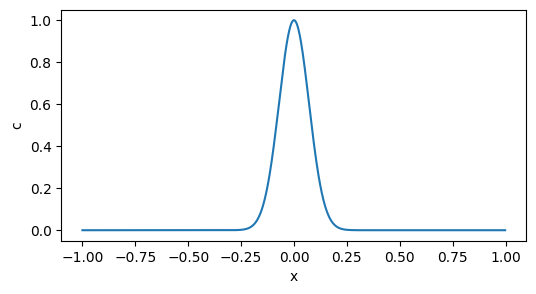

In [144]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

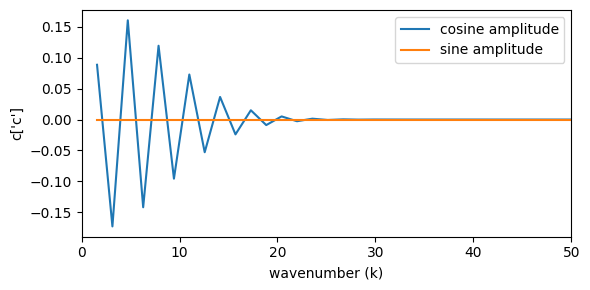

In [145]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [146]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [147]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


2024-10-24 11:31:52,828 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [148]:
solver.stop_sim_time = 30 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [149]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

INFO:solvers:Simulation stop time reached.


2024-10-24 11:31:55,117 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

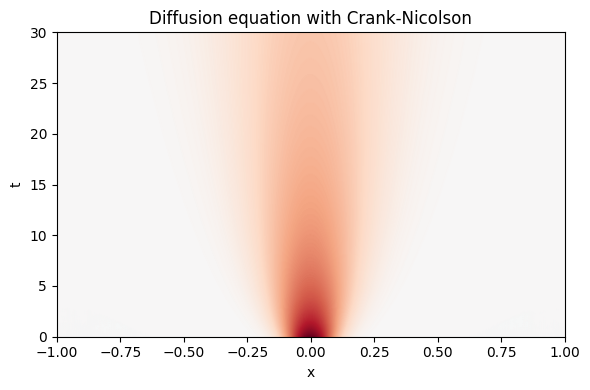

In [150]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [151]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

In [32]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx/2; x_end=Lx/2 # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 100000 # Stop at 10 clock time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)




DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: dt(c) + -1*0.001*dx(dx(c))
DEBUG:problems:  RHS: <Field 134911982743088>
DEBUG:problems:  condition: True
DEBUG:problems:  M: c
DEBUG:problems:  L: -1*0.001*dx(dx(c))
DEBUG:problems:  F: <Field 134911982743088>
DEBUG:solvers:Beginning IVP instantiation
INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


2024-10-24 12:23:54,058 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.4e+00/s


DEBUG:solvers:Finished IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (1024,), 0)
INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-10-24 12:23:54,689 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-10-24 12:23:54,974 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-10-24 12:23:55,144 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-10-24 12:23:55,323 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-10-24 12:23:55,502 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-10-24 12:23:55,676 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-10-24 12:23:55,858 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-10-24 12:23:56,034 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-10-24 12:23:56,208 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-10-24 12:23:56,390 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-10-24 12:23:56,581 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-10-24 12:23:56,787 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-10-24 12:23:56,948 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-10-24 12:23:57,123 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-10-24 12:23:57,279 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-10-24 12:23:57,458 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-10-24 12:23:57,623 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-10-24 12:23:57,809 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-10-24 12:23:57,984 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-10-24 12:23:58,166 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-10-24 12:23:58,355 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-10-24 12:23:58,541 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-10-24 12:23:58,732 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-10-24 12:23:58,895 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-10-24 12:23:59,062 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-10-24 12:23:59,228 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-10-24 12:23:59,405 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-10-24 12:23:59,596 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-10-24 12:23:59,792 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-10-24 12:23:59,952 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-10-24 12:24:00,116 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-10-24 12:24:00,273 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-10-24 12:24:00,438 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-10-24 12:24:00,622 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-10-24 12:24:00,803 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-10-24 12:24:00,967 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-10-24 12:24:01,134 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-10-24 12:24:01,326 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-10-24 12:24:01,513 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-10-24 12:24:01,738 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-10-24 12:24:01,923 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-10-24 12:24:02,098 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-10-24 12:24:02,268 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-10-24 12:24:02,439 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-10-24 12:24:02,607 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-10-24 12:24:02,804 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-10-24 12:24:02,971 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-10-24 12:24:03,140 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-10-24 12:24:03,328 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-10-24 12:24:03,523 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-10-24 12:24:03,749 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-10-24 12:24:03,912 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-10-24 12:24:04,105 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-10-24 12:24:04,283 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-10-24 12:24:04,446 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-10-24 12:24:04,612 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-10-24 12:24:04,815 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-10-24 12:24:05,064 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-10-24 12:24:05,326 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-10-24 12:24:05,565 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-10-24 12:24:05,833 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-10-24 12:24:06,080 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-10-24 12:24:06,320 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-10-24 12:24:06,572 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-10-24 12:24:06,860 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-10-24 12:24:07,127 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-10-24 12:24:07,407 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-10-24 12:24:07,669 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-10-24 12:24:07,968 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-10-24 12:24:08,294 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-10-24 12:24:08,577 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-10-24 12:24:08,814 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-10-24 12:24:08,985 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-10-24 12:24:09,160 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-10-24 12:24:09,321 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-10-24 12:24:09,496 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-10-24 12:24:09,670 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-10-24 12:24:09,895 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-10-24 12:24:10,087 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-10-24 12:24:10,263 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


2024-10-24 12:24:10,434 __main__ 0/1 INFO :: Iteration=40500, Time=4.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


2024-10-24 12:24:10,609 __main__ 0/1 INFO :: Iteration=41000, Time=4.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


2024-10-24 12:24:10,803 __main__ 0/1 INFO :: Iteration=41500, Time=4.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


2024-10-24 12:24:10,973 __main__ 0/1 INFO :: Iteration=42000, Time=4.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


2024-10-24 12:24:11,167 __main__ 0/1 INFO :: Iteration=42500, Time=4.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


2024-10-24 12:24:11,342 __main__ 0/1 INFO :: Iteration=43000, Time=4.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


2024-10-24 12:24:11,508 __main__ 0/1 INFO :: Iteration=43500, Time=4.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


2024-10-24 12:24:11,673 __main__ 0/1 INFO :: Iteration=44000, Time=4.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


2024-10-24 12:24:11,855 __main__ 0/1 INFO :: Iteration=44500, Time=4.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


2024-10-24 12:24:12,014 __main__ 0/1 INFO :: Iteration=45000, Time=4.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


2024-10-24 12:24:12,218 __main__ 0/1 INFO :: Iteration=45500, Time=4.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


2024-10-24 12:24:12,380 __main__ 0/1 INFO :: Iteration=46000, Time=4.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


2024-10-24 12:24:12,542 __main__ 0/1 INFO :: Iteration=46500, Time=4.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


2024-10-24 12:24:12,748 __main__ 0/1 INFO :: Iteration=47000, Time=4.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


2024-10-24 12:24:12,918 __main__ 0/1 INFO :: Iteration=47500, Time=4.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


2024-10-24 12:24:13,093 __main__ 0/1 INFO :: Iteration=48000, Time=4.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


2024-10-24 12:24:13,294 __main__ 0/1 INFO :: Iteration=48500, Time=4.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


2024-10-24 12:24:13,465 __main__ 0/1 INFO :: Iteration=49000, Time=4.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


2024-10-24 12:24:13,653 __main__ 0/1 INFO :: Iteration=49500, Time=4.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


2024-10-24 12:24:13,859 __main__ 0/1 INFO :: Iteration=50000, Time=5.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=50500, Time=5.050000e+03, dt=1.000000e-01


2024-10-24 12:24:14,021 __main__ 0/1 INFO :: Iteration=50500, Time=5.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=51000, Time=5.100000e+03, dt=1.000000e-01


2024-10-24 12:24:14,227 __main__ 0/1 INFO :: Iteration=51000, Time=5.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=51500, Time=5.150000e+03, dt=1.000000e-01


2024-10-24 12:24:14,405 __main__ 0/1 INFO :: Iteration=51500, Time=5.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=52000, Time=5.200000e+03, dt=1.000000e-01


2024-10-24 12:24:14,593 __main__ 0/1 INFO :: Iteration=52000, Time=5.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=52500, Time=5.250000e+03, dt=1.000000e-01


2024-10-24 12:24:14,780 __main__ 0/1 INFO :: Iteration=52500, Time=5.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=53000, Time=5.300000e+03, dt=1.000000e-01


2024-10-24 12:24:14,940 __main__ 0/1 INFO :: Iteration=53000, Time=5.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=53500, Time=5.350000e+03, dt=1.000000e-01


2024-10-24 12:24:15,123 __main__ 0/1 INFO :: Iteration=53500, Time=5.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=54000, Time=5.400000e+03, dt=1.000000e-01


2024-10-24 12:24:15,307 __main__ 0/1 INFO :: Iteration=54000, Time=5.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=54500, Time=5.450000e+03, dt=1.000000e-01


2024-10-24 12:24:15,486 __main__ 0/1 INFO :: Iteration=54500, Time=5.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=55000, Time=5.500000e+03, dt=1.000000e-01


2024-10-24 12:24:15,675 __main__ 0/1 INFO :: Iteration=55000, Time=5.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=55500, Time=5.550000e+03, dt=1.000000e-01


2024-10-24 12:24:15,878 __main__ 0/1 INFO :: Iteration=55500, Time=5.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=56000, Time=5.600000e+03, dt=1.000000e-01


2024-10-24 12:24:16,059 __main__ 0/1 INFO :: Iteration=56000, Time=5.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=56500, Time=5.650000e+03, dt=1.000000e-01


2024-10-24 12:24:16,248 __main__ 0/1 INFO :: Iteration=56500, Time=5.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=57000, Time=5.700000e+03, dt=1.000000e-01


2024-10-24 12:24:16,493 __main__ 0/1 INFO :: Iteration=57000, Time=5.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=57500, Time=5.750000e+03, dt=1.000000e-01


2024-10-24 12:24:16,679 __main__ 0/1 INFO :: Iteration=57500, Time=5.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=58000, Time=5.800000e+03, dt=1.000000e-01


2024-10-24 12:24:16,866 __main__ 0/1 INFO :: Iteration=58000, Time=5.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=58500, Time=5.850000e+03, dt=1.000000e-01


2024-10-24 12:24:17,040 __main__ 0/1 INFO :: Iteration=58500, Time=5.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=59000, Time=5.900000e+03, dt=1.000000e-01


2024-10-24 12:24:17,234 __main__ 0/1 INFO :: Iteration=59000, Time=5.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=59500, Time=5.950000e+03, dt=1.000000e-01


2024-10-24 12:24:17,437 __main__ 0/1 INFO :: Iteration=59500, Time=5.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=60000, Time=6.000000e+03, dt=1.000000e-01


2024-10-24 12:24:17,620 __main__ 0/1 INFO :: Iteration=60000, Time=6.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=60500, Time=6.050000e+03, dt=1.000000e-01


2024-10-24 12:24:17,814 __main__ 0/1 INFO :: Iteration=60500, Time=6.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=61000, Time=6.100000e+03, dt=1.000000e-01


2024-10-24 12:24:17,983 __main__ 0/1 INFO :: Iteration=61000, Time=6.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=61500, Time=6.150000e+03, dt=1.000000e-01


2024-10-24 12:24:18,169 __main__ 0/1 INFO :: Iteration=61500, Time=6.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=62000, Time=6.200000e+03, dt=1.000000e-01


2024-10-24 12:24:18,379 __main__ 0/1 INFO :: Iteration=62000, Time=6.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=62500, Time=6.250000e+03, dt=1.000000e-01


2024-10-24 12:24:18,566 __main__ 0/1 INFO :: Iteration=62500, Time=6.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=63000, Time=6.300000e+03, dt=1.000000e-01


2024-10-24 12:24:18,778 __main__ 0/1 INFO :: Iteration=63000, Time=6.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=63500, Time=6.350000e+03, dt=1.000000e-01


2024-10-24 12:24:19,120 __main__ 0/1 INFO :: Iteration=63500, Time=6.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=64000, Time=6.400000e+03, dt=1.000000e-01


2024-10-24 12:24:19,443 __main__ 0/1 INFO :: Iteration=64000, Time=6.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=64500, Time=6.450000e+03, dt=1.000000e-01


2024-10-24 12:24:19,703 __main__ 0/1 INFO :: Iteration=64500, Time=6.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=65000, Time=6.500000e+03, dt=1.000000e-01


2024-10-24 12:24:19,957 __main__ 0/1 INFO :: Iteration=65000, Time=6.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=65500, Time=6.550000e+03, dt=1.000000e-01


2024-10-24 12:24:20,239 __main__ 0/1 INFO :: Iteration=65500, Time=6.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=66000, Time=6.600000e+03, dt=1.000000e-01


2024-10-24 12:24:20,510 __main__ 0/1 INFO :: Iteration=66000, Time=6.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=66500, Time=6.650000e+03, dt=1.000000e-01


2024-10-24 12:24:20,808 __main__ 0/1 INFO :: Iteration=66500, Time=6.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=67000, Time=6.700000e+03, dt=1.000000e-01


2024-10-24 12:24:21,071 __main__ 0/1 INFO :: Iteration=67000, Time=6.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=67500, Time=6.750000e+03, dt=1.000000e-01


2024-10-24 12:24:21,348 __main__ 0/1 INFO :: Iteration=67500, Time=6.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=68000, Time=6.800000e+03, dt=1.000000e-01


2024-10-24 12:24:21,639 __main__ 0/1 INFO :: Iteration=68000, Time=6.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=68500, Time=6.850000e+03, dt=1.000000e-01


2024-10-24 12:24:21,916 __main__ 0/1 INFO :: Iteration=68500, Time=6.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=69000, Time=6.900000e+03, dt=1.000000e-01


2024-10-24 12:24:22,193 __main__ 0/1 INFO :: Iteration=69000, Time=6.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=69500, Time=6.950000e+03, dt=1.000000e-01


2024-10-24 12:24:22,493 __main__ 0/1 INFO :: Iteration=69500, Time=6.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=70000, Time=7.000000e+03, dt=1.000000e-01


2024-10-24 12:24:22,789 __main__ 0/1 INFO :: Iteration=70000, Time=7.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=70500, Time=7.050000e+03, dt=1.000000e-01


2024-10-24 12:24:23,000 __main__ 0/1 INFO :: Iteration=70500, Time=7.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=71000, Time=7.100000e+03, dt=1.000000e-01


2024-10-24 12:24:23,172 __main__ 0/1 INFO :: Iteration=71000, Time=7.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=71500, Time=7.150000e+03, dt=1.000000e-01


2024-10-24 12:24:23,340 __main__ 0/1 INFO :: Iteration=71500, Time=7.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=72000, Time=7.200000e+03, dt=1.000000e-01


2024-10-24 12:24:23,511 __main__ 0/1 INFO :: Iteration=72000, Time=7.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=72500, Time=7.250000e+03, dt=1.000000e-01


2024-10-24 12:24:23,701 __main__ 0/1 INFO :: Iteration=72500, Time=7.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=73000, Time=7.300000e+03, dt=1.000000e-01


2024-10-24 12:24:23,881 __main__ 0/1 INFO :: Iteration=73000, Time=7.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=73500, Time=7.350000e+03, dt=1.000000e-01


2024-10-24 12:24:24,051 __main__ 0/1 INFO :: Iteration=73500, Time=7.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=74000, Time=7.400000e+03, dt=1.000000e-01


2024-10-24 12:24:24,227 __main__ 0/1 INFO :: Iteration=74000, Time=7.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=74500, Time=7.450000e+03, dt=1.000000e-01


2024-10-24 12:24:24,395 __main__ 0/1 INFO :: Iteration=74500, Time=7.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=75000, Time=7.500000e+03, dt=1.000000e-01


2024-10-24 12:24:24,564 __main__ 0/1 INFO :: Iteration=75000, Time=7.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=75500, Time=7.550000e+03, dt=1.000000e-01


2024-10-24 12:24:24,763 __main__ 0/1 INFO :: Iteration=75500, Time=7.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=76000, Time=7.600000e+03, dt=1.000000e-01


2024-10-24 12:24:24,919 __main__ 0/1 INFO :: Iteration=76000, Time=7.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=76500, Time=7.650000e+03, dt=1.000000e-01


2024-10-24 12:24:25,088 __main__ 0/1 INFO :: Iteration=76500, Time=7.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=77000, Time=7.700000e+03, dt=1.000000e-01


2024-10-24 12:24:25,253 __main__ 0/1 INFO :: Iteration=77000, Time=7.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=77500, Time=7.750000e+03, dt=1.000000e-01


2024-10-24 12:24:25,423 __main__ 0/1 INFO :: Iteration=77500, Time=7.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=78000, Time=7.800000e+03, dt=1.000000e-01


2024-10-24 12:24:25,589 __main__ 0/1 INFO :: Iteration=78000, Time=7.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=78500, Time=7.850000e+03, dt=1.000000e-01


2024-10-24 12:24:25,795 __main__ 0/1 INFO :: Iteration=78500, Time=7.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=79000, Time=7.900000e+03, dt=1.000000e-01


2024-10-24 12:24:25,959 __main__ 0/1 INFO :: Iteration=79000, Time=7.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=79500, Time=7.950000e+03, dt=1.000000e-01


2024-10-24 12:24:26,139 __main__ 0/1 INFO :: Iteration=79500, Time=7.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=80000, Time=8.000000e+03, dt=1.000000e-01


2024-10-24 12:24:26,326 __main__ 0/1 INFO :: Iteration=80000, Time=8.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=80500, Time=8.050000e+03, dt=1.000000e-01


2024-10-24 12:24:26,500 __main__ 0/1 INFO :: Iteration=80500, Time=8.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=81000, Time=8.100000e+03, dt=1.000000e-01


2024-10-24 12:24:26,677 __main__ 0/1 INFO :: Iteration=81000, Time=8.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=81500, Time=8.150000e+03, dt=1.000000e-01


2024-10-24 12:24:26,871 __main__ 0/1 INFO :: Iteration=81500, Time=8.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=82000, Time=8.200000e+03, dt=1.000000e-01


2024-10-24 12:24:27,040 __main__ 0/1 INFO :: Iteration=82000, Time=8.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=82500, Time=8.250000e+03, dt=1.000000e-01


2024-10-24 12:24:27,227 __main__ 0/1 INFO :: Iteration=82500, Time=8.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=83000, Time=8.300000e+03, dt=1.000000e-01


2024-10-24 12:24:27,386 __main__ 0/1 INFO :: Iteration=83000, Time=8.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=83500, Time=8.350000e+03, dt=1.000000e-01


2024-10-24 12:24:27,552 __main__ 0/1 INFO :: Iteration=83500, Time=8.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=84000, Time=8.400000e+03, dt=1.000000e-01


2024-10-24 12:24:27,736 __main__ 0/1 INFO :: Iteration=84000, Time=8.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=84500, Time=8.450000e+03, dt=1.000000e-01


2024-10-24 12:24:27,912 __main__ 0/1 INFO :: Iteration=84500, Time=8.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=85000, Time=8.500000e+03, dt=1.000000e-01


2024-10-24 12:24:28,118 __main__ 0/1 INFO :: Iteration=85000, Time=8.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=85500, Time=8.550000e+03, dt=1.000000e-01


2024-10-24 12:24:28,279 __main__ 0/1 INFO :: Iteration=85500, Time=8.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=86000, Time=8.600000e+03, dt=1.000000e-01


2024-10-24 12:24:28,448 __main__ 0/1 INFO :: Iteration=86000, Time=8.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=86500, Time=8.650000e+03, dt=1.000000e-01


2024-10-24 12:24:28,613 __main__ 0/1 INFO :: Iteration=86500, Time=8.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=87000, Time=8.700000e+03, dt=1.000000e-01


2024-10-24 12:24:28,825 __main__ 0/1 INFO :: Iteration=87000, Time=8.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=87500, Time=8.750000e+03, dt=1.000000e-01


2024-10-24 12:24:29,014 __main__ 0/1 INFO :: Iteration=87500, Time=8.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=88000, Time=8.800000e+03, dt=1.000000e-01


2024-10-24 12:24:29,196 __main__ 0/1 INFO :: Iteration=88000, Time=8.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=88500, Time=8.850000e+03, dt=1.000000e-01


2024-10-24 12:24:29,371 __main__ 0/1 INFO :: Iteration=88500, Time=8.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=89000, Time=8.900000e+03, dt=1.000000e-01


2024-10-24 12:24:29,549 __main__ 0/1 INFO :: Iteration=89000, Time=8.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=89500, Time=8.950000e+03, dt=1.000000e-01


2024-10-24 12:24:29,738 __main__ 0/1 INFO :: Iteration=89500, Time=8.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=90000, Time=9.000000e+03, dt=1.000000e-01


2024-10-24 12:24:29,930 __main__ 0/1 INFO :: Iteration=90000, Time=9.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=90500, Time=9.050000e+03, dt=1.000000e-01


2024-10-24 12:24:30,104 __main__ 0/1 INFO :: Iteration=90500, Time=9.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=91000, Time=9.100000e+03, dt=1.000000e-01


2024-10-24 12:24:30,299 __main__ 0/1 INFO :: Iteration=91000, Time=9.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=91500, Time=9.150000e+03, dt=1.000000e-01


2024-10-24 12:24:30,474 __main__ 0/1 INFO :: Iteration=91500, Time=9.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=92000, Time=9.200000e+03, dt=1.000000e-01


2024-10-24 12:24:30,655 __main__ 0/1 INFO :: Iteration=92000, Time=9.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=92500, Time=9.250000e+03, dt=1.000000e-01


2024-10-24 12:24:30,846 __main__ 0/1 INFO :: Iteration=92500, Time=9.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=93000, Time=9.300000e+03, dt=1.000000e-01


2024-10-24 12:24:31,028 __main__ 0/1 INFO :: Iteration=93000, Time=9.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=93500, Time=9.350000e+03, dt=1.000000e-01


2024-10-24 12:24:31,213 __main__ 0/1 INFO :: Iteration=93500, Time=9.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=94000, Time=9.400000e+03, dt=1.000000e-01


2024-10-24 12:24:31,396 __main__ 0/1 INFO :: Iteration=94000, Time=9.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=94500, Time=9.450000e+03, dt=1.000000e-01


2024-10-24 12:24:31,580 __main__ 0/1 INFO :: Iteration=94500, Time=9.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=95000, Time=9.500000e+03, dt=1.000000e-01


2024-10-24 12:24:31,780 __main__ 0/1 INFO :: Iteration=95000, Time=9.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=95500, Time=9.550000e+03, dt=1.000000e-01


2024-10-24 12:24:31,971 __main__ 0/1 INFO :: Iteration=95500, Time=9.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=96000, Time=9.600000e+03, dt=1.000000e-01


2024-10-24 12:24:32,167 __main__ 0/1 INFO :: Iteration=96000, Time=9.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=96500, Time=9.650000e+03, dt=1.000000e-01


2024-10-24 12:24:32,364 __main__ 0/1 INFO :: Iteration=96500, Time=9.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=97000, Time=9.700000e+03, dt=1.000000e-01


2024-10-24 12:24:32,558 __main__ 0/1 INFO :: Iteration=97000, Time=9.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=97500, Time=9.750000e+03, dt=1.000000e-01


2024-10-24 12:24:32,778 __main__ 0/1 INFO :: Iteration=97500, Time=9.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=98000, Time=9.800000e+03, dt=1.000000e-01


2024-10-24 12:24:32,980 __main__ 0/1 INFO :: Iteration=98000, Time=9.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=98500, Time=9.850000e+03, dt=1.000000e-01


2024-10-24 12:24:33,285 __main__ 0/1 INFO :: Iteration=98500, Time=9.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=99000, Time=9.900000e+03, dt=1.000000e-01


2024-10-24 12:24:33,556 __main__ 0/1 INFO :: Iteration=99000, Time=9.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=99500, Time=9.950000e+03, dt=1.000000e-01


2024-10-24 12:24:33,824 __main__ 0/1 INFO :: Iteration=99500, Time=9.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=100000, Time=1.000000e+04, dt=1.000000e-01


2024-10-24 12:24:34,074 __main__ 0/1 INFO :: Iteration=100000, Time=1.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=100500, Time=1.005000e+04, dt=1.000000e-01


2024-10-24 12:24:34,359 __main__ 0/1 INFO :: Iteration=100500, Time=1.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=101000, Time=1.010000e+04, dt=1.000000e-01


2024-10-24 12:24:34,621 __main__ 0/1 INFO :: Iteration=101000, Time=1.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=101500, Time=1.015000e+04, dt=1.000000e-01


2024-10-24 12:24:34,879 __main__ 0/1 INFO :: Iteration=101500, Time=1.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=102000, Time=1.020000e+04, dt=1.000000e-01


2024-10-24 12:24:35,167 __main__ 0/1 INFO :: Iteration=102000, Time=1.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=102500, Time=1.025000e+04, dt=1.000000e-01


2024-10-24 12:24:35,473 __main__ 0/1 INFO :: Iteration=102500, Time=1.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=103000, Time=1.030000e+04, dt=1.000000e-01


2024-10-24 12:24:35,766 __main__ 0/1 INFO :: Iteration=103000, Time=1.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=103500, Time=1.035000e+04, dt=1.000000e-01


2024-10-24 12:24:36,052 __main__ 0/1 INFO :: Iteration=103500, Time=1.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=104000, Time=1.040000e+04, dt=1.000000e-01


2024-10-24 12:24:36,347 __main__ 0/1 INFO :: Iteration=104000, Time=1.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=104500, Time=1.045000e+04, dt=1.000000e-01


2024-10-24 12:24:36,631 __main__ 0/1 INFO :: Iteration=104500, Time=1.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=105000, Time=1.050000e+04, dt=1.000000e-01


2024-10-24 12:24:36,930 __main__ 0/1 INFO :: Iteration=105000, Time=1.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=105500, Time=1.055000e+04, dt=1.000000e-01


2024-10-24 12:24:37,231 __main__ 0/1 INFO :: Iteration=105500, Time=1.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=106000, Time=1.060000e+04, dt=1.000000e-01


2024-10-24 12:24:37,450 __main__ 0/1 INFO :: Iteration=106000, Time=1.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=106500, Time=1.065000e+04, dt=1.000000e-01


2024-10-24 12:24:37,625 __main__ 0/1 INFO :: Iteration=106500, Time=1.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=107000, Time=1.070000e+04, dt=1.000000e-01


2024-10-24 12:24:37,816 __main__ 0/1 INFO :: Iteration=107000, Time=1.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=107500, Time=1.075000e+04, dt=1.000000e-01


2024-10-24 12:24:37,997 __main__ 0/1 INFO :: Iteration=107500, Time=1.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=108000, Time=1.080000e+04, dt=1.000000e-01


2024-10-24 12:24:38,206 __main__ 0/1 INFO :: Iteration=108000, Time=1.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=108500, Time=1.085000e+04, dt=1.000000e-01


2024-10-24 12:24:38,444 __main__ 0/1 INFO :: Iteration=108500, Time=1.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=109000, Time=1.090000e+04, dt=1.000000e-01


2024-10-24 12:24:38,645 __main__ 0/1 INFO :: Iteration=109000, Time=1.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=109500, Time=1.095000e+04, dt=1.000000e-01


2024-10-24 12:24:38,859 __main__ 0/1 INFO :: Iteration=109500, Time=1.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=110000, Time=1.100000e+04, dt=1.000000e-01


2024-10-24 12:24:39,061 __main__ 0/1 INFO :: Iteration=110000, Time=1.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=110500, Time=1.105000e+04, dt=1.000000e-01


2024-10-24 12:24:39,250 __main__ 0/1 INFO :: Iteration=110500, Time=1.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=111000, Time=1.110000e+04, dt=1.000000e-01


2024-10-24 12:24:39,469 __main__ 0/1 INFO :: Iteration=111000, Time=1.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=111500, Time=1.115000e+04, dt=1.000000e-01


2024-10-24 12:24:39,695 __main__ 0/1 INFO :: Iteration=111500, Time=1.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=112000, Time=1.120000e+04, dt=1.000000e-01


2024-10-24 12:24:39,949 __main__ 0/1 INFO :: Iteration=112000, Time=1.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=112500, Time=1.125000e+04, dt=1.000000e-01


2024-10-24 12:24:40,139 __main__ 0/1 INFO :: Iteration=112500, Time=1.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=113000, Time=1.130000e+04, dt=1.000000e-01


2024-10-24 12:24:40,330 __main__ 0/1 INFO :: Iteration=113000, Time=1.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=113500, Time=1.135000e+04, dt=1.000000e-01


2024-10-24 12:24:40,534 __main__ 0/1 INFO :: Iteration=113500, Time=1.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=114000, Time=1.140000e+04, dt=1.000000e-01


2024-10-24 12:24:40,763 __main__ 0/1 INFO :: Iteration=114000, Time=1.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=114500, Time=1.145000e+04, dt=1.000000e-01


2024-10-24 12:24:41,078 __main__ 0/1 INFO :: Iteration=114500, Time=1.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=115000, Time=1.150000e+04, dt=1.000000e-01


2024-10-24 12:24:41,418 __main__ 0/1 INFO :: Iteration=115000, Time=1.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=115500, Time=1.155000e+04, dt=1.000000e-01


2024-10-24 12:24:41,758 __main__ 0/1 INFO :: Iteration=115500, Time=1.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=116000, Time=1.160000e+04, dt=1.000000e-01


2024-10-24 12:24:42,061 __main__ 0/1 INFO :: Iteration=116000, Time=1.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=116500, Time=1.165000e+04, dt=1.000000e-01


2024-10-24 12:24:42,708 __main__ 0/1 INFO :: Iteration=116500, Time=1.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=117000, Time=1.170000e+04, dt=1.000000e-01


2024-10-24 12:24:42,956 __main__ 0/1 INFO :: Iteration=117000, Time=1.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=117500, Time=1.175000e+04, dt=1.000000e-01


2024-10-24 12:24:43,123 __main__ 0/1 INFO :: Iteration=117500, Time=1.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=118000, Time=1.180000e+04, dt=1.000000e-01


2024-10-24 12:24:43,325 __main__ 0/1 INFO :: Iteration=118000, Time=1.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=118500, Time=1.185000e+04, dt=1.000000e-01


2024-10-24 12:24:43,527 __main__ 0/1 INFO :: Iteration=118500, Time=1.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=119000, Time=1.190000e+04, dt=1.000000e-01


2024-10-24 12:24:43,769 __main__ 0/1 INFO :: Iteration=119000, Time=1.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=119500, Time=1.195000e+04, dt=1.000000e-01


2024-10-24 12:24:43,965 __main__ 0/1 INFO :: Iteration=119500, Time=1.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=120000, Time=1.200000e+04, dt=1.000000e-01


2024-10-24 12:24:44,173 __main__ 0/1 INFO :: Iteration=120000, Time=1.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=120500, Time=1.205000e+04, dt=1.000000e-01


2024-10-24 12:24:44,353 __main__ 0/1 INFO :: Iteration=120500, Time=1.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=121000, Time=1.210000e+04, dt=1.000000e-01


2024-10-24 12:24:44,532 __main__ 0/1 INFO :: Iteration=121000, Time=1.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=121500, Time=1.215000e+04, dt=1.000000e-01


2024-10-24 12:24:44,751 __main__ 0/1 INFO :: Iteration=121500, Time=1.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=122000, Time=1.220000e+04, dt=1.000000e-01


2024-10-24 12:24:44,915 __main__ 0/1 INFO :: Iteration=122000, Time=1.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=122500, Time=1.225000e+04, dt=1.000000e-01


2024-10-24 12:24:45,092 __main__ 0/1 INFO :: Iteration=122500, Time=1.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=123000, Time=1.230000e+04, dt=1.000000e-01


2024-10-24 12:24:45,283 __main__ 0/1 INFO :: Iteration=123000, Time=1.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=123500, Time=1.235000e+04, dt=1.000000e-01


2024-10-24 12:24:45,464 __main__ 0/1 INFO :: Iteration=123500, Time=1.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=124000, Time=1.240000e+04, dt=1.000000e-01


2024-10-24 12:24:45,666 __main__ 0/1 INFO :: Iteration=124000, Time=1.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=124500, Time=1.245000e+04, dt=1.000000e-01


2024-10-24 12:24:45,873 __main__ 0/1 INFO :: Iteration=124500, Time=1.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=125000, Time=1.250000e+04, dt=1.000000e-01


2024-10-24 12:24:46,053 __main__ 0/1 INFO :: Iteration=125000, Time=1.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=125500, Time=1.255000e+04, dt=1.000000e-01


2024-10-24 12:24:46,229 __main__ 0/1 INFO :: Iteration=125500, Time=1.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=126000, Time=1.260000e+04, dt=1.000000e-01


2024-10-24 12:24:46,425 __main__ 0/1 INFO :: Iteration=126000, Time=1.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=126500, Time=1.265000e+04, dt=1.000000e-01


2024-10-24 12:24:46,614 __main__ 0/1 INFO :: Iteration=126500, Time=1.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=127000, Time=1.270000e+04, dt=1.000000e-01


2024-10-24 12:24:46,827 __main__ 0/1 INFO :: Iteration=127000, Time=1.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=127500, Time=1.275000e+04, dt=1.000000e-01


2024-10-24 12:24:47,024 __main__ 0/1 INFO :: Iteration=127500, Time=1.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=128000, Time=1.280000e+04, dt=1.000000e-01


2024-10-24 12:24:47,229 __main__ 0/1 INFO :: Iteration=128000, Time=1.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=128500, Time=1.285000e+04, dt=1.000000e-01


2024-10-24 12:24:47,513 __main__ 0/1 INFO :: Iteration=128500, Time=1.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=129000, Time=1.290000e+04, dt=1.000000e-01


2024-10-24 12:24:47,850 __main__ 0/1 INFO :: Iteration=129000, Time=1.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=129500, Time=1.295000e+04, dt=1.000000e-01


2024-10-24 12:24:48,193 __main__ 0/1 INFO :: Iteration=129500, Time=1.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=130000, Time=1.300000e+04, dt=1.000000e-01


2024-10-24 12:24:48,487 __main__ 0/1 INFO :: Iteration=130000, Time=1.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=130500, Time=1.305000e+04, dt=1.000000e-01


2024-10-24 12:24:48,802 __main__ 0/1 INFO :: Iteration=130500, Time=1.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=131000, Time=1.310000e+04, dt=1.000000e-01


2024-10-24 12:24:49,120 __main__ 0/1 INFO :: Iteration=131000, Time=1.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=131500, Time=1.315000e+04, dt=1.000000e-01


2024-10-24 12:24:49,429 __main__ 0/1 INFO :: Iteration=131500, Time=1.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=132000, Time=1.320000e+04, dt=1.000000e-01


2024-10-24 12:24:49,753 __main__ 0/1 INFO :: Iteration=132000, Time=1.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=132500, Time=1.325000e+04, dt=1.000000e-01


2024-10-24 12:24:50,056 __main__ 0/1 INFO :: Iteration=132500, Time=1.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=133000, Time=1.330000e+04, dt=1.000000e-01


2024-10-24 12:24:50,363 __main__ 0/1 INFO :: Iteration=133000, Time=1.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=133500, Time=1.335000e+04, dt=1.000000e-01


2024-10-24 12:24:50,678 __main__ 0/1 INFO :: Iteration=133500, Time=1.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=134000, Time=1.340000e+04, dt=1.000000e-01


2024-10-24 12:24:50,977 __main__ 0/1 INFO :: Iteration=134000, Time=1.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=134500, Time=1.345000e+04, dt=1.000000e-01


2024-10-24 12:24:51,271 __main__ 0/1 INFO :: Iteration=134500, Time=1.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=135000, Time=1.350000e+04, dt=1.000000e-01


2024-10-24 12:24:51,544 __main__ 0/1 INFO :: Iteration=135000, Time=1.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=135500, Time=1.355000e+04, dt=1.000000e-01


2024-10-24 12:24:51,729 __main__ 0/1 INFO :: Iteration=135500, Time=1.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=136000, Time=1.360000e+04, dt=1.000000e-01


2024-10-24 12:24:51,905 __main__ 0/1 INFO :: Iteration=136000, Time=1.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=136500, Time=1.365000e+04, dt=1.000000e-01


2024-10-24 12:24:52,108 __main__ 0/1 INFO :: Iteration=136500, Time=1.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=137000, Time=1.370000e+04, dt=1.000000e-01


2024-10-24 12:24:52,303 __main__ 0/1 INFO :: Iteration=137000, Time=1.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=137500, Time=1.375000e+04, dt=1.000000e-01


2024-10-24 12:24:52,495 __main__ 0/1 INFO :: Iteration=137500, Time=1.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=138000, Time=1.380000e+04, dt=1.000000e-01


2024-10-24 12:24:52,704 __main__ 0/1 INFO :: Iteration=138000, Time=1.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=138500, Time=1.385000e+04, dt=1.000000e-01


2024-10-24 12:24:52,902 __main__ 0/1 INFO :: Iteration=138500, Time=1.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=139000, Time=1.390000e+04, dt=1.000000e-01


2024-10-24 12:24:53,101 __main__ 0/1 INFO :: Iteration=139000, Time=1.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=139500, Time=1.395000e+04, dt=1.000000e-01


2024-10-24 12:24:53,293 __main__ 0/1 INFO :: Iteration=139500, Time=1.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=140000, Time=1.400000e+04, dt=1.000000e-01


2024-10-24 12:24:53,485 __main__ 0/1 INFO :: Iteration=140000, Time=1.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=140500, Time=1.405000e+04, dt=1.000000e-01


2024-10-24 12:24:53,681 __main__ 0/1 INFO :: Iteration=140500, Time=1.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=141000, Time=1.410000e+04, dt=1.000000e-01


2024-10-24 12:24:53,878 __main__ 0/1 INFO :: Iteration=141000, Time=1.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=141500, Time=1.415000e+04, dt=1.000000e-01


2024-10-24 12:24:54,062 __main__ 0/1 INFO :: Iteration=141500, Time=1.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=142000, Time=1.420000e+04, dt=1.000000e-01


2024-10-24 12:24:54,257 __main__ 0/1 INFO :: Iteration=142000, Time=1.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=142500, Time=1.425000e+04, dt=1.000000e-01


2024-10-24 12:24:54,460 __main__ 0/1 INFO :: Iteration=142500, Time=1.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=143000, Time=1.430000e+04, dt=1.000000e-01


2024-10-24 12:24:54,652 __main__ 0/1 INFO :: Iteration=143000, Time=1.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=143500, Time=1.435000e+04, dt=1.000000e-01


2024-10-24 12:24:54,859 __main__ 0/1 INFO :: Iteration=143500, Time=1.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=144000, Time=1.440000e+04, dt=1.000000e-01


2024-10-24 12:24:55,054 __main__ 0/1 INFO :: Iteration=144000, Time=1.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=144500, Time=1.445000e+04, dt=1.000000e-01


2024-10-24 12:24:55,242 __main__ 0/1 INFO :: Iteration=144500, Time=1.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=145000, Time=1.450000e+04, dt=1.000000e-01


2024-10-24 12:24:55,439 __main__ 0/1 INFO :: Iteration=145000, Time=1.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=145500, Time=1.455000e+04, dt=1.000000e-01


2024-10-24 12:24:55,654 __main__ 0/1 INFO :: Iteration=145500, Time=1.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=146000, Time=1.460000e+04, dt=1.000000e-01


2024-10-24 12:24:55,897 __main__ 0/1 INFO :: Iteration=146000, Time=1.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=146500, Time=1.465000e+04, dt=1.000000e-01


2024-10-24 12:24:56,095 __main__ 0/1 INFO :: Iteration=146500, Time=1.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=147000, Time=1.470000e+04, dt=1.000000e-01


2024-10-24 12:24:56,336 __main__ 0/1 INFO :: Iteration=147000, Time=1.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=147500, Time=1.475000e+04, dt=1.000000e-01


2024-10-24 12:24:56,545 __main__ 0/1 INFO :: Iteration=147500, Time=1.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=148000, Time=1.480000e+04, dt=1.000000e-01


2024-10-24 12:24:56,761 __main__ 0/1 INFO :: Iteration=148000, Time=1.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=148500, Time=1.485000e+04, dt=1.000000e-01


2024-10-24 12:24:56,957 __main__ 0/1 INFO :: Iteration=148500, Time=1.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=149000, Time=1.490000e+04, dt=1.000000e-01


2024-10-24 12:24:57,131 __main__ 0/1 INFO :: Iteration=149000, Time=1.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=149500, Time=1.495000e+04, dt=1.000000e-01


2024-10-24 12:24:57,354 __main__ 0/1 INFO :: Iteration=149500, Time=1.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=150000, Time=1.500000e+04, dt=1.000000e-01


2024-10-24 12:24:57,569 __main__ 0/1 INFO :: Iteration=150000, Time=1.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=150500, Time=1.505000e+04, dt=1.000000e-01


2024-10-24 12:24:57,765 __main__ 0/1 INFO :: Iteration=150500, Time=1.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=151000, Time=1.510000e+04, dt=1.000000e-01


2024-10-24 12:24:57,956 __main__ 0/1 INFO :: Iteration=151000, Time=1.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=151500, Time=1.515000e+04, dt=1.000000e-01


2024-10-24 12:24:58,168 __main__ 0/1 INFO :: Iteration=151500, Time=1.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=152000, Time=1.520000e+04, dt=1.000000e-01


2024-10-24 12:24:58,387 __main__ 0/1 INFO :: Iteration=152000, Time=1.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=152500, Time=1.525000e+04, dt=1.000000e-01


2024-10-24 12:24:58,604 __main__ 0/1 INFO :: Iteration=152500, Time=1.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=153000, Time=1.530000e+04, dt=1.000000e-01


2024-10-24 12:24:58,825 __main__ 0/1 INFO :: Iteration=153000, Time=1.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=153500, Time=1.535000e+04, dt=1.000000e-01


2024-10-24 12:24:59,032 __main__ 0/1 INFO :: Iteration=153500, Time=1.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=154000, Time=1.540000e+04, dt=1.000000e-01


2024-10-24 12:24:59,258 __main__ 0/1 INFO :: Iteration=154000, Time=1.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=154500, Time=1.545000e+04, dt=1.000000e-01


2024-10-24 12:24:59,489 __main__ 0/1 INFO :: Iteration=154500, Time=1.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=155000, Time=1.550000e+04, dt=1.000000e-01


2024-10-24 12:24:59,698 __main__ 0/1 INFO :: Iteration=155000, Time=1.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=155500, Time=1.555000e+04, dt=1.000000e-01


2024-10-24 12:24:59,904 __main__ 0/1 INFO :: Iteration=155500, Time=1.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=156000, Time=1.560000e+04, dt=1.000000e-01


2024-10-24 12:25:00,099 __main__ 0/1 INFO :: Iteration=156000, Time=1.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=156500, Time=1.565000e+04, dt=1.000000e-01


2024-10-24 12:25:00,285 __main__ 0/1 INFO :: Iteration=156500, Time=1.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=157000, Time=1.570000e+04, dt=1.000000e-01


2024-10-24 12:25:00,498 __main__ 0/1 INFO :: Iteration=157000, Time=1.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=157500, Time=1.575000e+04, dt=1.000000e-01


2024-10-24 12:25:00,704 __main__ 0/1 INFO :: Iteration=157500, Time=1.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=158000, Time=1.580000e+04, dt=1.000000e-01


2024-10-24 12:25:00,902 __main__ 0/1 INFO :: Iteration=158000, Time=1.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=158500, Time=1.585000e+04, dt=1.000000e-01


2024-10-24 12:25:01,102 __main__ 0/1 INFO :: Iteration=158500, Time=1.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=159000, Time=1.590000e+04, dt=1.000000e-01


2024-10-24 12:25:01,299 __main__ 0/1 INFO :: Iteration=159000, Time=1.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=159500, Time=1.595000e+04, dt=1.000000e-01


2024-10-24 12:25:01,513 __main__ 0/1 INFO :: Iteration=159500, Time=1.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=160000, Time=1.600000e+04, dt=1.000000e-01


2024-10-24 12:25:01,823 __main__ 0/1 INFO :: Iteration=160000, Time=1.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=160500, Time=1.605000e+04, dt=1.000000e-01


2024-10-24 12:25:02,090 __main__ 0/1 INFO :: Iteration=160500, Time=1.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=161000, Time=1.610000e+04, dt=1.000000e-01


2024-10-24 12:25:02,340 __main__ 0/1 INFO :: Iteration=161000, Time=1.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=161500, Time=1.615000e+04, dt=1.000000e-01


2024-10-24 12:25:02,613 __main__ 0/1 INFO :: Iteration=161500, Time=1.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=162000, Time=1.620000e+04, dt=1.000000e-01


2024-10-24 12:25:02,883 __main__ 0/1 INFO :: Iteration=162000, Time=1.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=162500, Time=1.625000e+04, dt=1.000000e-01


2024-10-24 12:25:03,147 __main__ 0/1 INFO :: Iteration=162500, Time=1.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=163000, Time=1.630000e+04, dt=1.000000e-01


2024-10-24 12:25:03,410 __main__ 0/1 INFO :: Iteration=163000, Time=1.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=163500, Time=1.635000e+04, dt=1.000000e-01


2024-10-24 12:25:03,732 __main__ 0/1 INFO :: Iteration=163500, Time=1.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=164000, Time=1.640000e+04, dt=1.000000e-01


2024-10-24 12:25:04,010 __main__ 0/1 INFO :: Iteration=164000, Time=1.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=164500, Time=1.645000e+04, dt=1.000000e-01


2024-10-24 12:25:04,309 __main__ 0/1 INFO :: Iteration=164500, Time=1.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=165000, Time=1.650000e+04, dt=1.000000e-01


2024-10-24 12:25:04,603 __main__ 0/1 INFO :: Iteration=165000, Time=1.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=165500, Time=1.655000e+04, dt=1.000000e-01


2024-10-24 12:25:04,890 __main__ 0/1 INFO :: Iteration=165500, Time=1.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=166000, Time=1.660000e+04, dt=1.000000e-01


2024-10-24 12:25:05,183 __main__ 0/1 INFO :: Iteration=166000, Time=1.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=166500, Time=1.665000e+04, dt=1.000000e-01


2024-10-24 12:25:05,487 __main__ 0/1 INFO :: Iteration=166500, Time=1.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=167000, Time=1.670000e+04, dt=1.000000e-01


2024-10-24 12:25:05,768 __main__ 0/1 INFO :: Iteration=167000, Time=1.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=167500, Time=1.675000e+04, dt=1.000000e-01


2024-10-24 12:25:05,942 __main__ 0/1 INFO :: Iteration=167500, Time=1.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=168000, Time=1.680000e+04, dt=1.000000e-01


2024-10-24 12:25:06,134 __main__ 0/1 INFO :: Iteration=168000, Time=1.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=168500, Time=1.685000e+04, dt=1.000000e-01


2024-10-24 12:25:06,312 __main__ 0/1 INFO :: Iteration=168500, Time=1.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=169000, Time=1.690000e+04, dt=1.000000e-01


2024-10-24 12:25:06,488 __main__ 0/1 INFO :: Iteration=169000, Time=1.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=169500, Time=1.695000e+04, dt=1.000000e-01


2024-10-24 12:25:06,711 __main__ 0/1 INFO :: Iteration=169500, Time=1.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=170000, Time=1.700000e+04, dt=1.000000e-01


2024-10-24 12:25:06,923 __main__ 0/1 INFO :: Iteration=170000, Time=1.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=170500, Time=1.705000e+04, dt=1.000000e-01


2024-10-24 12:25:07,105 __main__ 0/1 INFO :: Iteration=170500, Time=1.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=171000, Time=1.710000e+04, dt=1.000000e-01


2024-10-24 12:25:07,274 __main__ 0/1 INFO :: Iteration=171000, Time=1.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=171500, Time=1.715000e+04, dt=1.000000e-01


2024-10-24 12:25:07,476 __main__ 0/1 INFO :: Iteration=171500, Time=1.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=172000, Time=1.720000e+04, dt=1.000000e-01


2024-10-24 12:25:07,699 __main__ 0/1 INFO :: Iteration=172000, Time=1.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=172500, Time=1.725000e+04, dt=1.000000e-01


2024-10-24 12:25:07,914 __main__ 0/1 INFO :: Iteration=172500, Time=1.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=173000, Time=1.730000e+04, dt=1.000000e-01


2024-10-24 12:25:08,132 __main__ 0/1 INFO :: Iteration=173000, Time=1.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=173500, Time=1.735000e+04, dt=1.000000e-01


2024-10-24 12:25:08,341 __main__ 0/1 INFO :: Iteration=173500, Time=1.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=174000, Time=1.740000e+04, dt=1.000000e-01


2024-10-24 12:25:08,532 __main__ 0/1 INFO :: Iteration=174000, Time=1.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=174500, Time=1.745000e+04, dt=1.000000e-01


2024-10-24 12:25:08,755 __main__ 0/1 INFO :: Iteration=174500, Time=1.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=175000, Time=1.750000e+04, dt=1.000000e-01


2024-10-24 12:25:08,967 __main__ 0/1 INFO :: Iteration=175000, Time=1.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=175500, Time=1.755000e+04, dt=1.000000e-01


2024-10-24 12:25:09,189 __main__ 0/1 INFO :: Iteration=175500, Time=1.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=176000, Time=1.760000e+04, dt=1.000000e-01


2024-10-24 12:25:09,388 __main__ 0/1 INFO :: Iteration=176000, Time=1.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=176500, Time=1.765000e+04, dt=1.000000e-01


2024-10-24 12:25:09,604 __main__ 0/1 INFO :: Iteration=176500, Time=1.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=177000, Time=1.770000e+04, dt=1.000000e-01


2024-10-24 12:25:09,831 __main__ 0/1 INFO :: Iteration=177000, Time=1.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=177500, Time=1.775000e+04, dt=1.000000e-01


2024-10-24 12:25:10,075 __main__ 0/1 INFO :: Iteration=177500, Time=1.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=178000, Time=1.780000e+04, dt=1.000000e-01


2024-10-24 12:25:10,264 __main__ 0/1 INFO :: Iteration=178000, Time=1.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=178500, Time=1.785000e+04, dt=1.000000e-01


2024-10-24 12:25:10,453 __main__ 0/1 INFO :: Iteration=178500, Time=1.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=179000, Time=1.790000e+04, dt=1.000000e-01


2024-10-24 12:25:10,654 __main__ 0/1 INFO :: Iteration=179000, Time=1.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=179500, Time=1.795000e+04, dt=1.000000e-01


2024-10-24 12:25:10,870 __main__ 0/1 INFO :: Iteration=179500, Time=1.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=180000, Time=1.800000e+04, dt=1.000000e-01


2024-10-24 12:25:11,086 __main__ 0/1 INFO :: Iteration=180000, Time=1.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=180500, Time=1.805000e+04, dt=1.000000e-01


2024-10-24 12:25:11,312 __main__ 0/1 INFO :: Iteration=180500, Time=1.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=181000, Time=1.810000e+04, dt=1.000000e-01


2024-10-24 12:25:11,499 __main__ 0/1 INFO :: Iteration=181000, Time=1.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=181500, Time=1.815000e+04, dt=1.000000e-01


2024-10-24 12:25:11,723 __main__ 0/1 INFO :: Iteration=181500, Time=1.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=182000, Time=1.820000e+04, dt=1.000000e-01


2024-10-24 12:25:11,923 __main__ 0/1 INFO :: Iteration=182000, Time=1.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=182500, Time=1.825000e+04, dt=1.000000e-01


2024-10-24 12:25:12,131 __main__ 0/1 INFO :: Iteration=182500, Time=1.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=183000, Time=1.830000e+04, dt=1.000000e-01


2024-10-24 12:25:12,339 __main__ 0/1 INFO :: Iteration=183000, Time=1.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=183500, Time=1.835000e+04, dt=1.000000e-01


2024-10-24 12:25:12,530 __main__ 0/1 INFO :: Iteration=183500, Time=1.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=184000, Time=1.840000e+04, dt=1.000000e-01


2024-10-24 12:25:12,745 __main__ 0/1 INFO :: Iteration=184000, Time=1.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=184500, Time=1.845000e+04, dt=1.000000e-01


2024-10-24 12:25:12,949 __main__ 0/1 INFO :: Iteration=184500, Time=1.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=185000, Time=1.850000e+04, dt=1.000000e-01


2024-10-24 12:25:13,173 __main__ 0/1 INFO :: Iteration=185000, Time=1.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=185500, Time=1.855000e+04, dt=1.000000e-01


2024-10-24 12:25:13,381 __main__ 0/1 INFO :: Iteration=185500, Time=1.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=186000, Time=1.860000e+04, dt=1.000000e-01


2024-10-24 12:25:13,596 __main__ 0/1 INFO :: Iteration=186000, Time=1.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=186500, Time=1.865000e+04, dt=1.000000e-01


2024-10-24 12:25:13,827 __main__ 0/1 INFO :: Iteration=186500, Time=1.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=187000, Time=1.870000e+04, dt=1.000000e-01


2024-10-24 12:25:14,044 __main__ 0/1 INFO :: Iteration=187000, Time=1.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=187500, Time=1.875000e+04, dt=1.000000e-01


2024-10-24 12:25:14,252 __main__ 0/1 INFO :: Iteration=187500, Time=1.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=188000, Time=1.880000e+04, dt=1.000000e-01


2024-10-24 12:25:14,468 __main__ 0/1 INFO :: Iteration=188000, Time=1.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=188500, Time=1.885000e+04, dt=1.000000e-01


2024-10-24 12:25:14,684 __main__ 0/1 INFO :: Iteration=188500, Time=1.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=189000, Time=1.890000e+04, dt=1.000000e-01


2024-10-24 12:25:14,891 __main__ 0/1 INFO :: Iteration=189000, Time=1.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=189500, Time=1.895000e+04, dt=1.000000e-01


2024-10-24 12:25:15,087 __main__ 0/1 INFO :: Iteration=189500, Time=1.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=190000, Time=1.900000e+04, dt=1.000000e-01


2024-10-24 12:25:15,289 __main__ 0/1 INFO :: Iteration=190000, Time=1.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=190500, Time=1.905000e+04, dt=1.000000e-01


2024-10-24 12:25:15,482 __main__ 0/1 INFO :: Iteration=190500, Time=1.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=191000, Time=1.910000e+04, dt=1.000000e-01


2024-10-24 12:25:15,686 __main__ 0/1 INFO :: Iteration=191000, Time=1.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=191500, Time=1.915000e+04, dt=1.000000e-01


2024-10-24 12:25:15,971 __main__ 0/1 INFO :: Iteration=191500, Time=1.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=192000, Time=1.920000e+04, dt=1.000000e-01


2024-10-24 12:25:16,259 __main__ 0/1 INFO :: Iteration=192000, Time=1.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=192500, Time=1.925000e+04, dt=1.000000e-01


2024-10-24 12:25:16,526 __main__ 0/1 INFO :: Iteration=192500, Time=1.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=193000, Time=1.930000e+04, dt=1.000000e-01


2024-10-24 12:25:16,807 __main__ 0/1 INFO :: Iteration=193000, Time=1.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=193500, Time=1.935000e+04, dt=1.000000e-01


2024-10-24 12:25:17,074 __main__ 0/1 INFO :: Iteration=193500, Time=1.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=194000, Time=1.940000e+04, dt=1.000000e-01


2024-10-24 12:25:17,358 __main__ 0/1 INFO :: Iteration=194000, Time=1.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=194500, Time=1.945000e+04, dt=1.000000e-01


2024-10-24 12:25:17,651 __main__ 0/1 INFO :: Iteration=194500, Time=1.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=195000, Time=1.950000e+04, dt=1.000000e-01


2024-10-24 12:25:17,934 __main__ 0/1 INFO :: Iteration=195000, Time=1.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=195500, Time=1.955000e+04, dt=1.000000e-01


2024-10-24 12:25:18,210 __main__ 0/1 INFO :: Iteration=195500, Time=1.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=196000, Time=1.960000e+04, dt=1.000000e-01


2024-10-24 12:25:18,517 __main__ 0/1 INFO :: Iteration=196000, Time=1.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=196500, Time=1.965000e+04, dt=1.000000e-01


2024-10-24 12:25:18,838 __main__ 0/1 INFO :: Iteration=196500, Time=1.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=197000, Time=1.970000e+04, dt=1.000000e-01


2024-10-24 12:25:19,173 __main__ 0/1 INFO :: Iteration=197000, Time=1.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=197500, Time=1.975000e+04, dt=1.000000e-01


2024-10-24 12:25:19,474 __main__ 0/1 INFO :: Iteration=197500, Time=1.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=198000, Time=1.980000e+04, dt=1.000000e-01


2024-10-24 12:25:19,776 __main__ 0/1 INFO :: Iteration=198000, Time=1.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=198500, Time=1.985000e+04, dt=1.000000e-01


2024-10-24 12:25:19,986 __main__ 0/1 INFO :: Iteration=198500, Time=1.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=199000, Time=1.990000e+04, dt=1.000000e-01


2024-10-24 12:25:20,159 __main__ 0/1 INFO :: Iteration=199000, Time=1.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=199500, Time=1.995000e+04, dt=1.000000e-01


2024-10-24 12:25:20,343 __main__ 0/1 INFO :: Iteration=199500, Time=1.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=200000, Time=2.000000e+04, dt=1.000000e-01


2024-10-24 12:25:20,538 __main__ 0/1 INFO :: Iteration=200000, Time=2.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=200500, Time=2.005000e+04, dt=1.000000e-01


2024-10-24 12:25:20,742 __main__ 0/1 INFO :: Iteration=200500, Time=2.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=201000, Time=2.010000e+04, dt=1.000000e-01


2024-10-24 12:25:20,924 __main__ 0/1 INFO :: Iteration=201000, Time=2.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=201500, Time=2.015000e+04, dt=1.000000e-01


2024-10-24 12:25:21,113 __main__ 0/1 INFO :: Iteration=201500, Time=2.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=202000, Time=2.020000e+04, dt=1.000000e-01


2024-10-24 12:25:21,325 __main__ 0/1 INFO :: Iteration=202000, Time=2.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=202500, Time=2.025000e+04, dt=1.000000e-01


2024-10-24 12:25:21,558 __main__ 0/1 INFO :: Iteration=202500, Time=2.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=203000, Time=2.030000e+04, dt=1.000000e-01


2024-10-24 12:25:21,785 __main__ 0/1 INFO :: Iteration=203000, Time=2.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=203500, Time=2.035000e+04, dt=1.000000e-01


2024-10-24 12:25:21,991 __main__ 0/1 INFO :: Iteration=203500, Time=2.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=204000, Time=2.040000e+04, dt=1.000000e-01


2024-10-24 12:25:22,189 __main__ 0/1 INFO :: Iteration=204000, Time=2.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=204500, Time=2.045000e+04, dt=1.000000e-01


2024-10-24 12:25:22,374 __main__ 0/1 INFO :: Iteration=204500, Time=2.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=205000, Time=2.050000e+04, dt=1.000000e-01


2024-10-24 12:25:22,582 __main__ 0/1 INFO :: Iteration=205000, Time=2.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=205500, Time=2.055000e+04, dt=1.000000e-01


2024-10-24 12:25:22,797 __main__ 0/1 INFO :: Iteration=205500, Time=2.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=206000, Time=2.060000e+04, dt=1.000000e-01


2024-10-24 12:25:22,988 __main__ 0/1 INFO :: Iteration=206000, Time=2.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=206500, Time=2.065000e+04, dt=1.000000e-01


2024-10-24 12:25:23,181 __main__ 0/1 INFO :: Iteration=206500, Time=2.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=207000, Time=2.070000e+04, dt=1.000000e-01


2024-10-24 12:25:23,382 __main__ 0/1 INFO :: Iteration=207000, Time=2.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=207500, Time=2.075000e+04, dt=1.000000e-01


2024-10-24 12:25:23,588 __main__ 0/1 INFO :: Iteration=207500, Time=2.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=208000, Time=2.080000e+04, dt=1.000000e-01


2024-10-24 12:25:23,800 __main__ 0/1 INFO :: Iteration=208000, Time=2.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=208500, Time=2.085000e+04, dt=1.000000e-01


2024-10-24 12:25:23,985 __main__ 0/1 INFO :: Iteration=208500, Time=2.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=209000, Time=2.090000e+04, dt=1.000000e-01


2024-10-24 12:25:24,175 __main__ 0/1 INFO :: Iteration=209000, Time=2.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=209500, Time=2.095000e+04, dt=1.000000e-01


2024-10-24 12:25:24,388 __main__ 0/1 INFO :: Iteration=209500, Time=2.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=210000, Time=2.100000e+04, dt=1.000000e-01


2024-10-24 12:25:24,618 __main__ 0/1 INFO :: Iteration=210000, Time=2.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=210500, Time=2.105000e+04, dt=1.000000e-01


2024-10-24 12:25:24,845 __main__ 0/1 INFO :: Iteration=210500, Time=2.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=211000, Time=2.110000e+04, dt=1.000000e-01


2024-10-24 12:25:25,038 __main__ 0/1 INFO :: Iteration=211000, Time=2.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=211500, Time=2.115000e+04, dt=1.000000e-01


2024-10-24 12:25:25,243 __main__ 0/1 INFO :: Iteration=211500, Time=2.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=212000, Time=2.120000e+04, dt=1.000000e-01


2024-10-24 12:25:25,466 __main__ 0/1 INFO :: Iteration=212000, Time=2.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=212500, Time=2.125000e+04, dt=1.000000e-01


2024-10-24 12:25:25,686 __main__ 0/1 INFO :: Iteration=212500, Time=2.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=213000, Time=2.130000e+04, dt=1.000000e-01


2024-10-24 12:25:25,899 __main__ 0/1 INFO :: Iteration=213000, Time=2.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=213500, Time=2.135000e+04, dt=1.000000e-01


2024-10-24 12:25:26,103 __main__ 0/1 INFO :: Iteration=213500, Time=2.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=214000, Time=2.140000e+04, dt=1.000000e-01


2024-10-24 12:25:26,306 __main__ 0/1 INFO :: Iteration=214000, Time=2.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=214500, Time=2.145000e+04, dt=1.000000e-01


2024-10-24 12:25:26,486 __main__ 0/1 INFO :: Iteration=214500, Time=2.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=215000, Time=2.150000e+04, dt=1.000000e-01


2024-10-24 12:25:26,731 __main__ 0/1 INFO :: Iteration=215000, Time=2.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=215500, Time=2.155000e+04, dt=1.000000e-01


2024-10-24 12:25:26,908 __main__ 0/1 INFO :: Iteration=215500, Time=2.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=216000, Time=2.160000e+04, dt=1.000000e-01


2024-10-24 12:25:27,100 __main__ 0/1 INFO :: Iteration=216000, Time=2.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=216500, Time=2.165000e+04, dt=1.000000e-01


2024-10-24 12:25:27,304 __main__ 0/1 INFO :: Iteration=216500, Time=2.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=217000, Time=2.170000e+04, dt=1.000000e-01


2024-10-24 12:25:27,500 __main__ 0/1 INFO :: Iteration=217000, Time=2.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=217500, Time=2.175000e+04, dt=1.000000e-01


2024-10-24 12:25:27,738 __main__ 0/1 INFO :: Iteration=217500, Time=2.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=218000, Time=2.180000e+04, dt=1.000000e-01


2024-10-24 12:25:27,945 __main__ 0/1 INFO :: Iteration=218000, Time=2.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=218500, Time=2.185000e+04, dt=1.000000e-01


2024-10-24 12:25:28,169 __main__ 0/1 INFO :: Iteration=218500, Time=2.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=219000, Time=2.190000e+04, dt=1.000000e-01


2024-10-24 12:25:28,354 __main__ 0/1 INFO :: Iteration=219000, Time=2.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=219500, Time=2.195000e+04, dt=1.000000e-01


2024-10-24 12:25:28,525 __main__ 0/1 INFO :: Iteration=219500, Time=2.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=220000, Time=2.200000e+04, dt=1.000000e-01


2024-10-24 12:25:28,735 __main__ 0/1 INFO :: Iteration=220000, Time=2.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=220500, Time=2.205000e+04, dt=1.000000e-01


2024-10-24 12:25:28,939 __main__ 0/1 INFO :: Iteration=220500, Time=2.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=221000, Time=2.210000e+04, dt=1.000000e-01


2024-10-24 12:25:29,131 __main__ 0/1 INFO :: Iteration=221000, Time=2.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=221500, Time=2.215000e+04, dt=1.000000e-01


2024-10-24 12:25:29,329 __main__ 0/1 INFO :: Iteration=221500, Time=2.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=222000, Time=2.220000e+04, dt=1.000000e-01


2024-10-24 12:25:29,543 __main__ 0/1 INFO :: Iteration=222000, Time=2.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=222500, Time=2.225000e+04, dt=1.000000e-01


2024-10-24 12:25:29,771 __main__ 0/1 INFO :: Iteration=222500, Time=2.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=223000, Time=2.230000e+04, dt=1.000000e-01


2024-10-24 12:25:30,116 __main__ 0/1 INFO :: Iteration=223000, Time=2.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=223500, Time=2.235000e+04, dt=1.000000e-01


2024-10-24 12:25:30,407 __main__ 0/1 INFO :: Iteration=223500, Time=2.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=224000, Time=2.240000e+04, dt=1.000000e-01


2024-10-24 12:25:30,663 __main__ 0/1 INFO :: Iteration=224000, Time=2.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=224500, Time=2.245000e+04, dt=1.000000e-01


2024-10-24 12:25:30,948 __main__ 0/1 INFO :: Iteration=224500, Time=2.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=225000, Time=2.250000e+04, dt=1.000000e-01


2024-10-24 12:25:31,208 __main__ 0/1 INFO :: Iteration=225000, Time=2.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=225500, Time=2.255000e+04, dt=1.000000e-01


2024-10-24 12:25:31,467 __main__ 0/1 INFO :: Iteration=225500, Time=2.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=226000, Time=2.260000e+04, dt=1.000000e-01


2024-10-24 12:25:31,729 __main__ 0/1 INFO :: Iteration=226000, Time=2.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=226500, Time=2.265000e+04, dt=1.000000e-01


2024-10-24 12:25:32,029 __main__ 0/1 INFO :: Iteration=226500, Time=2.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=227000, Time=2.270000e+04, dt=1.000000e-01


2024-10-24 12:25:32,315 __main__ 0/1 INFO :: Iteration=227000, Time=2.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=227500, Time=2.275000e+04, dt=1.000000e-01


2024-10-24 12:25:32,602 __main__ 0/1 INFO :: Iteration=227500, Time=2.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=228000, Time=2.280000e+04, dt=1.000000e-01


2024-10-24 12:25:32,912 __main__ 0/1 INFO :: Iteration=228000, Time=2.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=228500, Time=2.285000e+04, dt=1.000000e-01


2024-10-24 12:25:33,225 __main__ 0/1 INFO :: Iteration=228500, Time=2.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=229000, Time=2.290000e+04, dt=1.000000e-01


2024-10-24 12:25:33,543 __main__ 0/1 INFO :: Iteration=229000, Time=2.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=229500, Time=2.295000e+04, dt=1.000000e-01


2024-10-24 12:25:33,852 __main__ 0/1 INFO :: Iteration=229500, Time=2.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=230000, Time=2.300000e+04, dt=1.000000e-01


2024-10-24 12:25:34,089 __main__ 0/1 INFO :: Iteration=230000, Time=2.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=230500, Time=2.305000e+04, dt=1.000000e-01


2024-10-24 12:25:34,278 __main__ 0/1 INFO :: Iteration=230500, Time=2.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=231000, Time=2.310000e+04, dt=1.000000e-01


2024-10-24 12:25:34,449 __main__ 0/1 INFO :: Iteration=231000, Time=2.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=231500, Time=2.315000e+04, dt=1.000000e-01


2024-10-24 12:25:34,633 __main__ 0/1 INFO :: Iteration=231500, Time=2.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=232000, Time=2.320000e+04, dt=1.000000e-01


2024-10-24 12:25:34,833 __main__ 0/1 INFO :: Iteration=232000, Time=2.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=232500, Time=2.325000e+04, dt=1.000000e-01


2024-10-24 12:25:35,004 __main__ 0/1 INFO :: Iteration=232500, Time=2.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=233000, Time=2.330000e+04, dt=1.000000e-01


2024-10-24 12:25:35,202 __main__ 0/1 INFO :: Iteration=233000, Time=2.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=233500, Time=2.335000e+04, dt=1.000000e-01


2024-10-24 12:25:35,372 __main__ 0/1 INFO :: Iteration=233500, Time=2.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=234000, Time=2.340000e+04, dt=1.000000e-01


2024-10-24 12:25:35,552 __main__ 0/1 INFO :: Iteration=234000, Time=2.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=234500, Time=2.345000e+04, dt=1.000000e-01


2024-10-24 12:25:35,759 __main__ 0/1 INFO :: Iteration=234500, Time=2.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=235000, Time=2.350000e+04, dt=1.000000e-01


2024-10-24 12:25:35,933 __main__ 0/1 INFO :: Iteration=235000, Time=2.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=235500, Time=2.355000e+04, dt=1.000000e-01


2024-10-24 12:25:36,114 __main__ 0/1 INFO :: Iteration=235500, Time=2.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=236000, Time=2.360000e+04, dt=1.000000e-01


2024-10-24 12:25:36,309 __main__ 0/1 INFO :: Iteration=236000, Time=2.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=236500, Time=2.365000e+04, dt=1.000000e-01


2024-10-24 12:25:36,489 __main__ 0/1 INFO :: Iteration=236500, Time=2.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=237000, Time=2.370000e+04, dt=1.000000e-01


2024-10-24 12:25:36,685 __main__ 0/1 INFO :: Iteration=237000, Time=2.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=237500, Time=2.375000e+04, dt=1.000000e-01


2024-10-24 12:25:36,880 __main__ 0/1 INFO :: Iteration=237500, Time=2.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=238000, Time=2.380000e+04, dt=1.000000e-01


2024-10-24 12:25:37,053 __main__ 0/1 INFO :: Iteration=238000, Time=2.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=238500, Time=2.385000e+04, dt=1.000000e-01


2024-10-24 12:25:37,240 __main__ 0/1 INFO :: Iteration=238500, Time=2.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=239000, Time=2.390000e+04, dt=1.000000e-01


2024-10-24 12:25:37,428 __main__ 0/1 INFO :: Iteration=239000, Time=2.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=239500, Time=2.395000e+04, dt=1.000000e-01


2024-10-24 12:25:37,627 __main__ 0/1 INFO :: Iteration=239500, Time=2.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=240000, Time=2.400000e+04, dt=1.000000e-01


2024-10-24 12:25:37,841 __main__ 0/1 INFO :: Iteration=240000, Time=2.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=240500, Time=2.405000e+04, dt=1.000000e-01


2024-10-24 12:25:38,043 __main__ 0/1 INFO :: Iteration=240500, Time=2.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=241000, Time=2.410000e+04, dt=1.000000e-01


2024-10-24 12:25:38,255 __main__ 0/1 INFO :: Iteration=241000, Time=2.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=241500, Time=2.415000e+04, dt=1.000000e-01


2024-10-24 12:25:38,443 __main__ 0/1 INFO :: Iteration=241500, Time=2.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=242000, Time=2.420000e+04, dt=1.000000e-01


2024-10-24 12:25:38,637 __main__ 0/1 INFO :: Iteration=242000, Time=2.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=242500, Time=2.425000e+04, dt=1.000000e-01


2024-10-24 12:25:38,859 __main__ 0/1 INFO :: Iteration=242500, Time=2.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=243000, Time=2.430000e+04, dt=1.000000e-01


2024-10-24 12:25:39,053 __main__ 0/1 INFO :: Iteration=243000, Time=2.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=243500, Time=2.435000e+04, dt=1.000000e-01


2024-10-24 12:25:39,250 __main__ 0/1 INFO :: Iteration=243500, Time=2.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=244000, Time=2.440000e+04, dt=1.000000e-01


2024-10-24 12:25:39,482 __main__ 0/1 INFO :: Iteration=244000, Time=2.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=244500, Time=2.445000e+04, dt=1.000000e-01


2024-10-24 12:25:39,692 __main__ 0/1 INFO :: Iteration=244500, Time=2.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=245000, Time=2.450000e+04, dt=1.000000e-01


2024-10-24 12:25:39,888 __main__ 0/1 INFO :: Iteration=245000, Time=2.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=245500, Time=2.455000e+04, dt=1.000000e-01


2024-10-24 12:25:40,096 __main__ 0/1 INFO :: Iteration=245500, Time=2.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=246000, Time=2.460000e+04, dt=1.000000e-01


2024-10-24 12:25:40,331 __main__ 0/1 INFO :: Iteration=246000, Time=2.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=246500, Time=2.465000e+04, dt=1.000000e-01


2024-10-24 12:25:40,520 __main__ 0/1 INFO :: Iteration=246500, Time=2.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=247000, Time=2.470000e+04, dt=1.000000e-01


2024-10-24 12:25:40,726 __main__ 0/1 INFO :: Iteration=247000, Time=2.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=247500, Time=2.475000e+04, dt=1.000000e-01


2024-10-24 12:25:40,910 __main__ 0/1 INFO :: Iteration=247500, Time=2.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=248000, Time=2.480000e+04, dt=1.000000e-01


2024-10-24 12:25:41,105 __main__ 0/1 INFO :: Iteration=248000, Time=2.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=248500, Time=2.485000e+04, dt=1.000000e-01


2024-10-24 12:25:41,294 __main__ 0/1 INFO :: Iteration=248500, Time=2.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=249000, Time=2.490000e+04, dt=1.000000e-01


2024-10-24 12:25:41,499 __main__ 0/1 INFO :: Iteration=249000, Time=2.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=249500, Time=2.495000e+04, dt=1.000000e-01


2024-10-24 12:25:41,722 __main__ 0/1 INFO :: Iteration=249500, Time=2.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=250000, Time=2.500000e+04, dt=1.000000e-01


2024-10-24 12:25:41,922 __main__ 0/1 INFO :: Iteration=250000, Time=2.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=250500, Time=2.505000e+04, dt=1.000000e-01


2024-10-24 12:25:42,121 __main__ 0/1 INFO :: Iteration=250500, Time=2.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=251000, Time=2.510000e+04, dt=1.000000e-01


2024-10-24 12:25:42,320 __main__ 0/1 INFO :: Iteration=251000, Time=2.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=251500, Time=2.515000e+04, dt=1.000000e-01


2024-10-24 12:25:42,537 __main__ 0/1 INFO :: Iteration=251500, Time=2.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=252000, Time=2.520000e+04, dt=1.000000e-01


2024-10-24 12:25:42,760 __main__ 0/1 INFO :: Iteration=252000, Time=2.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=252500, Time=2.525000e+04, dt=1.000000e-01


2024-10-24 12:25:42,949 __main__ 0/1 INFO :: Iteration=252500, Time=2.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=253000, Time=2.530000e+04, dt=1.000000e-01


2024-10-24 12:25:43,132 __main__ 0/1 INFO :: Iteration=253000, Time=2.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=253500, Time=2.535000e+04, dt=1.000000e-01


2024-10-24 12:25:43,329 __main__ 0/1 INFO :: Iteration=253500, Time=2.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=254000, Time=2.540000e+04, dt=1.000000e-01


2024-10-24 12:25:43,542 __main__ 0/1 INFO :: Iteration=254000, Time=2.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=254500, Time=2.545000e+04, dt=1.000000e-01


2024-10-24 12:25:43,742 __main__ 0/1 INFO :: Iteration=254500, Time=2.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=255000, Time=2.550000e+04, dt=1.000000e-01


2024-10-24 12:25:43,925 __main__ 0/1 INFO :: Iteration=255000, Time=2.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=255500, Time=2.555000e+04, dt=1.000000e-01


2024-10-24 12:25:44,176 __main__ 0/1 INFO :: Iteration=255500, Time=2.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=256000, Time=2.560000e+04, dt=1.000000e-01


2024-10-24 12:25:44,458 __main__ 0/1 INFO :: Iteration=256000, Time=2.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=256500, Time=2.565000e+04, dt=1.000000e-01


2024-10-24 12:25:44,756 __main__ 0/1 INFO :: Iteration=256500, Time=2.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=257000, Time=2.570000e+04, dt=1.000000e-01


2024-10-24 12:25:45,011 __main__ 0/1 INFO :: Iteration=257000, Time=2.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=257500, Time=2.575000e+04, dt=1.000000e-01


2024-10-24 12:25:45,258 __main__ 0/1 INFO :: Iteration=257500, Time=2.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=258000, Time=2.580000e+04, dt=1.000000e-01


2024-10-24 12:25:45,510 __main__ 0/1 INFO :: Iteration=258000, Time=2.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=258500, Time=2.585000e+04, dt=1.000000e-01


2024-10-24 12:25:45,788 __main__ 0/1 INFO :: Iteration=258500, Time=2.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=259000, Time=2.590000e+04, dt=1.000000e-01


2024-10-24 12:25:46,069 __main__ 0/1 INFO :: Iteration=259000, Time=2.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=259500, Time=2.595000e+04, dt=1.000000e-01


2024-10-24 12:25:46,347 __main__ 0/1 INFO :: Iteration=259500, Time=2.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=260000, Time=2.600000e+04, dt=1.000000e-01


2024-10-24 12:25:46,646 __main__ 0/1 INFO :: Iteration=260000, Time=2.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=260500, Time=2.605000e+04, dt=1.000000e-01


2024-10-24 12:25:46,937 __main__ 0/1 INFO :: Iteration=260500, Time=2.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=261000, Time=2.610000e+04, dt=1.000000e-01


2024-10-24 12:25:47,228 __main__ 0/1 INFO :: Iteration=261000, Time=2.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=261500, Time=2.615000e+04, dt=1.000000e-01


2024-10-24 12:25:47,498 __main__ 0/1 INFO :: Iteration=261500, Time=2.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=262000, Time=2.620000e+04, dt=1.000000e-01


2024-10-24 12:25:47,800 __main__ 0/1 INFO :: Iteration=262000, Time=2.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=262500, Time=2.625000e+04, dt=1.000000e-01


2024-10-24 12:25:48,101 __main__ 0/1 INFO :: Iteration=262500, Time=2.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=263000, Time=2.630000e+04, dt=1.000000e-01


2024-10-24 12:25:48,362 __main__ 0/1 INFO :: Iteration=263000, Time=2.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=263500, Time=2.635000e+04, dt=1.000000e-01


2024-10-24 12:25:48,553 __main__ 0/1 INFO :: Iteration=263500, Time=2.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=264000, Time=2.640000e+04, dt=1.000000e-01


2024-10-24 12:25:48,777 __main__ 0/1 INFO :: Iteration=264000, Time=2.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=264500, Time=2.645000e+04, dt=1.000000e-01


2024-10-24 12:25:48,985 __main__ 0/1 INFO :: Iteration=264500, Time=2.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=265000, Time=2.650000e+04, dt=1.000000e-01


2024-10-24 12:25:49,199 __main__ 0/1 INFO :: Iteration=265000, Time=2.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=265500, Time=2.655000e+04, dt=1.000000e-01


2024-10-24 12:25:49,409 __main__ 0/1 INFO :: Iteration=265500, Time=2.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=266000, Time=2.660000e+04, dt=1.000000e-01


2024-10-24 12:25:49,615 __main__ 0/1 INFO :: Iteration=266000, Time=2.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=266500, Time=2.665000e+04, dt=1.000000e-01


2024-10-24 12:25:49,843 __main__ 0/1 INFO :: Iteration=266500, Time=2.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=267000, Time=2.670000e+04, dt=1.000000e-01


2024-10-24 12:25:50,025 __main__ 0/1 INFO :: Iteration=267000, Time=2.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=267500, Time=2.675000e+04, dt=1.000000e-01


2024-10-24 12:25:50,230 __main__ 0/1 INFO :: Iteration=267500, Time=2.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=268000, Time=2.680000e+04, dt=1.000000e-01


2024-10-24 12:25:50,414 __main__ 0/1 INFO :: Iteration=268000, Time=2.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=268500, Time=2.685000e+04, dt=1.000000e-01


2024-10-24 12:25:50,603 __main__ 0/1 INFO :: Iteration=268500, Time=2.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=269000, Time=2.690000e+04, dt=1.000000e-01


2024-10-24 12:25:50,836 __main__ 0/1 INFO :: Iteration=269000, Time=2.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=269500, Time=2.695000e+04, dt=1.000000e-01


2024-10-24 12:25:51,029 __main__ 0/1 INFO :: Iteration=269500, Time=2.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=270000, Time=2.700000e+04, dt=1.000000e-01


2024-10-24 12:25:51,229 __main__ 0/1 INFO :: Iteration=270000, Time=2.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=270500, Time=2.705000e+04, dt=1.000000e-01


2024-10-24 12:25:51,417 __main__ 0/1 INFO :: Iteration=270500, Time=2.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=271000, Time=2.710000e+04, dt=1.000000e-01


2024-10-24 12:25:51,609 __main__ 0/1 INFO :: Iteration=271000, Time=2.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=271500, Time=2.715000e+04, dt=1.000000e-01


2024-10-24 12:25:51,826 __main__ 0/1 INFO :: Iteration=271500, Time=2.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=272000, Time=2.720000e+04, dt=1.000000e-01


2024-10-24 12:25:52,021 __main__ 0/1 INFO :: Iteration=272000, Time=2.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=272500, Time=2.725000e+04, dt=1.000000e-01


2024-10-24 12:25:52,212 __main__ 0/1 INFO :: Iteration=272500, Time=2.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=273000, Time=2.730000e+04, dt=1.000000e-01


2024-10-24 12:25:52,409 __main__ 0/1 INFO :: Iteration=273000, Time=2.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=273500, Time=2.735000e+04, dt=1.000000e-01


2024-10-24 12:25:52,605 __main__ 0/1 INFO :: Iteration=273500, Time=2.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=274000, Time=2.740000e+04, dt=1.000000e-01


2024-10-24 12:25:52,816 __main__ 0/1 INFO :: Iteration=274000, Time=2.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=274500, Time=2.745000e+04, dt=1.000000e-01


2024-10-24 12:25:53,028 __main__ 0/1 INFO :: Iteration=274500, Time=2.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=275000, Time=2.750000e+04, dt=1.000000e-01


2024-10-24 12:25:53,249 __main__ 0/1 INFO :: Iteration=275000, Time=2.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=275500, Time=2.755000e+04, dt=1.000000e-01


2024-10-24 12:25:53,443 __main__ 0/1 INFO :: Iteration=275500, Time=2.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=276000, Time=2.760000e+04, dt=1.000000e-01


2024-10-24 12:25:53,645 __main__ 0/1 INFO :: Iteration=276000, Time=2.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=276500, Time=2.765000e+04, dt=1.000000e-01


2024-10-24 12:25:53,852 __main__ 0/1 INFO :: Iteration=276500, Time=2.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=277000, Time=2.770000e+04, dt=1.000000e-01


2024-10-24 12:25:54,058 __main__ 0/1 INFO :: Iteration=277000, Time=2.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=277500, Time=2.775000e+04, dt=1.000000e-01


2024-10-24 12:25:54,252 __main__ 0/1 INFO :: Iteration=277500, Time=2.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=278000, Time=2.780000e+04, dt=1.000000e-01


2024-10-24 12:25:54,458 __main__ 0/1 INFO :: Iteration=278000, Time=2.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=278500, Time=2.785000e+04, dt=1.000000e-01


2024-10-24 12:25:54,645 __main__ 0/1 INFO :: Iteration=278500, Time=2.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=279000, Time=2.790000e+04, dt=1.000000e-01


2024-10-24 12:25:54,859 __main__ 0/1 INFO :: Iteration=279000, Time=2.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=279500, Time=2.795000e+04, dt=1.000000e-01


2024-10-24 12:25:55,071 __main__ 0/1 INFO :: Iteration=279500, Time=2.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=280000, Time=2.800000e+04, dt=1.000000e-01


2024-10-24 12:25:55,261 __main__ 0/1 INFO :: Iteration=280000, Time=2.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=280500, Time=2.805000e+04, dt=1.000000e-01


2024-10-24 12:25:55,453 __main__ 0/1 INFO :: Iteration=280500, Time=2.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=281000, Time=2.810000e+04, dt=1.000000e-01


2024-10-24 12:25:55,652 __main__ 0/1 INFO :: Iteration=281000, Time=2.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=281500, Time=2.815000e+04, dt=1.000000e-01


2024-10-24 12:25:55,871 __main__ 0/1 INFO :: Iteration=281500, Time=2.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=282000, Time=2.820000e+04, dt=1.000000e-01


2024-10-24 12:25:56,086 __main__ 0/1 INFO :: Iteration=282000, Time=2.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=282500, Time=2.825000e+04, dt=1.000000e-01


2024-10-24 12:25:56,319 __main__ 0/1 INFO :: Iteration=282500, Time=2.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=283000, Time=2.830000e+04, dt=1.000000e-01


2024-10-24 12:25:56,507 __main__ 0/1 INFO :: Iteration=283000, Time=2.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=283500, Time=2.835000e+04, dt=1.000000e-01


2024-10-24 12:25:56,728 __main__ 0/1 INFO :: Iteration=283500, Time=2.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=284000, Time=2.840000e+04, dt=1.000000e-01


2024-10-24 12:25:56,927 __main__ 0/1 INFO :: Iteration=284000, Time=2.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=284500, Time=2.845000e+04, dt=1.000000e-01


2024-10-24 12:25:57,130 __main__ 0/1 INFO :: Iteration=284500, Time=2.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=285000, Time=2.850000e+04, dt=1.000000e-01


2024-10-24 12:25:57,314 __main__ 0/1 INFO :: Iteration=285000, Time=2.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=285500, Time=2.855000e+04, dt=1.000000e-01


2024-10-24 12:25:57,512 __main__ 0/1 INFO :: Iteration=285500, Time=2.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=286000, Time=2.860000e+04, dt=1.000000e-01


2024-10-24 12:25:57,726 __main__ 0/1 INFO :: Iteration=286000, Time=2.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=286500, Time=2.865000e+04, dt=1.000000e-01


2024-10-24 12:25:57,924 __main__ 0/1 INFO :: Iteration=286500, Time=2.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=287000, Time=2.870000e+04, dt=1.000000e-01


2024-10-24 12:25:58,134 __main__ 0/1 INFO :: Iteration=287000, Time=2.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=287500, Time=2.875000e+04, dt=1.000000e-01


2024-10-24 12:25:58,372 __main__ 0/1 INFO :: Iteration=287500, Time=2.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=288000, Time=2.880000e+04, dt=1.000000e-01


2024-10-24 12:25:58,710 __main__ 0/1 INFO :: Iteration=288000, Time=2.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=288500, Time=2.885000e+04, dt=1.000000e-01


2024-10-24 12:25:59,020 __main__ 0/1 INFO :: Iteration=288500, Time=2.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=289000, Time=2.890000e+04, dt=1.000000e-01


2024-10-24 12:25:59,321 __main__ 0/1 INFO :: Iteration=289000, Time=2.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=289500, Time=2.895000e+04, dt=1.000000e-01


2024-10-24 12:25:59,593 __main__ 0/1 INFO :: Iteration=289500, Time=2.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=290000, Time=2.900000e+04, dt=1.000000e-01


2024-10-24 12:25:59,862 __main__ 0/1 INFO :: Iteration=290000, Time=2.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=290500, Time=2.905000e+04, dt=1.000000e-01


2024-10-24 12:26:00,137 __main__ 0/1 INFO :: Iteration=290500, Time=2.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=291000, Time=2.910000e+04, dt=1.000000e-01


2024-10-24 12:26:00,435 __main__ 0/1 INFO :: Iteration=291000, Time=2.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=291500, Time=2.915000e+04, dt=1.000000e-01


2024-10-24 12:26:00,734 __main__ 0/1 INFO :: Iteration=291500, Time=2.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=292000, Time=2.920000e+04, dt=1.000000e-01


2024-10-24 12:26:01,013 __main__ 0/1 INFO :: Iteration=292000, Time=2.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=292500, Time=2.925000e+04, dt=1.000000e-01


2024-10-24 12:26:01,324 __main__ 0/1 INFO :: Iteration=292500, Time=2.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=293000, Time=2.930000e+04, dt=1.000000e-01


2024-10-24 12:26:01,614 __main__ 0/1 INFO :: Iteration=293000, Time=2.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=293500, Time=2.935000e+04, dt=1.000000e-01


2024-10-24 12:26:01,903 __main__ 0/1 INFO :: Iteration=293500, Time=2.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=294000, Time=2.940000e+04, dt=1.000000e-01


2024-10-24 12:26:02,189 __main__ 0/1 INFO :: Iteration=294000, Time=2.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=294500, Time=2.945000e+04, dt=1.000000e-01


2024-10-24 12:26:02,537 __main__ 0/1 INFO :: Iteration=294500, Time=2.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=295000, Time=2.950000e+04, dt=1.000000e-01


2024-10-24 12:26:02,784 __main__ 0/1 INFO :: Iteration=295000, Time=2.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=295500, Time=2.955000e+04, dt=1.000000e-01


2024-10-24 12:26:02,970 __main__ 0/1 INFO :: Iteration=295500, Time=2.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=296000, Time=2.960000e+04, dt=1.000000e-01


2024-10-24 12:26:03,156 __main__ 0/1 INFO :: Iteration=296000, Time=2.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=296500, Time=2.965000e+04, dt=1.000000e-01


2024-10-24 12:26:03,361 __main__ 0/1 INFO :: Iteration=296500, Time=2.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=297000, Time=2.970000e+04, dt=1.000000e-01


2024-10-24 12:26:03,570 __main__ 0/1 INFO :: Iteration=297000, Time=2.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=297500, Time=2.975000e+04, dt=1.000000e-01


2024-10-24 12:26:03,777 __main__ 0/1 INFO :: Iteration=297500, Time=2.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=298000, Time=2.980000e+04, dt=1.000000e-01


2024-10-24 12:26:03,967 __main__ 0/1 INFO :: Iteration=298000, Time=2.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=298500, Time=2.985000e+04, dt=1.000000e-01


2024-10-24 12:26:04,162 __main__ 0/1 INFO :: Iteration=298500, Time=2.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=299000, Time=2.990000e+04, dt=1.000000e-01


2024-10-24 12:26:04,368 __main__ 0/1 INFO :: Iteration=299000, Time=2.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=299500, Time=2.995000e+04, dt=1.000000e-01


2024-10-24 12:26:04,572 __main__ 0/1 INFO :: Iteration=299500, Time=2.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=300000, Time=3.000000e+04, dt=1.000000e-01


2024-10-24 12:26:04,779 __main__ 0/1 INFO :: Iteration=300000, Time=3.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=300500, Time=3.005000e+04, dt=1.000000e-01


2024-10-24 12:26:04,966 __main__ 0/1 INFO :: Iteration=300500, Time=3.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=301000, Time=3.010000e+04, dt=1.000000e-01


2024-10-24 12:26:05,153 __main__ 0/1 INFO :: Iteration=301000, Time=3.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=301500, Time=3.015000e+04, dt=1.000000e-01


2024-10-24 12:26:05,379 __main__ 0/1 INFO :: Iteration=301500, Time=3.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=302000, Time=3.020000e+04, dt=1.000000e-01


2024-10-24 12:26:05,607 __main__ 0/1 INFO :: Iteration=302000, Time=3.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=302500, Time=3.025000e+04, dt=1.000000e-01


2024-10-24 12:26:05,822 __main__ 0/1 INFO :: Iteration=302500, Time=3.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=303000, Time=3.030000e+04, dt=1.000000e-01


2024-10-24 12:26:06,030 __main__ 0/1 INFO :: Iteration=303000, Time=3.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=303500, Time=3.035000e+04, dt=1.000000e-01


2024-10-24 12:26:06,223 __main__ 0/1 INFO :: Iteration=303500, Time=3.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=304000, Time=3.040000e+04, dt=1.000000e-01


2024-10-24 12:26:06,410 __main__ 0/1 INFO :: Iteration=304000, Time=3.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=304500, Time=3.045000e+04, dt=1.000000e-01


2024-10-24 12:26:06,628 __main__ 0/1 INFO :: Iteration=304500, Time=3.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=305000, Time=3.050000e+04, dt=1.000000e-01


2024-10-24 12:26:06,829 __main__ 0/1 INFO :: Iteration=305000, Time=3.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=305500, Time=3.055000e+04, dt=1.000000e-01


2024-10-24 12:26:07,005 __main__ 0/1 INFO :: Iteration=305500, Time=3.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=306000, Time=3.060000e+04, dt=1.000000e-01


2024-10-24 12:26:07,190 __main__ 0/1 INFO :: Iteration=306000, Time=3.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=306500, Time=3.065000e+04, dt=1.000000e-01


2024-10-24 12:26:07,376 __main__ 0/1 INFO :: Iteration=306500, Time=3.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=307000, Time=3.070000e+04, dt=1.000000e-01


2024-10-24 12:26:07,576 __main__ 0/1 INFO :: Iteration=307000, Time=3.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=307500, Time=3.075000e+04, dt=1.000000e-01


2024-10-24 12:26:07,773 __main__ 0/1 INFO :: Iteration=307500, Time=3.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=308000, Time=3.080000e+04, dt=1.000000e-01


2024-10-24 12:26:07,950 __main__ 0/1 INFO :: Iteration=308000, Time=3.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=308500, Time=3.085000e+04, dt=1.000000e-01


2024-10-24 12:26:08,140 __main__ 0/1 INFO :: Iteration=308500, Time=3.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=309000, Time=3.090000e+04, dt=1.000000e-01


2024-10-24 12:26:08,333 __main__ 0/1 INFO :: Iteration=309000, Time=3.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=309500, Time=3.095000e+04, dt=1.000000e-01


2024-10-24 12:26:08,525 __main__ 0/1 INFO :: Iteration=309500, Time=3.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=310000, Time=3.100000e+04, dt=1.000000e-01


2024-10-24 12:26:08,744 __main__ 0/1 INFO :: Iteration=310000, Time=3.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=310500, Time=3.105000e+04, dt=1.000000e-01


2024-10-24 12:26:08,925 __main__ 0/1 INFO :: Iteration=310500, Time=3.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=311000, Time=3.110000e+04, dt=1.000000e-01


2024-10-24 12:26:09,106 __main__ 0/1 INFO :: Iteration=311000, Time=3.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=311500, Time=3.115000e+04, dt=1.000000e-01


2024-10-24 12:26:09,307 __main__ 0/1 INFO :: Iteration=311500, Time=3.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=312000, Time=3.120000e+04, dt=1.000000e-01


2024-10-24 12:26:09,496 __main__ 0/1 INFO :: Iteration=312000, Time=3.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=312500, Time=3.125000e+04, dt=1.000000e-01


2024-10-24 12:26:09,710 __main__ 0/1 INFO :: Iteration=312500, Time=3.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=313000, Time=3.130000e+04, dt=1.000000e-01


2024-10-24 12:26:09,903 __main__ 0/1 INFO :: Iteration=313000, Time=3.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=313500, Time=3.135000e+04, dt=1.000000e-01


2024-10-24 12:26:10,082 __main__ 0/1 INFO :: Iteration=313500, Time=3.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=314000, Time=3.140000e+04, dt=1.000000e-01


2024-10-24 12:26:10,268 __main__ 0/1 INFO :: Iteration=314000, Time=3.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=314500, Time=3.145000e+04, dt=1.000000e-01


2024-10-24 12:26:10,518 __main__ 0/1 INFO :: Iteration=314500, Time=3.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=315000, Time=3.150000e+04, dt=1.000000e-01


2024-10-24 12:26:10,769 __main__ 0/1 INFO :: Iteration=315000, Time=3.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=315500, Time=3.155000e+04, dt=1.000000e-01


2024-10-24 12:26:10,965 __main__ 0/1 INFO :: Iteration=315500, Time=3.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=316000, Time=3.160000e+04, dt=1.000000e-01


2024-10-24 12:26:11,147 __main__ 0/1 INFO :: Iteration=316000, Time=3.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=316500, Time=3.165000e+04, dt=1.000000e-01


2024-10-24 12:26:11,345 __main__ 0/1 INFO :: Iteration=316500, Time=3.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=317000, Time=3.170000e+04, dt=1.000000e-01


2024-10-24 12:26:11,527 __main__ 0/1 INFO :: Iteration=317000, Time=3.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=317500, Time=3.175000e+04, dt=1.000000e-01


2024-10-24 12:26:11,754 __main__ 0/1 INFO :: Iteration=317500, Time=3.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=318000, Time=3.180000e+04, dt=1.000000e-01


2024-10-24 12:26:11,943 __main__ 0/1 INFO :: Iteration=318000, Time=3.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=318500, Time=3.185000e+04, dt=1.000000e-01


2024-10-24 12:26:12,119 __main__ 0/1 INFO :: Iteration=318500, Time=3.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=319000, Time=3.190000e+04, dt=1.000000e-01


2024-10-24 12:26:12,309 __main__ 0/1 INFO :: Iteration=319000, Time=3.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=319500, Time=3.195000e+04, dt=1.000000e-01


2024-10-24 12:26:12,498 __main__ 0/1 INFO :: Iteration=319500, Time=3.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=320000, Time=3.200000e+04, dt=1.000000e-01


2024-10-24 12:26:12,686 __main__ 0/1 INFO :: Iteration=320000, Time=3.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=320500, Time=3.205000e+04, dt=1.000000e-01


2024-10-24 12:26:12,984 __main__ 0/1 INFO :: Iteration=320500, Time=3.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=321000, Time=3.210000e+04, dt=1.000000e-01


2024-10-24 12:26:13,262 __main__ 0/1 INFO :: Iteration=321000, Time=3.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=321500, Time=3.215000e+04, dt=1.000000e-01


2024-10-24 12:26:13,525 __main__ 0/1 INFO :: Iteration=321500, Time=3.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=322000, Time=3.220000e+04, dt=1.000000e-01


2024-10-24 12:26:13,816 __main__ 0/1 INFO :: Iteration=322000, Time=3.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=322500, Time=3.225000e+04, dt=1.000000e-01


2024-10-24 12:26:14,077 __main__ 0/1 INFO :: Iteration=322500, Time=3.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=323000, Time=3.230000e+04, dt=1.000000e-01


2024-10-24 12:26:14,327 __main__ 0/1 INFO :: Iteration=323000, Time=3.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=323500, Time=3.235000e+04, dt=1.000000e-01


2024-10-24 12:26:14,596 __main__ 0/1 INFO :: Iteration=323500, Time=3.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=324000, Time=3.240000e+04, dt=1.000000e-01


2024-10-24 12:26:14,896 __main__ 0/1 INFO :: Iteration=324000, Time=3.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=324500, Time=3.245000e+04, dt=1.000000e-01


2024-10-24 12:26:15,182 __main__ 0/1 INFO :: Iteration=324500, Time=3.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=325000, Time=3.250000e+04, dt=1.000000e-01


2024-10-24 12:26:15,485 __main__ 0/1 INFO :: Iteration=325000, Time=3.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=325500, Time=3.255000e+04, dt=1.000000e-01


2024-10-24 12:26:15,780 __main__ 0/1 INFO :: Iteration=325500, Time=3.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=326000, Time=3.260000e+04, dt=1.000000e-01


2024-10-24 12:26:16,083 __main__ 0/1 INFO :: Iteration=326000, Time=3.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=326500, Time=3.265000e+04, dt=1.000000e-01


2024-10-24 12:26:16,389 __main__ 0/1 INFO :: Iteration=326500, Time=3.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=327000, Time=3.270000e+04, dt=1.000000e-01


2024-10-24 12:26:16,694 __main__ 0/1 INFO :: Iteration=327000, Time=3.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=327500, Time=3.275000e+04, dt=1.000000e-01


2024-10-24 12:26:16,944 __main__ 0/1 INFO :: Iteration=327500, Time=3.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=328000, Time=3.280000e+04, dt=1.000000e-01


2024-10-24 12:26:17,138 __main__ 0/1 INFO :: Iteration=328000, Time=3.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=328500, Time=3.285000e+04, dt=1.000000e-01


2024-10-24 12:26:17,321 __main__ 0/1 INFO :: Iteration=328500, Time=3.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=329000, Time=3.290000e+04, dt=1.000000e-01


2024-10-24 12:26:17,507 __main__ 0/1 INFO :: Iteration=329000, Time=3.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=329500, Time=3.295000e+04, dt=1.000000e-01


2024-10-24 12:26:17,716 __main__ 0/1 INFO :: Iteration=329500, Time=3.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=330000, Time=3.300000e+04, dt=1.000000e-01


2024-10-24 12:26:17,907 __main__ 0/1 INFO :: Iteration=330000, Time=3.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=330500, Time=3.305000e+04, dt=1.000000e-01


2024-10-24 12:26:18,100 __main__ 0/1 INFO :: Iteration=330500, Time=3.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=331000, Time=3.310000e+04, dt=1.000000e-01


2024-10-24 12:26:18,308 __main__ 0/1 INFO :: Iteration=331000, Time=3.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=331500, Time=3.315000e+04, dt=1.000000e-01


2024-10-24 12:26:18,498 __main__ 0/1 INFO :: Iteration=331500, Time=3.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=332000, Time=3.320000e+04, dt=1.000000e-01


2024-10-24 12:26:18,690 __main__ 0/1 INFO :: Iteration=332000, Time=3.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=332500, Time=3.325000e+04, dt=1.000000e-01


2024-10-24 12:26:18,897 __main__ 0/1 INFO :: Iteration=332500, Time=3.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=333000, Time=3.330000e+04, dt=1.000000e-01


2024-10-24 12:26:19,122 __main__ 0/1 INFO :: Iteration=333000, Time=3.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=333500, Time=3.335000e+04, dt=1.000000e-01


2024-10-24 12:26:19,334 __main__ 0/1 INFO :: Iteration=333500, Time=3.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=334000, Time=3.340000e+04, dt=1.000000e-01


2024-10-24 12:26:19,514 __main__ 0/1 INFO :: Iteration=334000, Time=3.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=334500, Time=3.345000e+04, dt=1.000000e-01


2024-10-24 12:26:19,713 __main__ 0/1 INFO :: Iteration=334500, Time=3.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=335000, Time=3.350000e+04, dt=1.000000e-01


2024-10-24 12:26:19,895 __main__ 0/1 INFO :: Iteration=335000, Time=3.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=335500, Time=3.355000e+04, dt=1.000000e-01


2024-10-24 12:26:20,070 __main__ 0/1 INFO :: Iteration=335500, Time=3.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=336000, Time=3.360000e+04, dt=1.000000e-01


2024-10-24 12:26:20,262 __main__ 0/1 INFO :: Iteration=336000, Time=3.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=336500, Time=3.365000e+04, dt=1.000000e-01


2024-10-24 12:26:20,448 __main__ 0/1 INFO :: Iteration=336500, Time=3.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=337000, Time=3.370000e+04, dt=1.000000e-01


2024-10-24 12:26:20,649 __main__ 0/1 INFO :: Iteration=337000, Time=3.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=337500, Time=3.375000e+04, dt=1.000000e-01


2024-10-24 12:26:20,843 __main__ 0/1 INFO :: Iteration=337500, Time=3.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=338000, Time=3.380000e+04, dt=1.000000e-01


2024-10-24 12:26:21,034 __main__ 0/1 INFO :: Iteration=338000, Time=3.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=338500, Time=3.385000e+04, dt=1.000000e-01


2024-10-24 12:26:21,217 __main__ 0/1 INFO :: Iteration=338500, Time=3.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=339000, Time=3.390000e+04, dt=1.000000e-01


2024-10-24 12:26:21,436 __main__ 0/1 INFO :: Iteration=339000, Time=3.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=339500, Time=3.395000e+04, dt=1.000000e-01


2024-10-24 12:26:21,623 __main__ 0/1 INFO :: Iteration=339500, Time=3.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=340000, Time=3.400000e+04, dt=1.000000e-01


2024-10-24 12:26:21,818 __main__ 0/1 INFO :: Iteration=340000, Time=3.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=340500, Time=3.405000e+04, dt=1.000000e-01


2024-10-24 12:26:22,011 __main__ 0/1 INFO :: Iteration=340500, Time=3.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=341000, Time=3.410000e+04, dt=1.000000e-01


2024-10-24 12:26:22,205 __main__ 0/1 INFO :: Iteration=341000, Time=3.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=341500, Time=3.415000e+04, dt=1.000000e-01


2024-10-24 12:26:22,402 __main__ 0/1 INFO :: Iteration=341500, Time=3.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=342000, Time=3.420000e+04, dt=1.000000e-01


2024-10-24 12:26:22,592 __main__ 0/1 INFO :: Iteration=342000, Time=3.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=342500, Time=3.425000e+04, dt=1.000000e-01


2024-10-24 12:26:22,789 __main__ 0/1 INFO :: Iteration=342500, Time=3.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=343000, Time=3.430000e+04, dt=1.000000e-01


2024-10-24 12:26:22,981 __main__ 0/1 INFO :: Iteration=343000, Time=3.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=343500, Time=3.435000e+04, dt=1.000000e-01


2024-10-24 12:26:23,172 __main__ 0/1 INFO :: Iteration=343500, Time=3.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=344000, Time=3.440000e+04, dt=1.000000e-01


2024-10-24 12:26:23,373 __main__ 0/1 INFO :: Iteration=344000, Time=3.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=344500, Time=3.445000e+04, dt=1.000000e-01


2024-10-24 12:26:23,565 __main__ 0/1 INFO :: Iteration=344500, Time=3.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=345000, Time=3.450000e+04, dt=1.000000e-01


2024-10-24 12:26:23,774 __main__ 0/1 INFO :: Iteration=345000, Time=3.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=345500, Time=3.455000e+04, dt=1.000000e-01


2024-10-24 12:26:23,964 __main__ 0/1 INFO :: Iteration=345500, Time=3.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=346000, Time=3.460000e+04, dt=1.000000e-01


2024-10-24 12:26:24,154 __main__ 0/1 INFO :: Iteration=346000, Time=3.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=346500, Time=3.465000e+04, dt=1.000000e-01


2024-10-24 12:26:24,357 __main__ 0/1 INFO :: Iteration=346500, Time=3.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=347000, Time=3.470000e+04, dt=1.000000e-01


2024-10-24 12:26:24,556 __main__ 0/1 INFO :: Iteration=347000, Time=3.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=347500, Time=3.475000e+04, dt=1.000000e-01


2024-10-24 12:26:24,761 __main__ 0/1 INFO :: Iteration=347500, Time=3.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=348000, Time=3.480000e+04, dt=1.000000e-01


2024-10-24 12:26:24,960 __main__ 0/1 INFO :: Iteration=348000, Time=3.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=348500, Time=3.485000e+04, dt=1.000000e-01


2024-10-24 12:26:25,160 __main__ 0/1 INFO :: Iteration=348500, Time=3.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=349000, Time=3.490000e+04, dt=1.000000e-01


2024-10-24 12:26:25,359 __main__ 0/1 INFO :: Iteration=349000, Time=3.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=349500, Time=3.495000e+04, dt=1.000000e-01


2024-10-24 12:26:25,582 __main__ 0/1 INFO :: Iteration=349500, Time=3.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=350000, Time=3.500000e+04, dt=1.000000e-01


2024-10-24 12:26:25,820 __main__ 0/1 INFO :: Iteration=350000, Time=3.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=350500, Time=3.505000e+04, dt=1.000000e-01


2024-10-24 12:26:26,020 __main__ 0/1 INFO :: Iteration=350500, Time=3.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=351000, Time=3.510000e+04, dt=1.000000e-01


2024-10-24 12:26:26,246 __main__ 0/1 INFO :: Iteration=351000, Time=3.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=351500, Time=3.515000e+04, dt=1.000000e-01


2024-10-24 12:26:26,477 __main__ 0/1 INFO :: Iteration=351500, Time=3.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=352000, Time=3.520000e+04, dt=1.000000e-01


2024-10-24 12:26:26,695 __main__ 0/1 INFO :: Iteration=352000, Time=3.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=352500, Time=3.525000e+04, dt=1.000000e-01


2024-10-24 12:26:26,898 __main__ 0/1 INFO :: Iteration=352500, Time=3.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=353000, Time=3.530000e+04, dt=1.000000e-01


2024-10-24 12:26:27,191 __main__ 0/1 INFO :: Iteration=353000, Time=3.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=353500, Time=3.535000e+04, dt=1.000000e-01


2024-10-24 12:26:27,462 __main__ 0/1 INFO :: Iteration=353500, Time=3.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=354000, Time=3.540000e+04, dt=1.000000e-01


2024-10-24 12:26:27,757 __main__ 0/1 INFO :: Iteration=354000, Time=3.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=354500, Time=3.545000e+04, dt=1.000000e-01


2024-10-24 12:26:28,054 __main__ 0/1 INFO :: Iteration=354500, Time=3.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=355000, Time=3.550000e+04, dt=1.000000e-01


2024-10-24 12:26:28,340 __main__ 0/1 INFO :: Iteration=355000, Time=3.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=355500, Time=3.555000e+04, dt=1.000000e-01


2024-10-24 12:26:28,611 __main__ 0/1 INFO :: Iteration=355500, Time=3.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=356000, Time=3.560000e+04, dt=1.000000e-01


2024-10-24 12:26:28,919 __main__ 0/1 INFO :: Iteration=356000, Time=3.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=356500, Time=3.565000e+04, dt=1.000000e-01


2024-10-24 12:26:29,221 __main__ 0/1 INFO :: Iteration=356500, Time=3.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=357000, Time=3.570000e+04, dt=1.000000e-01


2024-10-24 12:26:29,511 __main__ 0/1 INFO :: Iteration=357000, Time=3.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=357500, Time=3.575000e+04, dt=1.000000e-01


2024-10-24 12:26:29,847 __main__ 0/1 INFO :: Iteration=357500, Time=3.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=358000, Time=3.580000e+04, dt=1.000000e-01


2024-10-24 12:26:30,119 __main__ 0/1 INFO :: Iteration=358000, Time=3.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=358500, Time=3.585000e+04, dt=1.000000e-01


2024-10-24 12:26:30,419 __main__ 0/1 INFO :: Iteration=358500, Time=3.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=359000, Time=3.590000e+04, dt=1.000000e-01


2024-10-24 12:26:30,715 __main__ 0/1 INFO :: Iteration=359000, Time=3.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=359500, Time=3.595000e+04, dt=1.000000e-01


2024-10-24 12:26:31,026 __main__ 0/1 INFO :: Iteration=359500, Time=3.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=360000, Time=3.600000e+04, dt=1.000000e-01


2024-10-24 12:26:31,325 __main__ 0/1 INFO :: Iteration=360000, Time=3.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=360500, Time=3.605000e+04, dt=1.000000e-01


2024-10-24 12:26:31,539 __main__ 0/1 INFO :: Iteration=360500, Time=3.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=361000, Time=3.610000e+04, dt=1.000000e-01


2024-10-24 12:26:31,754 __main__ 0/1 INFO :: Iteration=361000, Time=3.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=361500, Time=3.615000e+04, dt=1.000000e-01


2024-10-24 12:26:31,970 __main__ 0/1 INFO :: Iteration=361500, Time=3.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=362000, Time=3.620000e+04, dt=1.000000e-01


2024-10-24 12:26:32,177 __main__ 0/1 INFO :: Iteration=362000, Time=3.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=362500, Time=3.625000e+04, dt=1.000000e-01


2024-10-24 12:26:32,388 __main__ 0/1 INFO :: Iteration=362500, Time=3.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=363000, Time=3.630000e+04, dt=1.000000e-01


2024-10-24 12:26:32,602 __main__ 0/1 INFO :: Iteration=363000, Time=3.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=363500, Time=3.635000e+04, dt=1.000000e-01


2024-10-24 12:26:32,814 __main__ 0/1 INFO :: Iteration=363500, Time=3.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=364000, Time=3.640000e+04, dt=1.000000e-01


2024-10-24 12:26:33,028 __main__ 0/1 INFO :: Iteration=364000, Time=3.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=364500, Time=3.645000e+04, dt=1.000000e-01


2024-10-24 12:26:33,228 __main__ 0/1 INFO :: Iteration=364500, Time=3.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=365000, Time=3.650000e+04, dt=1.000000e-01


2024-10-24 12:26:33,436 __main__ 0/1 INFO :: Iteration=365000, Time=3.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=365500, Time=3.655000e+04, dt=1.000000e-01


2024-10-24 12:26:33,631 __main__ 0/1 INFO :: Iteration=365500, Time=3.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=366000, Time=3.660000e+04, dt=1.000000e-01


2024-10-24 12:26:33,845 __main__ 0/1 INFO :: Iteration=366000, Time=3.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=366500, Time=3.665000e+04, dt=1.000000e-01


2024-10-24 12:26:34,066 __main__ 0/1 INFO :: Iteration=366500, Time=3.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=367000, Time=3.670000e+04, dt=1.000000e-01


2024-10-24 12:26:34,272 __main__ 0/1 INFO :: Iteration=367000, Time=3.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=367500, Time=3.675000e+04, dt=1.000000e-01


2024-10-24 12:26:34,469 __main__ 0/1 INFO :: Iteration=367500, Time=3.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=368000, Time=3.680000e+04, dt=1.000000e-01


2024-10-24 12:26:34,677 __main__ 0/1 INFO :: Iteration=368000, Time=3.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=368500, Time=3.685000e+04, dt=1.000000e-01


2024-10-24 12:26:34,878 __main__ 0/1 INFO :: Iteration=368500, Time=3.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=369000, Time=3.690000e+04, dt=1.000000e-01


2024-10-24 12:26:35,094 __main__ 0/1 INFO :: Iteration=369000, Time=3.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=369500, Time=3.695000e+04, dt=1.000000e-01


2024-10-24 12:26:35,286 __main__ 0/1 INFO :: Iteration=369500, Time=3.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=370000, Time=3.700000e+04, dt=1.000000e-01


2024-10-24 12:26:35,477 __main__ 0/1 INFO :: Iteration=370000, Time=3.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=370500, Time=3.705000e+04, dt=1.000000e-01


2024-10-24 12:26:35,680 __main__ 0/1 INFO :: Iteration=370500, Time=3.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=371000, Time=3.710000e+04, dt=1.000000e-01


2024-10-24 12:26:35,884 __main__ 0/1 INFO :: Iteration=371000, Time=3.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=371500, Time=3.715000e+04, dt=1.000000e-01


2024-10-24 12:26:36,080 __main__ 0/1 INFO :: Iteration=371500, Time=3.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=372000, Time=3.720000e+04, dt=1.000000e-01


2024-10-24 12:26:36,272 __main__ 0/1 INFO :: Iteration=372000, Time=3.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=372500, Time=3.725000e+04, dt=1.000000e-01


2024-10-24 12:26:36,464 __main__ 0/1 INFO :: Iteration=372500, Time=3.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=373000, Time=3.730000e+04, dt=1.000000e-01


2024-10-24 12:26:36,673 __main__ 0/1 INFO :: Iteration=373000, Time=3.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=373500, Time=3.735000e+04, dt=1.000000e-01


2024-10-24 12:26:36,879 __main__ 0/1 INFO :: Iteration=373500, Time=3.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=374000, Time=3.740000e+04, dt=1.000000e-01


2024-10-24 12:26:37,095 __main__ 0/1 INFO :: Iteration=374000, Time=3.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=374500, Time=3.745000e+04, dt=1.000000e-01


2024-10-24 12:26:37,310 __main__ 0/1 INFO :: Iteration=374500, Time=3.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=375000, Time=3.750000e+04, dt=1.000000e-01


2024-10-24 12:26:37,516 __main__ 0/1 INFO :: Iteration=375000, Time=3.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=375500, Time=3.755000e+04, dt=1.000000e-01


2024-10-24 12:26:37,742 __main__ 0/1 INFO :: Iteration=375500, Time=3.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=376000, Time=3.760000e+04, dt=1.000000e-01


2024-10-24 12:26:37,954 __main__ 0/1 INFO :: Iteration=376000, Time=3.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=376500, Time=3.765000e+04, dt=1.000000e-01


2024-10-24 12:26:38,179 __main__ 0/1 INFO :: Iteration=376500, Time=3.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=377000, Time=3.770000e+04, dt=1.000000e-01


2024-10-24 12:26:38,381 __main__ 0/1 INFO :: Iteration=377000, Time=3.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=377500, Time=3.775000e+04, dt=1.000000e-01


2024-10-24 12:26:38,594 __main__ 0/1 INFO :: Iteration=377500, Time=3.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=378000, Time=3.780000e+04, dt=1.000000e-01


2024-10-24 12:26:38,823 __main__ 0/1 INFO :: Iteration=378000, Time=3.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=378500, Time=3.785000e+04, dt=1.000000e-01


2024-10-24 12:26:39,031 __main__ 0/1 INFO :: Iteration=378500, Time=3.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=379000, Time=3.790000e+04, dt=1.000000e-01


2024-10-24 12:26:39,249 __main__ 0/1 INFO :: Iteration=379000, Time=3.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=379500, Time=3.795000e+04, dt=1.000000e-01


2024-10-24 12:26:39,466 __main__ 0/1 INFO :: Iteration=379500, Time=3.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=380000, Time=3.800000e+04, dt=1.000000e-01


2024-10-24 12:26:39,697 __main__ 0/1 INFO :: Iteration=380000, Time=3.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=380500, Time=3.805000e+04, dt=1.000000e-01


2024-10-24 12:26:39,903 __main__ 0/1 INFO :: Iteration=380500, Time=3.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=381000, Time=3.810000e+04, dt=1.000000e-01


2024-10-24 12:26:40,097 __main__ 0/1 INFO :: Iteration=381000, Time=3.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=381500, Time=3.815000e+04, dt=1.000000e-01


2024-10-24 12:26:40,318 __main__ 0/1 INFO :: Iteration=381500, Time=3.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=382000, Time=3.820000e+04, dt=1.000000e-01


2024-10-24 12:26:40,540 __main__ 0/1 INFO :: Iteration=382000, Time=3.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=382500, Time=3.825000e+04, dt=1.000000e-01


2024-10-24 12:26:40,770 __main__ 0/1 INFO :: Iteration=382500, Time=3.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=383000, Time=3.830000e+04, dt=1.000000e-01


2024-10-24 12:26:40,978 __main__ 0/1 INFO :: Iteration=383000, Time=3.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=383500, Time=3.835000e+04, dt=1.000000e-01


2024-10-24 12:26:41,217 __main__ 0/1 INFO :: Iteration=383500, Time=3.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=384000, Time=3.840000e+04, dt=1.000000e-01


2024-10-24 12:26:41,418 __main__ 0/1 INFO :: Iteration=384000, Time=3.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=384500, Time=3.845000e+04, dt=1.000000e-01


2024-10-24 12:26:41,748 __main__ 0/1 INFO :: Iteration=384500, Time=3.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=385000, Time=3.850000e+04, dt=1.000000e-01


2024-10-24 12:26:42,048 __main__ 0/1 INFO :: Iteration=385000, Time=3.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=385500, Time=3.855000e+04, dt=1.000000e-01


2024-10-24 12:26:42,329 __main__ 0/1 INFO :: Iteration=385500, Time=3.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=386000, Time=3.860000e+04, dt=1.000000e-01


2024-10-24 12:26:42,616 __main__ 0/1 INFO :: Iteration=386000, Time=3.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=386500, Time=3.865000e+04, dt=1.000000e-01


2024-10-24 12:26:42,896 __main__ 0/1 INFO :: Iteration=386500, Time=3.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=387000, Time=3.870000e+04, dt=1.000000e-01


2024-10-24 12:26:43,164 __main__ 0/1 INFO :: Iteration=387000, Time=3.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=387500, Time=3.875000e+04, dt=1.000000e-01


2024-10-24 12:26:43,452 __main__ 0/1 INFO :: Iteration=387500, Time=3.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=388000, Time=3.880000e+04, dt=1.000000e-01


2024-10-24 12:26:43,775 __main__ 0/1 INFO :: Iteration=388000, Time=3.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=388500, Time=3.885000e+04, dt=1.000000e-01


2024-10-24 12:26:44,056 __main__ 0/1 INFO :: Iteration=388500, Time=3.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=389000, Time=3.890000e+04, dt=1.000000e-01


2024-10-24 12:26:44,372 __main__ 0/1 INFO :: Iteration=389000, Time=3.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=389500, Time=3.895000e+04, dt=1.000000e-01


2024-10-24 12:26:44,670 __main__ 0/1 INFO :: Iteration=389500, Time=3.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=390000, Time=3.900000e+04, dt=1.000000e-01


2024-10-24 12:26:44,959 __main__ 0/1 INFO :: Iteration=390000, Time=3.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=390500, Time=3.905000e+04, dt=1.000000e-01


2024-10-24 12:26:45,248 __main__ 0/1 INFO :: Iteration=390500, Time=3.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=391000, Time=3.910000e+04, dt=1.000000e-01


2024-10-24 12:26:45,577 __main__ 0/1 INFO :: Iteration=391000, Time=3.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=391500, Time=3.915000e+04, dt=1.000000e-01


2024-10-24 12:26:45,893 __main__ 0/1 INFO :: Iteration=391500, Time=3.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=392000, Time=3.920000e+04, dt=1.000000e-01


2024-10-24 12:26:46,118 __main__ 0/1 INFO :: Iteration=392000, Time=3.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=392500, Time=3.925000e+04, dt=1.000000e-01


2024-10-24 12:26:46,330 __main__ 0/1 INFO :: Iteration=392500, Time=3.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=393000, Time=3.930000e+04, dt=1.000000e-01


2024-10-24 12:26:46,516 __main__ 0/1 INFO :: Iteration=393000, Time=3.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=393500, Time=3.935000e+04, dt=1.000000e-01


2024-10-24 12:26:46,738 __main__ 0/1 INFO :: Iteration=393500, Time=3.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=394000, Time=3.940000e+04, dt=1.000000e-01


2024-10-24 12:26:46,922 __main__ 0/1 INFO :: Iteration=394000, Time=3.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=394500, Time=3.945000e+04, dt=1.000000e-01


2024-10-24 12:26:47,117 __main__ 0/1 INFO :: Iteration=394500, Time=3.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=395000, Time=3.950000e+04, dt=1.000000e-01


2024-10-24 12:26:47,318 __main__ 0/1 INFO :: Iteration=395000, Time=3.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=395500, Time=3.955000e+04, dt=1.000000e-01


2024-10-24 12:26:47,498 __main__ 0/1 INFO :: Iteration=395500, Time=3.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=396000, Time=3.960000e+04, dt=1.000000e-01


2024-10-24 12:26:47,713 __main__ 0/1 INFO :: Iteration=396000, Time=3.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=396500, Time=3.965000e+04, dt=1.000000e-01


2024-10-24 12:26:47,908 __main__ 0/1 INFO :: Iteration=396500, Time=3.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=397000, Time=3.970000e+04, dt=1.000000e-01


2024-10-24 12:26:48,124 __main__ 0/1 INFO :: Iteration=397000, Time=3.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=397500, Time=3.975000e+04, dt=1.000000e-01


2024-10-24 12:26:48,351 __main__ 0/1 INFO :: Iteration=397500, Time=3.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=398000, Time=3.980000e+04, dt=1.000000e-01


2024-10-24 12:26:48,570 __main__ 0/1 INFO :: Iteration=398000, Time=3.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=398500, Time=3.985000e+04, dt=1.000000e-01


2024-10-24 12:26:48,834 __main__ 0/1 INFO :: Iteration=398500, Time=3.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=399000, Time=3.990000e+04, dt=1.000000e-01


2024-10-24 12:26:49,062 __main__ 0/1 INFO :: Iteration=399000, Time=3.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=399500, Time=3.995000e+04, dt=1.000000e-01


2024-10-24 12:26:49,285 __main__ 0/1 INFO :: Iteration=399500, Time=3.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=400000, Time=4.000000e+04, dt=1.000000e-01


2024-10-24 12:26:49,497 __main__ 0/1 INFO :: Iteration=400000, Time=4.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=400500, Time=4.005000e+04, dt=1.000000e-01


2024-10-24 12:26:49,719 __main__ 0/1 INFO :: Iteration=400500, Time=4.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=401000, Time=4.010000e+04, dt=1.000000e-01


2024-10-24 12:26:49,923 __main__ 0/1 INFO :: Iteration=401000, Time=4.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=401500, Time=4.015000e+04, dt=1.000000e-01


2024-10-24 12:26:50,108 __main__ 0/1 INFO :: Iteration=401500, Time=4.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=402000, Time=4.020000e+04, dt=1.000000e-01


2024-10-24 12:26:50,310 __main__ 0/1 INFO :: Iteration=402000, Time=4.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=402500, Time=4.025000e+04, dt=1.000000e-01


2024-10-24 12:26:50,504 __main__ 0/1 INFO :: Iteration=402500, Time=4.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=403000, Time=4.030000e+04, dt=1.000000e-01


2024-10-24 12:26:50,714 __main__ 0/1 INFO :: Iteration=403000, Time=4.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=403500, Time=4.035000e+04, dt=1.000000e-01


2024-10-24 12:26:50,919 __main__ 0/1 INFO :: Iteration=403500, Time=4.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=404000, Time=4.040000e+04, dt=1.000000e-01


2024-10-24 12:26:51,123 __main__ 0/1 INFO :: Iteration=404000, Time=4.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=404500, Time=4.045000e+04, dt=1.000000e-01


2024-10-24 12:26:51,320 __main__ 0/1 INFO :: Iteration=404500, Time=4.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=405000, Time=4.050000e+04, dt=1.000000e-01


2024-10-24 12:26:51,516 __main__ 0/1 INFO :: Iteration=405000, Time=4.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=405500, Time=4.055000e+04, dt=1.000000e-01


2024-10-24 12:26:51,722 __main__ 0/1 INFO :: Iteration=405500, Time=4.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=406000, Time=4.060000e+04, dt=1.000000e-01


2024-10-24 12:26:51,932 __main__ 0/1 INFO :: Iteration=406000, Time=4.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=406500, Time=4.065000e+04, dt=1.000000e-01


2024-10-24 12:26:52,131 __main__ 0/1 INFO :: Iteration=406500, Time=4.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=407000, Time=4.070000e+04, dt=1.000000e-01


2024-10-24 12:26:52,328 __main__ 0/1 INFO :: Iteration=407000, Time=4.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=407500, Time=4.075000e+04, dt=1.000000e-01


2024-10-24 12:26:52,529 __main__ 0/1 INFO :: Iteration=407500, Time=4.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=408000, Time=4.080000e+04, dt=1.000000e-01


2024-10-24 12:26:52,750 __main__ 0/1 INFO :: Iteration=408000, Time=4.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=408500, Time=4.085000e+04, dt=1.000000e-01


2024-10-24 12:26:52,959 __main__ 0/1 INFO :: Iteration=408500, Time=4.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=409000, Time=4.090000e+04, dt=1.000000e-01


2024-10-24 12:26:53,158 __main__ 0/1 INFO :: Iteration=409000, Time=4.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=409500, Time=4.095000e+04, dt=1.000000e-01


2024-10-24 12:26:53,367 __main__ 0/1 INFO :: Iteration=409500, Time=4.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=410000, Time=4.100000e+04, dt=1.000000e-01


2024-10-24 12:26:53,574 __main__ 0/1 INFO :: Iteration=410000, Time=4.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=410500, Time=4.105000e+04, dt=1.000000e-01


2024-10-24 12:26:53,793 __main__ 0/1 INFO :: Iteration=410500, Time=4.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=411000, Time=4.110000e+04, dt=1.000000e-01


2024-10-24 12:26:54,009 __main__ 0/1 INFO :: Iteration=411000, Time=4.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=411500, Time=4.115000e+04, dt=1.000000e-01


2024-10-24 12:26:54,227 __main__ 0/1 INFO :: Iteration=411500, Time=4.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=412000, Time=4.120000e+04, dt=1.000000e-01


2024-10-24 12:26:54,429 __main__ 0/1 INFO :: Iteration=412000, Time=4.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=412500, Time=4.125000e+04, dt=1.000000e-01


2024-10-24 12:26:54,625 __main__ 0/1 INFO :: Iteration=412500, Time=4.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=413000, Time=4.130000e+04, dt=1.000000e-01


2024-10-24 12:26:54,832 __main__ 0/1 INFO :: Iteration=413000, Time=4.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=413500, Time=4.135000e+04, dt=1.000000e-01


2024-10-24 12:26:55,046 __main__ 0/1 INFO :: Iteration=413500, Time=4.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=414000, Time=4.140000e+04, dt=1.000000e-01


2024-10-24 12:26:55,236 __main__ 0/1 INFO :: Iteration=414000, Time=4.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=414500, Time=4.145000e+04, dt=1.000000e-01


2024-10-24 12:26:55,426 __main__ 0/1 INFO :: Iteration=414500, Time=4.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=415000, Time=4.150000e+04, dt=1.000000e-01


2024-10-24 12:26:55,611 __main__ 0/1 INFO :: Iteration=415000, Time=4.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=415500, Time=4.155000e+04, dt=1.000000e-01


2024-10-24 12:26:55,815 __main__ 0/1 INFO :: Iteration=415500, Time=4.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=416000, Time=4.160000e+04, dt=1.000000e-01


2024-10-24 12:26:56,051 __main__ 0/1 INFO :: Iteration=416000, Time=4.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=416500, Time=4.165000e+04, dt=1.000000e-01


2024-10-24 12:26:56,356 __main__ 0/1 INFO :: Iteration=416500, Time=4.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=417000, Time=4.170000e+04, dt=1.000000e-01


2024-10-24 12:26:56,645 __main__ 0/1 INFO :: Iteration=417000, Time=4.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=417500, Time=4.175000e+04, dt=1.000000e-01


2024-10-24 12:26:56,933 __main__ 0/1 INFO :: Iteration=417500, Time=4.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=418000, Time=4.180000e+04, dt=1.000000e-01


2024-10-24 12:26:57,213 __main__ 0/1 INFO :: Iteration=418000, Time=4.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=418500, Time=4.185000e+04, dt=1.000000e-01


2024-10-24 12:26:57,468 __main__ 0/1 INFO :: Iteration=418500, Time=4.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=419000, Time=4.190000e+04, dt=1.000000e-01


2024-10-24 12:26:57,725 __main__ 0/1 INFO :: Iteration=419000, Time=4.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=419500, Time=4.195000e+04, dt=1.000000e-01


2024-10-24 12:26:57,978 __main__ 0/1 INFO :: Iteration=419500, Time=4.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=420000, Time=4.200000e+04, dt=1.000000e-01


2024-10-24 12:26:58,291 __main__ 0/1 INFO :: Iteration=420000, Time=4.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=420500, Time=4.205000e+04, dt=1.000000e-01


2024-10-24 12:26:58,563 __main__ 0/1 INFO :: Iteration=420500, Time=4.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=421000, Time=4.210000e+04, dt=1.000000e-01


2024-10-24 12:26:58,865 __main__ 0/1 INFO :: Iteration=421000, Time=4.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=421500, Time=4.215000e+04, dt=1.000000e-01


2024-10-24 12:26:59,169 __main__ 0/1 INFO :: Iteration=421500, Time=4.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=422000, Time=4.220000e+04, dt=1.000000e-01


2024-10-24 12:26:59,471 __main__ 0/1 INFO :: Iteration=422000, Time=4.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=422500, Time=4.225000e+04, dt=1.000000e-01


2024-10-24 12:26:59,769 __main__ 0/1 INFO :: Iteration=422500, Time=4.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=423000, Time=4.230000e+04, dt=1.000000e-01


2024-10-24 12:27:00,069 __main__ 0/1 INFO :: Iteration=423000, Time=4.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=423500, Time=4.235000e+04, dt=1.000000e-01


2024-10-24 12:27:00,396 __main__ 0/1 INFO :: Iteration=423500, Time=4.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=424000, Time=4.240000e+04, dt=1.000000e-01


2024-10-24 12:27:00,626 __main__ 0/1 INFO :: Iteration=424000, Time=4.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=424500, Time=4.245000e+04, dt=1.000000e-01


2024-10-24 12:27:00,824 __main__ 0/1 INFO :: Iteration=424500, Time=4.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=425000, Time=4.250000e+04, dt=1.000000e-01


2024-10-24 12:27:01,007 __main__ 0/1 INFO :: Iteration=425000, Time=4.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=425500, Time=4.255000e+04, dt=1.000000e-01


2024-10-24 12:27:01,200 __main__ 0/1 INFO :: Iteration=425500, Time=4.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=426000, Time=4.260000e+04, dt=1.000000e-01


2024-10-24 12:27:01,406 __main__ 0/1 INFO :: Iteration=426000, Time=4.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=426500, Time=4.265000e+04, dt=1.000000e-01


2024-10-24 12:27:01,598 __main__ 0/1 INFO :: Iteration=426500, Time=4.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=427000, Time=4.270000e+04, dt=1.000000e-01


2024-10-24 12:27:01,803 __main__ 0/1 INFO :: Iteration=427000, Time=4.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=427500, Time=4.275000e+04, dt=1.000000e-01


2024-10-24 12:27:02,006 __main__ 0/1 INFO :: Iteration=427500, Time=4.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=428000, Time=4.280000e+04, dt=1.000000e-01


2024-10-24 12:27:02,188 __main__ 0/1 INFO :: Iteration=428000, Time=4.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=428500, Time=4.285000e+04, dt=1.000000e-01


2024-10-24 12:27:02,407 __main__ 0/1 INFO :: Iteration=428500, Time=4.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=429000, Time=4.290000e+04, dt=1.000000e-01


2024-10-24 12:27:02,621 __main__ 0/1 INFO :: Iteration=429000, Time=4.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=429500, Time=4.295000e+04, dt=1.000000e-01


2024-10-24 12:27:02,843 __main__ 0/1 INFO :: Iteration=429500, Time=4.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=430000, Time=4.300000e+04, dt=1.000000e-01


2024-10-24 12:27:03,058 __main__ 0/1 INFO :: Iteration=430000, Time=4.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=430500, Time=4.305000e+04, dt=1.000000e-01


2024-10-24 12:27:03,280 __main__ 0/1 INFO :: Iteration=430500, Time=4.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=431000, Time=4.310000e+04, dt=1.000000e-01


2024-10-24 12:27:03,502 __main__ 0/1 INFO :: Iteration=431000, Time=4.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=431500, Time=4.315000e+04, dt=1.000000e-01


2024-10-24 12:27:03,720 __main__ 0/1 INFO :: Iteration=431500, Time=4.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=432000, Time=4.320000e+04, dt=1.000000e-01


2024-10-24 12:27:03,906 __main__ 0/1 INFO :: Iteration=432000, Time=4.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=432500, Time=4.325000e+04, dt=1.000000e-01


2024-10-24 12:27:04,127 __main__ 0/1 INFO :: Iteration=432500, Time=4.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=433000, Time=4.330000e+04, dt=1.000000e-01


2024-10-24 12:27:04,334 __main__ 0/1 INFO :: Iteration=433000, Time=4.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=433500, Time=4.335000e+04, dt=1.000000e-01


2024-10-24 12:27:04,555 __main__ 0/1 INFO :: Iteration=433500, Time=4.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=434000, Time=4.340000e+04, dt=1.000000e-01


2024-10-24 12:27:04,764 __main__ 0/1 INFO :: Iteration=434000, Time=4.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=434500, Time=4.345000e+04, dt=1.000000e-01


2024-10-24 12:27:04,947 __main__ 0/1 INFO :: Iteration=434500, Time=4.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=435000, Time=4.350000e+04, dt=1.000000e-01


2024-10-24 12:27:05,147 __main__ 0/1 INFO :: Iteration=435000, Time=4.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=435500, Time=4.355000e+04, dt=1.000000e-01


2024-10-24 12:27:05,347 __main__ 0/1 INFO :: Iteration=435500, Time=4.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=436000, Time=4.360000e+04, dt=1.000000e-01


2024-10-24 12:27:05,563 __main__ 0/1 INFO :: Iteration=436000, Time=4.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=436500, Time=4.365000e+04, dt=1.000000e-01


2024-10-24 12:27:05,771 __main__ 0/1 INFO :: Iteration=436500, Time=4.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=437000, Time=4.370000e+04, dt=1.000000e-01


2024-10-24 12:27:05,964 __main__ 0/1 INFO :: Iteration=437000, Time=4.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=437500, Time=4.375000e+04, dt=1.000000e-01


2024-10-24 12:27:06,171 __main__ 0/1 INFO :: Iteration=437500, Time=4.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=438000, Time=4.380000e+04, dt=1.000000e-01


2024-10-24 12:27:06,359 __main__ 0/1 INFO :: Iteration=438000, Time=4.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=438500, Time=4.385000e+04, dt=1.000000e-01


2024-10-24 12:27:06,574 __main__ 0/1 INFO :: Iteration=438500, Time=4.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=439000, Time=4.390000e+04, dt=1.000000e-01


2024-10-24 12:27:06,785 __main__ 0/1 INFO :: Iteration=439000, Time=4.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=439500, Time=4.395000e+04, dt=1.000000e-01


2024-10-24 12:27:06,978 __main__ 0/1 INFO :: Iteration=439500, Time=4.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=440000, Time=4.400000e+04, dt=1.000000e-01


2024-10-24 12:27:07,179 __main__ 0/1 INFO :: Iteration=440000, Time=4.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=440500, Time=4.405000e+04, dt=1.000000e-01


2024-10-24 12:27:07,359 __main__ 0/1 INFO :: Iteration=440500, Time=4.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=441000, Time=4.410000e+04, dt=1.000000e-01


2024-10-24 12:27:07,576 __main__ 0/1 INFO :: Iteration=441000, Time=4.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=441500, Time=4.415000e+04, dt=1.000000e-01


2024-10-24 12:27:07,789 __main__ 0/1 INFO :: Iteration=441500, Time=4.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=442000, Time=4.420000e+04, dt=1.000000e-01


2024-10-24 12:27:07,998 __main__ 0/1 INFO :: Iteration=442000, Time=4.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=442500, Time=4.425000e+04, dt=1.000000e-01


2024-10-24 12:27:08,214 __main__ 0/1 INFO :: Iteration=442500, Time=4.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=443000, Time=4.430000e+04, dt=1.000000e-01


2024-10-24 12:27:08,420 __main__ 0/1 INFO :: Iteration=443000, Time=4.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=443500, Time=4.435000e+04, dt=1.000000e-01


2024-10-24 12:27:08,647 __main__ 0/1 INFO :: Iteration=443500, Time=4.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=444000, Time=4.440000e+04, dt=1.000000e-01


2024-10-24 12:27:08,870 __main__ 0/1 INFO :: Iteration=444000, Time=4.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=444500, Time=4.445000e+04, dt=1.000000e-01


2024-10-24 12:27:09,074 __main__ 0/1 INFO :: Iteration=444500, Time=4.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=445000, Time=4.450000e+04, dt=1.000000e-01


2024-10-24 12:27:09,287 __main__ 0/1 INFO :: Iteration=445000, Time=4.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=445500, Time=4.455000e+04, dt=1.000000e-01


2024-10-24 12:27:09,497 __main__ 0/1 INFO :: Iteration=445500, Time=4.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=446000, Time=4.460000e+04, dt=1.000000e-01


2024-10-24 12:27:09,723 __main__ 0/1 INFO :: Iteration=446000, Time=4.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=446500, Time=4.465000e+04, dt=1.000000e-01


2024-10-24 12:27:09,922 __main__ 0/1 INFO :: Iteration=446500, Time=4.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=447000, Time=4.470000e+04, dt=1.000000e-01


2024-10-24 12:27:10,136 __main__ 0/1 INFO :: Iteration=447000, Time=4.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=447500, Time=4.475000e+04, dt=1.000000e-01


2024-10-24 12:27:10,329 __main__ 0/1 INFO :: Iteration=447500, Time=4.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=448000, Time=4.480000e+04, dt=1.000000e-01


2024-10-24 12:27:10,527 __main__ 0/1 INFO :: Iteration=448000, Time=4.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=448500, Time=4.485000e+04, dt=1.000000e-01


2024-10-24 12:27:10,878 __main__ 0/1 INFO :: Iteration=448500, Time=4.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=449000, Time=4.490000e+04, dt=1.000000e-01


2024-10-24 12:27:11,160 __main__ 0/1 INFO :: Iteration=449000, Time=4.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=449500, Time=4.495000e+04, dt=1.000000e-01


2024-10-24 12:27:11,432 __main__ 0/1 INFO :: Iteration=449500, Time=4.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=450000, Time=4.500000e+04, dt=1.000000e-01


2024-10-24 12:27:11,703 __main__ 0/1 INFO :: Iteration=450000, Time=4.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=450500, Time=4.505000e+04, dt=1.000000e-01


2024-10-24 12:27:11,976 __main__ 0/1 INFO :: Iteration=450500, Time=4.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=451000, Time=4.510000e+04, dt=1.000000e-01


2024-10-24 12:27:12,254 __main__ 0/1 INFO :: Iteration=451000, Time=4.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=451500, Time=4.515000e+04, dt=1.000000e-01


2024-10-24 12:27:12,512 __main__ 0/1 INFO :: Iteration=451500, Time=4.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=452000, Time=4.520000e+04, dt=1.000000e-01


2024-10-24 12:27:12,801 __main__ 0/1 INFO :: Iteration=452000, Time=4.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=452500, Time=4.525000e+04, dt=1.000000e-01


2024-10-24 12:27:13,098 __main__ 0/1 INFO :: Iteration=452500, Time=4.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=453000, Time=4.530000e+04, dt=1.000000e-01


2024-10-24 12:27:13,381 __main__ 0/1 INFO :: Iteration=453000, Time=4.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=453500, Time=4.535000e+04, dt=1.000000e-01


2024-10-24 12:27:13,700 __main__ 0/1 INFO :: Iteration=453500, Time=4.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=454000, Time=4.540000e+04, dt=1.000000e-01


2024-10-24 12:27:13,999 __main__ 0/1 INFO :: Iteration=454000, Time=4.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=454500, Time=4.545000e+04, dt=1.000000e-01


2024-10-24 12:27:14,298 __main__ 0/1 INFO :: Iteration=454500, Time=4.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=455000, Time=4.550000e+04, dt=1.000000e-01


2024-10-24 12:27:14,583 __main__ 0/1 INFO :: Iteration=455000, Time=4.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=455500, Time=4.555000e+04, dt=1.000000e-01


2024-10-24 12:27:14,886 __main__ 0/1 INFO :: Iteration=455500, Time=4.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=456000, Time=4.560000e+04, dt=1.000000e-01


2024-10-24 12:27:15,114 __main__ 0/1 INFO :: Iteration=456000, Time=4.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=456500, Time=4.565000e+04, dt=1.000000e-01


2024-10-24 12:27:15,310 __main__ 0/1 INFO :: Iteration=456500, Time=4.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=457000, Time=4.570000e+04, dt=1.000000e-01


2024-10-24 12:27:15,495 __main__ 0/1 INFO :: Iteration=457000, Time=4.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=457500, Time=4.575000e+04, dt=1.000000e-01


2024-10-24 12:27:15,697 __main__ 0/1 INFO :: Iteration=457500, Time=4.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=458000, Time=4.580000e+04, dt=1.000000e-01


2024-10-24 12:27:15,887 __main__ 0/1 INFO :: Iteration=458000, Time=4.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=458500, Time=4.585000e+04, dt=1.000000e-01


2024-10-24 12:27:16,093 __main__ 0/1 INFO :: Iteration=458500, Time=4.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=459000, Time=4.590000e+04, dt=1.000000e-01


2024-10-24 12:27:16,293 __main__ 0/1 INFO :: Iteration=459000, Time=4.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=459500, Time=4.595000e+04, dt=1.000000e-01


2024-10-24 12:27:16,478 __main__ 0/1 INFO :: Iteration=459500, Time=4.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=460000, Time=4.600000e+04, dt=1.000000e-01


2024-10-24 12:27:16,682 __main__ 0/1 INFO :: Iteration=460000, Time=4.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=460500, Time=4.605000e+04, dt=1.000000e-01


2024-10-24 12:27:16,876 __main__ 0/1 INFO :: Iteration=460500, Time=4.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=461000, Time=4.610000e+04, dt=1.000000e-01


2024-10-24 12:27:17,081 __main__ 0/1 INFO :: Iteration=461000, Time=4.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=461500, Time=4.615000e+04, dt=1.000000e-01


2024-10-24 12:27:17,269 __main__ 0/1 INFO :: Iteration=461500, Time=4.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=462000, Time=4.620000e+04, dt=1.000000e-01


2024-10-24 12:27:17,451 __main__ 0/1 INFO :: Iteration=462000, Time=4.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=462500, Time=4.625000e+04, dt=1.000000e-01


2024-10-24 12:27:17,635 __main__ 0/1 INFO :: Iteration=462500, Time=4.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=463000, Time=4.630000e+04, dt=1.000000e-01


2024-10-24 12:27:17,847 __main__ 0/1 INFO :: Iteration=463000, Time=4.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=463500, Time=4.635000e+04, dt=1.000000e-01


2024-10-24 12:27:18,081 __main__ 0/1 INFO :: Iteration=463500, Time=4.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=464000, Time=4.640000e+04, dt=1.000000e-01


2024-10-24 12:27:18,317 __main__ 0/1 INFO :: Iteration=464000, Time=4.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=464500, Time=4.645000e+04, dt=1.000000e-01


2024-10-24 12:27:18,529 __main__ 0/1 INFO :: Iteration=464500, Time=4.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=465000, Time=4.650000e+04, dt=1.000000e-01


2024-10-24 12:27:18,775 __main__ 0/1 INFO :: Iteration=465000, Time=4.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=465500, Time=4.655000e+04, dt=1.000000e-01


2024-10-24 12:27:18,991 __main__ 0/1 INFO :: Iteration=465500, Time=4.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=466000, Time=4.660000e+04, dt=1.000000e-01


2024-10-24 12:27:19,235 __main__ 0/1 INFO :: Iteration=466000, Time=4.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=466500, Time=4.665000e+04, dt=1.000000e-01


2024-10-24 12:27:19,440 __main__ 0/1 INFO :: Iteration=466500, Time=4.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=467000, Time=4.670000e+04, dt=1.000000e-01


2024-10-24 12:27:19,645 __main__ 0/1 INFO :: Iteration=467000, Time=4.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=467500, Time=4.675000e+04, dt=1.000000e-01


2024-10-24 12:27:19,853 __main__ 0/1 INFO :: Iteration=467500, Time=4.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=468000, Time=4.680000e+04, dt=1.000000e-01


2024-10-24 12:27:20,044 __main__ 0/1 INFO :: Iteration=468000, Time=4.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=468500, Time=4.685000e+04, dt=1.000000e-01


2024-10-24 12:27:20,259 __main__ 0/1 INFO :: Iteration=468500, Time=4.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=469000, Time=4.690000e+04, dt=1.000000e-01


2024-10-24 12:27:20,458 __main__ 0/1 INFO :: Iteration=469000, Time=4.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=469500, Time=4.695000e+04, dt=1.000000e-01


2024-10-24 12:27:20,649 __main__ 0/1 INFO :: Iteration=469500, Time=4.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=470000, Time=4.700000e+04, dt=1.000000e-01


2024-10-24 12:27:20,863 __main__ 0/1 INFO :: Iteration=470000, Time=4.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=470500, Time=4.705000e+04, dt=1.000000e-01


2024-10-24 12:27:21,048 __main__ 0/1 INFO :: Iteration=470500, Time=4.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=471000, Time=4.710000e+04, dt=1.000000e-01


2024-10-24 12:27:21,262 __main__ 0/1 INFO :: Iteration=471000, Time=4.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=471500, Time=4.715000e+04, dt=1.000000e-01


2024-10-24 12:27:21,462 __main__ 0/1 INFO :: Iteration=471500, Time=4.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=472000, Time=4.720000e+04, dt=1.000000e-01


2024-10-24 12:27:21,657 __main__ 0/1 INFO :: Iteration=472000, Time=4.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=472500, Time=4.725000e+04, dt=1.000000e-01


2024-10-24 12:27:21,867 __main__ 0/1 INFO :: Iteration=472500, Time=4.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=473000, Time=4.730000e+04, dt=1.000000e-01


2024-10-24 12:27:22,070 __main__ 0/1 INFO :: Iteration=473000, Time=4.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=473500, Time=4.735000e+04, dt=1.000000e-01


2024-10-24 12:27:22,293 __main__ 0/1 INFO :: Iteration=473500, Time=4.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=474000, Time=4.740000e+04, dt=1.000000e-01


2024-10-24 12:27:22,500 __main__ 0/1 INFO :: Iteration=474000, Time=4.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=474500, Time=4.745000e+04, dt=1.000000e-01


2024-10-24 12:27:22,712 __main__ 0/1 INFO :: Iteration=474500, Time=4.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=475000, Time=4.750000e+04, dt=1.000000e-01


2024-10-24 12:27:22,906 __main__ 0/1 INFO :: Iteration=475000, Time=4.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=475500, Time=4.755000e+04, dt=1.000000e-01


2024-10-24 12:27:23,098 __main__ 0/1 INFO :: Iteration=475500, Time=4.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=476000, Time=4.760000e+04, dt=1.000000e-01


2024-10-24 12:27:23,302 __main__ 0/1 INFO :: Iteration=476000, Time=4.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=476500, Time=4.765000e+04, dt=1.000000e-01


2024-10-24 12:27:23,487 __main__ 0/1 INFO :: Iteration=476500, Time=4.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=477000, Time=4.770000e+04, dt=1.000000e-01


2024-10-24 12:27:23,691 __main__ 0/1 INFO :: Iteration=477000, Time=4.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=477500, Time=4.775000e+04, dt=1.000000e-01


2024-10-24 12:27:23,883 __main__ 0/1 INFO :: Iteration=477500, Time=4.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=478000, Time=4.780000e+04, dt=1.000000e-01


2024-10-24 12:27:24,074 __main__ 0/1 INFO :: Iteration=478000, Time=4.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=478500, Time=4.785000e+04, dt=1.000000e-01


2024-10-24 12:27:24,288 __main__ 0/1 INFO :: Iteration=478500, Time=4.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=479000, Time=4.790000e+04, dt=1.000000e-01


2024-10-24 12:27:24,474 __main__ 0/1 INFO :: Iteration=479000, Time=4.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=479500, Time=4.795000e+04, dt=1.000000e-01


2024-10-24 12:27:24,668 __main__ 0/1 INFO :: Iteration=479500, Time=4.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=480000, Time=4.800000e+04, dt=1.000000e-01


2024-10-24 12:27:24,876 __main__ 0/1 INFO :: Iteration=480000, Time=4.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=480500, Time=4.805000e+04, dt=1.000000e-01


2024-10-24 12:27:25,106 __main__ 0/1 INFO :: Iteration=480500, Time=4.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=481000, Time=4.810000e+04, dt=1.000000e-01


2024-10-24 12:27:25,401 __main__ 0/1 INFO :: Iteration=481000, Time=4.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=481500, Time=4.815000e+04, dt=1.000000e-01


2024-10-24 12:27:25,684 __main__ 0/1 INFO :: Iteration=481500, Time=4.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=482000, Time=4.820000e+04, dt=1.000000e-01


2024-10-24 12:27:25,968 __main__ 0/1 INFO :: Iteration=482000, Time=4.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=482500, Time=4.825000e+04, dt=1.000000e-01


2024-10-24 12:27:26,241 __main__ 0/1 INFO :: Iteration=482500, Time=4.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=483000, Time=4.830000e+04, dt=1.000000e-01


2024-10-24 12:27:26,520 __main__ 0/1 INFO :: Iteration=483000, Time=4.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=483500, Time=4.835000e+04, dt=1.000000e-01


2024-10-24 12:27:26,775 __main__ 0/1 INFO :: Iteration=483500, Time=4.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=484000, Time=4.840000e+04, dt=1.000000e-01


2024-10-24 12:27:27,020 __main__ 0/1 INFO :: Iteration=484000, Time=4.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=484500, Time=4.845000e+04, dt=1.000000e-01


2024-10-24 12:27:27,297 __main__ 0/1 INFO :: Iteration=484500, Time=4.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=485000, Time=4.850000e+04, dt=1.000000e-01


2024-10-24 12:27:27,591 __main__ 0/1 INFO :: Iteration=485000, Time=4.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=485500, Time=4.855000e+04, dt=1.000000e-01


2024-10-24 12:27:27,894 __main__ 0/1 INFO :: Iteration=485500, Time=4.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=486000, Time=4.860000e+04, dt=1.000000e-01


2024-10-24 12:27:28,209 __main__ 0/1 INFO :: Iteration=486000, Time=4.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=486500, Time=4.865000e+04, dt=1.000000e-01


2024-10-24 12:27:28,537 __main__ 0/1 INFO :: Iteration=486500, Time=4.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=487000, Time=4.870000e+04, dt=1.000000e-01


2024-10-24 12:27:28,864 __main__ 0/1 INFO :: Iteration=487000, Time=4.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=487500, Time=4.875000e+04, dt=1.000000e-01


2024-10-24 12:27:29,155 __main__ 0/1 INFO :: Iteration=487500, Time=4.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=488000, Time=4.880000e+04, dt=1.000000e-01


2024-10-24 12:27:29,461 __main__ 0/1 INFO :: Iteration=488000, Time=4.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=488500, Time=4.885000e+04, dt=1.000000e-01


2024-10-24 12:27:29,715 __main__ 0/1 INFO :: Iteration=488500, Time=4.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=489000, Time=4.890000e+04, dt=1.000000e-01


2024-10-24 12:27:29,912 __main__ 0/1 INFO :: Iteration=489000, Time=4.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=489500, Time=4.895000e+04, dt=1.000000e-01


2024-10-24 12:27:30,101 __main__ 0/1 INFO :: Iteration=489500, Time=4.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=490000, Time=4.900000e+04, dt=1.000000e-01


2024-10-24 12:27:30,314 __main__ 0/1 INFO :: Iteration=490000, Time=4.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=490500, Time=4.905000e+04, dt=1.000000e-01


2024-10-24 12:27:30,531 __main__ 0/1 INFO :: Iteration=490500, Time=4.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=491000, Time=4.910000e+04, dt=1.000000e-01


2024-10-24 12:27:30,783 __main__ 0/1 INFO :: Iteration=491000, Time=4.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=491500, Time=4.915000e+04, dt=1.000000e-01


2024-10-24 12:27:30,995 __main__ 0/1 INFO :: Iteration=491500, Time=4.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=492000, Time=4.920000e+04, dt=1.000000e-01


2024-10-24 12:27:31,196 __main__ 0/1 INFO :: Iteration=492000, Time=4.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=492500, Time=4.925000e+04, dt=1.000000e-01


2024-10-24 12:27:31,394 __main__ 0/1 INFO :: Iteration=492500, Time=4.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=493000, Time=4.930000e+04, dt=1.000000e-01


2024-10-24 12:27:31,589 __main__ 0/1 INFO :: Iteration=493000, Time=4.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=493500, Time=4.935000e+04, dt=1.000000e-01


2024-10-24 12:27:31,814 __main__ 0/1 INFO :: Iteration=493500, Time=4.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=494000, Time=4.940000e+04, dt=1.000000e-01


2024-10-24 12:27:32,013 __main__ 0/1 INFO :: Iteration=494000, Time=4.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=494500, Time=4.945000e+04, dt=1.000000e-01


2024-10-24 12:27:32,232 __main__ 0/1 INFO :: Iteration=494500, Time=4.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=495000, Time=4.950000e+04, dt=1.000000e-01


2024-10-24 12:27:32,443 __main__ 0/1 INFO :: Iteration=495000, Time=4.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=495500, Time=4.955000e+04, dt=1.000000e-01


2024-10-24 12:27:32,637 __main__ 0/1 INFO :: Iteration=495500, Time=4.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=496000, Time=4.960000e+04, dt=1.000000e-01


2024-10-24 12:27:32,864 __main__ 0/1 INFO :: Iteration=496000, Time=4.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=496500, Time=4.965000e+04, dt=1.000000e-01


2024-10-24 12:27:33,061 __main__ 0/1 INFO :: Iteration=496500, Time=4.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=497000, Time=4.970000e+04, dt=1.000000e-01


2024-10-24 12:27:33,255 __main__ 0/1 INFO :: Iteration=497000, Time=4.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=497500, Time=4.975000e+04, dt=1.000000e-01


2024-10-24 12:27:33,465 __main__ 0/1 INFO :: Iteration=497500, Time=4.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=498000, Time=4.980000e+04, dt=1.000000e-01


2024-10-24 12:27:33,676 __main__ 0/1 INFO :: Iteration=498000, Time=4.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=498500, Time=4.985000e+04, dt=1.000000e-01


2024-10-24 12:27:33,887 __main__ 0/1 INFO :: Iteration=498500, Time=4.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=499000, Time=4.990000e+04, dt=1.000000e-01


2024-10-24 12:27:34,079 __main__ 0/1 INFO :: Iteration=499000, Time=4.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=499500, Time=4.995000e+04, dt=1.000000e-01


2024-10-24 12:27:34,290 __main__ 0/1 INFO :: Iteration=499500, Time=4.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=500000, Time=5.000000e+04, dt=1.000000e-01


2024-10-24 12:27:34,487 __main__ 0/1 INFO :: Iteration=500000, Time=5.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=500500, Time=5.005000e+04, dt=1.000000e-01


2024-10-24 12:27:34,694 __main__ 0/1 INFO :: Iteration=500500, Time=5.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=501000, Time=5.010000e+04, dt=1.000000e-01


2024-10-24 12:27:34,907 __main__ 0/1 INFO :: Iteration=501000, Time=5.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=501500, Time=5.015000e+04, dt=1.000000e-01


2024-10-24 12:27:35,098 __main__ 0/1 INFO :: Iteration=501500, Time=5.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=502000, Time=5.020000e+04, dt=1.000000e-01


2024-10-24 12:27:35,301 __main__ 0/1 INFO :: Iteration=502000, Time=5.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=502500, Time=5.025000e+04, dt=1.000000e-01


2024-10-24 12:27:35,487 __main__ 0/1 INFO :: Iteration=502500, Time=5.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=503000, Time=5.030000e+04, dt=1.000000e-01


2024-10-24 12:27:35,689 __main__ 0/1 INFO :: Iteration=503000, Time=5.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=503500, Time=5.035000e+04, dt=1.000000e-01


2024-10-24 12:27:35,902 __main__ 0/1 INFO :: Iteration=503500, Time=5.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=504000, Time=5.040000e+04, dt=1.000000e-01


2024-10-24 12:27:36,101 __main__ 0/1 INFO :: Iteration=504000, Time=5.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=504500, Time=5.045000e+04, dt=1.000000e-01


2024-10-24 12:27:36,298 __main__ 0/1 INFO :: Iteration=504500, Time=5.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=505000, Time=5.050000e+04, dt=1.000000e-01


2024-10-24 12:27:36,495 __main__ 0/1 INFO :: Iteration=505000, Time=5.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=505500, Time=5.055000e+04, dt=1.000000e-01


2024-10-24 12:27:36,711 __main__ 0/1 INFO :: Iteration=505500, Time=5.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=506000, Time=5.060000e+04, dt=1.000000e-01


2024-10-24 12:27:36,913 __main__ 0/1 INFO :: Iteration=506000, Time=5.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=506500, Time=5.065000e+04, dt=1.000000e-01


2024-10-24 12:27:37,104 __main__ 0/1 INFO :: Iteration=506500, Time=5.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=507000, Time=5.070000e+04, dt=1.000000e-01


2024-10-24 12:27:37,308 __main__ 0/1 INFO :: Iteration=507000, Time=5.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=507500, Time=5.075000e+04, dt=1.000000e-01


2024-10-24 12:27:37,515 __main__ 0/1 INFO :: Iteration=507500, Time=5.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=508000, Time=5.080000e+04, dt=1.000000e-01


2024-10-24 12:27:37,737 __main__ 0/1 INFO :: Iteration=508000, Time=5.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=508500, Time=5.085000e+04, dt=1.000000e-01


2024-10-24 12:27:37,946 __main__ 0/1 INFO :: Iteration=508500, Time=5.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=509000, Time=5.090000e+04, dt=1.000000e-01


2024-10-24 12:27:38,145 __main__ 0/1 INFO :: Iteration=509000, Time=5.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=509500, Time=5.095000e+04, dt=1.000000e-01


2024-10-24 12:27:38,346 __main__ 0/1 INFO :: Iteration=509500, Time=5.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=510000, Time=5.100000e+04, dt=1.000000e-01


2024-10-24 12:27:38,552 __main__ 0/1 INFO :: Iteration=510000, Time=5.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=510500, Time=5.105000e+04, dt=1.000000e-01


2024-10-24 12:27:38,771 __main__ 0/1 INFO :: Iteration=510500, Time=5.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=511000, Time=5.110000e+04, dt=1.000000e-01


2024-10-24 12:27:38,991 __main__ 0/1 INFO :: Iteration=511000, Time=5.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=511500, Time=5.115000e+04, dt=1.000000e-01


2024-10-24 12:27:39,189 __main__ 0/1 INFO :: Iteration=511500, Time=5.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=512000, Time=5.120000e+04, dt=1.000000e-01


2024-10-24 12:27:39,406 __main__ 0/1 INFO :: Iteration=512000, Time=5.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=512500, Time=5.125000e+04, dt=1.000000e-01


2024-10-24 12:27:39,609 __main__ 0/1 INFO :: Iteration=512500, Time=5.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=513000, Time=5.130000e+04, dt=1.000000e-01


2024-10-24 12:27:39,924 __main__ 0/1 INFO :: Iteration=513000, Time=5.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=513500, Time=5.135000e+04, dt=1.000000e-01


2024-10-24 12:27:40,225 __main__ 0/1 INFO :: Iteration=513500, Time=5.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=514000, Time=5.140000e+04, dt=1.000000e-01


2024-10-24 12:27:40,500 __main__ 0/1 INFO :: Iteration=514000, Time=5.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=514500, Time=5.145000e+04, dt=1.000000e-01


2024-10-24 12:27:40,785 __main__ 0/1 INFO :: Iteration=514500, Time=5.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=515000, Time=5.150000e+04, dt=1.000000e-01


2024-10-24 12:27:41,096 __main__ 0/1 INFO :: Iteration=515000, Time=5.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=515500, Time=5.155000e+04, dt=1.000000e-01


2024-10-24 12:27:41,364 __main__ 0/1 INFO :: Iteration=515500, Time=5.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=516000, Time=5.160000e+04, dt=1.000000e-01


2024-10-24 12:27:41,637 __main__ 0/1 INFO :: Iteration=516000, Time=5.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=516500, Time=5.165000e+04, dt=1.000000e-01


2024-10-24 12:27:41,924 __main__ 0/1 INFO :: Iteration=516500, Time=5.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=517000, Time=5.170000e+04, dt=1.000000e-01


2024-10-24 12:27:42,209 __main__ 0/1 INFO :: Iteration=517000, Time=5.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=517500, Time=5.175000e+04, dt=1.000000e-01


2024-10-24 12:27:42,511 __main__ 0/1 INFO :: Iteration=517500, Time=5.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=518000, Time=5.180000e+04, dt=1.000000e-01


2024-10-24 12:27:42,820 __main__ 0/1 INFO :: Iteration=518000, Time=5.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=518500, Time=5.185000e+04, dt=1.000000e-01


2024-10-24 12:27:43,106 __main__ 0/1 INFO :: Iteration=518500, Time=5.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=519000, Time=5.190000e+04, dt=1.000000e-01


2024-10-24 12:27:43,428 __main__ 0/1 INFO :: Iteration=519000, Time=5.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=519500, Time=5.195000e+04, dt=1.000000e-01


2024-10-24 12:27:43,742 __main__ 0/1 INFO :: Iteration=519500, Time=5.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=520000, Time=5.200000e+04, dt=1.000000e-01


2024-10-24 12:27:44,005 __main__ 0/1 INFO :: Iteration=520000, Time=5.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=520500, Time=5.205000e+04, dt=1.000000e-01


2024-10-24 12:27:44,195 __main__ 0/1 INFO :: Iteration=520500, Time=5.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=521000, Time=5.210000e+04, dt=1.000000e-01


2024-10-24 12:27:44,407 __main__ 0/1 INFO :: Iteration=521000, Time=5.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=521500, Time=5.215000e+04, dt=1.000000e-01


2024-10-24 12:27:44,616 __main__ 0/1 INFO :: Iteration=521500, Time=5.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=522000, Time=5.220000e+04, dt=1.000000e-01


2024-10-24 12:27:44,826 __main__ 0/1 INFO :: Iteration=522000, Time=5.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=522500, Time=5.225000e+04, dt=1.000000e-01


2024-10-24 12:27:45,018 __main__ 0/1 INFO :: Iteration=522500, Time=5.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=523000, Time=5.230000e+04, dt=1.000000e-01


2024-10-24 12:27:45,243 __main__ 0/1 INFO :: Iteration=523000, Time=5.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=523500, Time=5.235000e+04, dt=1.000000e-01


2024-10-24 12:27:45,454 __main__ 0/1 INFO :: Iteration=523500, Time=5.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=524000, Time=5.240000e+04, dt=1.000000e-01


2024-10-24 12:27:45,648 __main__ 0/1 INFO :: Iteration=524000, Time=5.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=524500, Time=5.245000e+04, dt=1.000000e-01


2024-10-24 12:27:45,846 __main__ 0/1 INFO :: Iteration=524500, Time=5.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=525000, Time=5.250000e+04, dt=1.000000e-01


2024-10-24 12:27:46,050 __main__ 0/1 INFO :: Iteration=525000, Time=5.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=525500, Time=5.255000e+04, dt=1.000000e-01


2024-10-24 12:27:46,231 __main__ 0/1 INFO :: Iteration=525500, Time=5.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=526000, Time=5.260000e+04, dt=1.000000e-01


2024-10-24 12:27:46,446 __main__ 0/1 INFO :: Iteration=526000, Time=5.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=526500, Time=5.265000e+04, dt=1.000000e-01


2024-10-24 12:27:46,639 __main__ 0/1 INFO :: Iteration=526500, Time=5.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=527000, Time=5.270000e+04, dt=1.000000e-01


2024-10-24 12:27:46,846 __main__ 0/1 INFO :: Iteration=527000, Time=5.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=527500, Time=5.275000e+04, dt=1.000000e-01


2024-10-24 12:27:47,041 __main__ 0/1 INFO :: Iteration=527500, Time=5.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=528000, Time=5.280000e+04, dt=1.000000e-01


2024-10-24 12:27:47,246 __main__ 0/1 INFO :: Iteration=528000, Time=5.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=528500, Time=5.285000e+04, dt=1.000000e-01


2024-10-24 12:27:47,460 __main__ 0/1 INFO :: Iteration=528500, Time=5.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=529000, Time=5.290000e+04, dt=1.000000e-01


2024-10-24 12:27:47,681 __main__ 0/1 INFO :: Iteration=529000, Time=5.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=529500, Time=5.295000e+04, dt=1.000000e-01


2024-10-24 12:27:47,904 __main__ 0/1 INFO :: Iteration=529500, Time=5.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=530000, Time=5.300000e+04, dt=1.000000e-01


2024-10-24 12:27:48,143 __main__ 0/1 INFO :: Iteration=530000, Time=5.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=530500, Time=5.305000e+04, dt=1.000000e-01


2024-10-24 12:27:48,362 __main__ 0/1 INFO :: Iteration=530500, Time=5.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=531000, Time=5.310000e+04, dt=1.000000e-01


2024-10-24 12:27:48,590 __main__ 0/1 INFO :: Iteration=531000, Time=5.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=531500, Time=5.315000e+04, dt=1.000000e-01


2024-10-24 12:27:48,821 __main__ 0/1 INFO :: Iteration=531500, Time=5.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=532000, Time=5.320000e+04, dt=1.000000e-01


2024-10-24 12:27:49,040 __main__ 0/1 INFO :: Iteration=532000, Time=5.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=532500, Time=5.325000e+04, dt=1.000000e-01


2024-10-24 12:27:49,257 __main__ 0/1 INFO :: Iteration=532500, Time=5.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=533000, Time=5.330000e+04, dt=1.000000e-01


2024-10-24 12:27:49,468 __main__ 0/1 INFO :: Iteration=533000, Time=5.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=533500, Time=5.335000e+04, dt=1.000000e-01


2024-10-24 12:27:49,687 __main__ 0/1 INFO :: Iteration=533500, Time=5.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=534000, Time=5.340000e+04, dt=1.000000e-01


2024-10-24 12:27:49,888 __main__ 0/1 INFO :: Iteration=534000, Time=5.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=534500, Time=5.345000e+04, dt=1.000000e-01


2024-10-24 12:27:50,082 __main__ 0/1 INFO :: Iteration=534500, Time=5.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=535000, Time=5.350000e+04, dt=1.000000e-01


2024-10-24 12:27:50,283 __main__ 0/1 INFO :: Iteration=535000, Time=5.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=535500, Time=5.355000e+04, dt=1.000000e-01


2024-10-24 12:27:50,480 __main__ 0/1 INFO :: Iteration=535500, Time=5.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=536000, Time=5.360000e+04, dt=1.000000e-01


2024-10-24 12:27:50,710 __main__ 0/1 INFO :: Iteration=536000, Time=5.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=536500, Time=5.365000e+04, dt=1.000000e-01


2024-10-24 12:27:50,907 __main__ 0/1 INFO :: Iteration=536500, Time=5.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=537000, Time=5.370000e+04, dt=1.000000e-01


2024-10-24 12:27:51,106 __main__ 0/1 INFO :: Iteration=537000, Time=5.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=537500, Time=5.375000e+04, dt=1.000000e-01


2024-10-24 12:27:51,297 __main__ 0/1 INFO :: Iteration=537500, Time=5.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=538000, Time=5.380000e+04, dt=1.000000e-01


2024-10-24 12:27:51,490 __main__ 0/1 INFO :: Iteration=538000, Time=5.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=538500, Time=5.385000e+04, dt=1.000000e-01


2024-10-24 12:27:51,718 __main__ 0/1 INFO :: Iteration=538500, Time=5.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=539000, Time=5.390000e+04, dt=1.000000e-01


2024-10-24 12:27:51,905 __main__ 0/1 INFO :: Iteration=539000, Time=5.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=539500, Time=5.395000e+04, dt=1.000000e-01


2024-10-24 12:27:52,102 __main__ 0/1 INFO :: Iteration=539500, Time=5.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=540000, Time=5.400000e+04, dt=1.000000e-01


2024-10-24 12:27:52,308 __main__ 0/1 INFO :: Iteration=540000, Time=5.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=540500, Time=5.405000e+04, dt=1.000000e-01


2024-10-24 12:27:52,502 __main__ 0/1 INFO :: Iteration=540500, Time=5.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=541000, Time=5.410000e+04, dt=1.000000e-01


2024-10-24 12:27:52,733 __main__ 0/1 INFO :: Iteration=541000, Time=5.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=541500, Time=5.415000e+04, dt=1.000000e-01


2024-10-24 12:27:52,919 __main__ 0/1 INFO :: Iteration=541500, Time=5.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=542000, Time=5.420000e+04, dt=1.000000e-01


2024-10-24 12:27:53,120 __main__ 0/1 INFO :: Iteration=542000, Time=5.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=542500, Time=5.425000e+04, dt=1.000000e-01


2024-10-24 12:27:53,325 __main__ 0/1 INFO :: Iteration=542500, Time=5.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=543000, Time=5.430000e+04, dt=1.000000e-01


2024-10-24 12:27:53,517 __main__ 0/1 INFO :: Iteration=543000, Time=5.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=543500, Time=5.435000e+04, dt=1.000000e-01


2024-10-24 12:27:53,750 __main__ 0/1 INFO :: Iteration=543500, Time=5.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=544000, Time=5.440000e+04, dt=1.000000e-01


2024-10-24 12:27:53,942 __main__ 0/1 INFO :: Iteration=544000, Time=5.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=544500, Time=5.445000e+04, dt=1.000000e-01


2024-10-24 12:27:54,249 __main__ 0/1 INFO :: Iteration=544500, Time=5.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=545000, Time=5.450000e+04, dt=1.000000e-01


2024-10-24 12:27:54,522 __main__ 0/1 INFO :: Iteration=545000, Time=5.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=545500, Time=5.455000e+04, dt=1.000000e-01


2024-10-24 12:27:54,826 __main__ 0/1 INFO :: Iteration=545500, Time=5.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=546000, Time=5.460000e+04, dt=1.000000e-01


2024-10-24 12:27:55,095 __main__ 0/1 INFO :: Iteration=546000, Time=5.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=546500, Time=5.465000e+04, dt=1.000000e-01


2024-10-24 12:27:55,359 __main__ 0/1 INFO :: Iteration=546500, Time=5.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=547000, Time=5.470000e+04, dt=1.000000e-01


2024-10-24 12:27:55,632 __main__ 0/1 INFO :: Iteration=547000, Time=5.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=547500, Time=5.475000e+04, dt=1.000000e-01


2024-10-24 12:27:55,959 __main__ 0/1 INFO :: Iteration=547500, Time=5.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=548000, Time=5.480000e+04, dt=1.000000e-01


2024-10-24 12:27:56,258 __main__ 0/1 INFO :: Iteration=548000, Time=5.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=548500, Time=5.485000e+04, dt=1.000000e-01


2024-10-24 12:27:56,540 __main__ 0/1 INFO :: Iteration=548500, Time=5.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=549000, Time=5.490000e+04, dt=1.000000e-01


2024-10-24 12:27:56,878 __main__ 0/1 INFO :: Iteration=549000, Time=5.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=549500, Time=5.495000e+04, dt=1.000000e-01


2024-10-24 12:27:57,191 __main__ 0/1 INFO :: Iteration=549500, Time=5.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=550000, Time=5.500000e+04, dt=1.000000e-01


2024-10-24 12:27:57,477 __main__ 0/1 INFO :: Iteration=550000, Time=5.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=550500, Time=5.505000e+04, dt=1.000000e-01


2024-10-24 12:27:57,749 __main__ 0/1 INFO :: Iteration=550500, Time=5.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=551000, Time=5.510000e+04, dt=1.000000e-01


2024-10-24 12:27:58,093 __main__ 0/1 INFO :: Iteration=551000, Time=5.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=551500, Time=5.515000e+04, dt=1.000000e-01


2024-10-24 12:27:58,415 __main__ 0/1 INFO :: Iteration=551500, Time=5.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=552000, Time=5.520000e+04, dt=1.000000e-01


2024-10-24 12:27:58,682 __main__ 0/1 INFO :: Iteration=552000, Time=5.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=552500, Time=5.525000e+04, dt=1.000000e-01


2024-10-24 12:27:58,880 __main__ 0/1 INFO :: Iteration=552500, Time=5.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=553000, Time=5.530000e+04, dt=1.000000e-01


2024-10-24 12:27:59,117 __main__ 0/1 INFO :: Iteration=553000, Time=5.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=553500, Time=5.535000e+04, dt=1.000000e-01


2024-10-24 12:27:59,331 __main__ 0/1 INFO :: Iteration=553500, Time=5.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=554000, Time=5.540000e+04, dt=1.000000e-01


2024-10-24 12:27:59,547 __main__ 0/1 INFO :: Iteration=554000, Time=5.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=554500, Time=5.545000e+04, dt=1.000000e-01


2024-10-24 12:27:59,770 __main__ 0/1 INFO :: Iteration=554500, Time=5.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=555000, Time=5.550000e+04, dt=1.000000e-01


2024-10-24 12:27:59,974 __main__ 0/1 INFO :: Iteration=555000, Time=5.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=555500, Time=5.555000e+04, dt=1.000000e-01


2024-10-24 12:28:00,191 __main__ 0/1 INFO :: Iteration=555500, Time=5.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=556000, Time=5.560000e+04, dt=1.000000e-01


2024-10-24 12:28:00,404 __main__ 0/1 INFO :: Iteration=556000, Time=5.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=556500, Time=5.565000e+04, dt=1.000000e-01


2024-10-24 12:28:00,603 __main__ 0/1 INFO :: Iteration=556500, Time=5.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=557000, Time=5.570000e+04, dt=1.000000e-01


2024-10-24 12:28:00,828 __main__ 0/1 INFO :: Iteration=557000, Time=5.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=557500, Time=5.575000e+04, dt=1.000000e-01


2024-10-24 12:28:01,036 __main__ 0/1 INFO :: Iteration=557500, Time=5.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=558000, Time=5.580000e+04, dt=1.000000e-01


2024-10-24 12:28:01,250 __main__ 0/1 INFO :: Iteration=558000, Time=5.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=558500, Time=5.585000e+04, dt=1.000000e-01


2024-10-24 12:28:01,459 __main__ 0/1 INFO :: Iteration=558500, Time=5.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=559000, Time=5.590000e+04, dt=1.000000e-01


2024-10-24 12:28:01,668 __main__ 0/1 INFO :: Iteration=559000, Time=5.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=559500, Time=5.595000e+04, dt=1.000000e-01


2024-10-24 12:28:01,877 __main__ 0/1 INFO :: Iteration=559500, Time=5.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=560000, Time=5.600000e+04, dt=1.000000e-01


2024-10-24 12:28:02,089 __main__ 0/1 INFO :: Iteration=560000, Time=5.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=560500, Time=5.605000e+04, dt=1.000000e-01


2024-10-24 12:28:02,326 __main__ 0/1 INFO :: Iteration=560500, Time=5.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=561000, Time=5.610000e+04, dt=1.000000e-01


2024-10-24 12:28:02,535 __main__ 0/1 INFO :: Iteration=561000, Time=5.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=561500, Time=5.615000e+04, dt=1.000000e-01


2024-10-24 12:28:02,763 __main__ 0/1 INFO :: Iteration=561500, Time=5.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=562000, Time=5.620000e+04, dt=1.000000e-01


2024-10-24 12:28:02,964 __main__ 0/1 INFO :: Iteration=562000, Time=5.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=562500, Time=5.625000e+04, dt=1.000000e-01


2024-10-24 12:28:03,161 __main__ 0/1 INFO :: Iteration=562500, Time=5.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=563000, Time=5.630000e+04, dt=1.000000e-01


2024-10-24 12:28:03,373 __main__ 0/1 INFO :: Iteration=563000, Time=5.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=563500, Time=5.635000e+04, dt=1.000000e-01


2024-10-24 12:28:03,568 __main__ 0/1 INFO :: Iteration=563500, Time=5.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=564000, Time=5.640000e+04, dt=1.000000e-01


2024-10-24 12:28:03,774 __main__ 0/1 INFO :: Iteration=564000, Time=5.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=564500, Time=5.645000e+04, dt=1.000000e-01


2024-10-24 12:28:03,956 __main__ 0/1 INFO :: Iteration=564500, Time=5.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=565000, Time=5.650000e+04, dt=1.000000e-01


2024-10-24 12:28:04,151 __main__ 0/1 INFO :: Iteration=565000, Time=5.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=565500, Time=5.655000e+04, dt=1.000000e-01


2024-10-24 12:28:04,365 __main__ 0/1 INFO :: Iteration=565500, Time=5.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=566000, Time=5.660000e+04, dt=1.000000e-01


2024-10-24 12:28:04,564 __main__ 0/1 INFO :: Iteration=566000, Time=5.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=566500, Time=5.665000e+04, dt=1.000000e-01


2024-10-24 12:28:04,784 __main__ 0/1 INFO :: Iteration=566500, Time=5.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=567000, Time=5.670000e+04, dt=1.000000e-01


2024-10-24 12:28:04,969 __main__ 0/1 INFO :: Iteration=567000, Time=5.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=567500, Time=5.675000e+04, dt=1.000000e-01


2024-10-24 12:28:05,156 __main__ 0/1 INFO :: Iteration=567500, Time=5.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=568000, Time=5.680000e+04, dt=1.000000e-01


2024-10-24 12:28:05,369 __main__ 0/1 INFO :: Iteration=568000, Time=5.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=568500, Time=5.685000e+04, dt=1.000000e-01


2024-10-24 12:28:05,555 __main__ 0/1 INFO :: Iteration=568500, Time=5.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=569000, Time=5.690000e+04, dt=1.000000e-01


2024-10-24 12:28:05,760 __main__ 0/1 INFO :: Iteration=569000, Time=5.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=569500, Time=5.695000e+04, dt=1.000000e-01


2024-10-24 12:28:05,951 __main__ 0/1 INFO :: Iteration=569500, Time=5.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=570000, Time=5.700000e+04, dt=1.000000e-01


2024-10-24 12:28:06,135 __main__ 0/1 INFO :: Iteration=570000, Time=5.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=570500, Time=5.705000e+04, dt=1.000000e-01


2024-10-24 12:28:06,345 __main__ 0/1 INFO :: Iteration=570500, Time=5.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=571000, Time=5.710000e+04, dt=1.000000e-01


2024-10-24 12:28:06,530 __main__ 0/1 INFO :: Iteration=571000, Time=5.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=571500, Time=5.715000e+04, dt=1.000000e-01


2024-10-24 12:28:06,739 __main__ 0/1 INFO :: Iteration=571500, Time=5.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=572000, Time=5.720000e+04, dt=1.000000e-01


2024-10-24 12:28:06,926 __main__ 0/1 INFO :: Iteration=572000, Time=5.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=572500, Time=5.725000e+04, dt=1.000000e-01


2024-10-24 12:28:07,113 __main__ 0/1 INFO :: Iteration=572500, Time=5.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=573000, Time=5.730000e+04, dt=1.000000e-01


2024-10-24 12:28:07,295 __main__ 0/1 INFO :: Iteration=573000, Time=5.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=573500, Time=5.735000e+04, dt=1.000000e-01


2024-10-24 12:28:07,493 __main__ 0/1 INFO :: Iteration=573500, Time=5.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=574000, Time=5.740000e+04, dt=1.000000e-01


2024-10-24 12:28:07,689 __main__ 0/1 INFO :: Iteration=574000, Time=5.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=574500, Time=5.745000e+04, dt=1.000000e-01


2024-10-24 12:28:07,887 __main__ 0/1 INFO :: Iteration=574500, Time=5.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=575000, Time=5.750000e+04, dt=1.000000e-01


2024-10-24 12:28:08,095 __main__ 0/1 INFO :: Iteration=575000, Time=5.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=575500, Time=5.755000e+04, dt=1.000000e-01


2024-10-24 12:28:08,300 __main__ 0/1 INFO :: Iteration=575500, Time=5.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=576000, Time=5.760000e+04, dt=1.000000e-01


2024-10-24 12:28:08,507 __main__ 0/1 INFO :: Iteration=576000, Time=5.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=576500, Time=5.765000e+04, dt=1.000000e-01


2024-10-24 12:28:08,772 __main__ 0/1 INFO :: Iteration=576500, Time=5.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=577000, Time=5.770000e+04, dt=1.000000e-01


2024-10-24 12:28:09,055 __main__ 0/1 INFO :: Iteration=577000, Time=5.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=577500, Time=5.775000e+04, dt=1.000000e-01


2024-10-24 12:28:09,356 __main__ 0/1 INFO :: Iteration=577500, Time=5.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=578000, Time=5.780000e+04, dt=1.000000e-01


2024-10-24 12:28:09,639 __main__ 0/1 INFO :: Iteration=578000, Time=5.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=578500, Time=5.785000e+04, dt=1.000000e-01


2024-10-24 12:28:09,901 __main__ 0/1 INFO :: Iteration=578500, Time=5.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=579000, Time=5.790000e+04, dt=1.000000e-01


2024-10-24 12:28:10,187 __main__ 0/1 INFO :: Iteration=579000, Time=5.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=579500, Time=5.795000e+04, dt=1.000000e-01


2024-10-24 12:28:10,437 __main__ 0/1 INFO :: Iteration=579500, Time=5.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=580000, Time=5.800000e+04, dt=1.000000e-01


2024-10-24 12:28:10,731 __main__ 0/1 INFO :: Iteration=580000, Time=5.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=580500, Time=5.805000e+04, dt=1.000000e-01


2024-10-24 12:28:11,021 __main__ 0/1 INFO :: Iteration=580500, Time=5.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=581000, Time=5.810000e+04, dt=1.000000e-01


2024-10-24 12:28:11,296 __main__ 0/1 INFO :: Iteration=581000, Time=5.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=581500, Time=5.815000e+04, dt=1.000000e-01


2024-10-24 12:28:11,625 __main__ 0/1 INFO :: Iteration=581500, Time=5.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=582000, Time=5.820000e+04, dt=1.000000e-01


2024-10-24 12:28:11,938 __main__ 0/1 INFO :: Iteration=582000, Time=5.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=582500, Time=5.825000e+04, dt=1.000000e-01


2024-10-24 12:28:12,217 __main__ 0/1 INFO :: Iteration=582500, Time=5.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=583000, Time=5.830000e+04, dt=1.000000e-01


2024-10-24 12:28:12,533 __main__ 0/1 INFO :: Iteration=583000, Time=5.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=583500, Time=5.835000e+04, dt=1.000000e-01


2024-10-24 12:28:12,852 __main__ 0/1 INFO :: Iteration=583500, Time=5.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=584000, Time=5.840000e+04, dt=1.000000e-01


2024-10-24 12:28:13,071 __main__ 0/1 INFO :: Iteration=584000, Time=5.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=584500, Time=5.845000e+04, dt=1.000000e-01


2024-10-24 12:28:13,262 __main__ 0/1 INFO :: Iteration=584500, Time=5.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=585000, Time=5.850000e+04, dt=1.000000e-01


2024-10-24 12:28:13,459 __main__ 0/1 INFO :: Iteration=585000, Time=5.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=585500, Time=5.855000e+04, dt=1.000000e-01


2024-10-24 12:28:13,657 __main__ 0/1 INFO :: Iteration=585500, Time=5.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=586000, Time=5.860000e+04, dt=1.000000e-01


2024-10-24 12:28:13,896 __main__ 0/1 INFO :: Iteration=586000, Time=5.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=586500, Time=5.865000e+04, dt=1.000000e-01


2024-10-24 12:28:14,092 __main__ 0/1 INFO :: Iteration=586500, Time=5.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=587000, Time=5.870000e+04, dt=1.000000e-01


2024-10-24 12:28:14,297 __main__ 0/1 INFO :: Iteration=587000, Time=5.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=587500, Time=5.875000e+04, dt=1.000000e-01


2024-10-24 12:28:14,507 __main__ 0/1 INFO :: Iteration=587500, Time=5.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=588000, Time=5.880000e+04, dt=1.000000e-01


2024-10-24 12:28:14,739 __main__ 0/1 INFO :: Iteration=588000, Time=5.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=588500, Time=5.885000e+04, dt=1.000000e-01


2024-10-24 12:28:14,964 __main__ 0/1 INFO :: Iteration=588500, Time=5.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=589000, Time=5.890000e+04, dt=1.000000e-01


2024-10-24 12:28:15,152 __main__ 0/1 INFO :: Iteration=589000, Time=5.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=589500, Time=5.895000e+04, dt=1.000000e-01


2024-10-24 12:28:15,342 __main__ 0/1 INFO :: Iteration=589500, Time=5.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=590000, Time=5.900000e+04, dt=1.000000e-01


2024-10-24 12:28:15,531 __main__ 0/1 INFO :: Iteration=590000, Time=5.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=590500, Time=5.905000e+04, dt=1.000000e-01


2024-10-24 12:28:15,755 __main__ 0/1 INFO :: Iteration=590500, Time=5.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=591000, Time=5.910000e+04, dt=1.000000e-01


2024-10-24 12:28:15,975 __main__ 0/1 INFO :: Iteration=591000, Time=5.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=591500, Time=5.915000e+04, dt=1.000000e-01


2024-10-24 12:28:16,171 __main__ 0/1 INFO :: Iteration=591500, Time=5.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=592000, Time=5.920000e+04, dt=1.000000e-01


2024-10-24 12:28:16,365 __main__ 0/1 INFO :: Iteration=592000, Time=5.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=592500, Time=5.925000e+04, dt=1.000000e-01


2024-10-24 12:28:16,574 __main__ 0/1 INFO :: Iteration=592500, Time=5.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=593000, Time=5.930000e+04, dt=1.000000e-01


2024-10-24 12:28:16,799 __main__ 0/1 INFO :: Iteration=593000, Time=5.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=593500, Time=5.935000e+04, dt=1.000000e-01


2024-10-24 12:28:17,024 __main__ 0/1 INFO :: Iteration=593500, Time=5.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=594000, Time=5.940000e+04, dt=1.000000e-01


2024-10-24 12:28:17,219 __main__ 0/1 INFO :: Iteration=594000, Time=5.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=594500, Time=5.945000e+04, dt=1.000000e-01


2024-10-24 12:28:17,424 __main__ 0/1 INFO :: Iteration=594500, Time=5.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=595000, Time=5.950000e+04, dt=1.000000e-01


2024-10-24 12:28:17,624 __main__ 0/1 INFO :: Iteration=595000, Time=5.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=595500, Time=5.955000e+04, dt=1.000000e-01


2024-10-24 12:28:17,839 __main__ 0/1 INFO :: Iteration=595500, Time=5.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=596000, Time=5.960000e+04, dt=1.000000e-01


2024-10-24 12:28:18,065 __main__ 0/1 INFO :: Iteration=596000, Time=5.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=596500, Time=5.965000e+04, dt=1.000000e-01


2024-10-24 12:28:18,264 __main__ 0/1 INFO :: Iteration=596500, Time=5.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=597000, Time=5.970000e+04, dt=1.000000e-01


2024-10-24 12:28:18,471 __main__ 0/1 INFO :: Iteration=597000, Time=5.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=597500, Time=5.975000e+04, dt=1.000000e-01


2024-10-24 12:28:18,681 __main__ 0/1 INFO :: Iteration=597500, Time=5.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=598000, Time=5.980000e+04, dt=1.000000e-01


2024-10-24 12:28:18,897 __main__ 0/1 INFO :: Iteration=598000, Time=5.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=598500, Time=5.985000e+04, dt=1.000000e-01


2024-10-24 12:28:19,154 __main__ 0/1 INFO :: Iteration=598500, Time=5.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=599000, Time=5.990000e+04, dt=1.000000e-01


2024-10-24 12:28:19,383 __main__ 0/1 INFO :: Iteration=599000, Time=5.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=599500, Time=5.995000e+04, dt=1.000000e-01


2024-10-24 12:28:19,590 __main__ 0/1 INFO :: Iteration=599500, Time=5.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=600000, Time=6.000000e+04, dt=1.000000e-01


2024-10-24 12:28:19,804 __main__ 0/1 INFO :: Iteration=600000, Time=6.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=600500, Time=6.005000e+04, dt=1.000000e-01


2024-10-24 12:28:20,004 __main__ 0/1 INFO :: Iteration=600500, Time=6.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=601000, Time=6.010000e+04, dt=1.000000e-01


2024-10-24 12:28:20,228 __main__ 0/1 INFO :: Iteration=601000, Time=6.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=601500, Time=6.015000e+04, dt=1.000000e-01


2024-10-24 12:28:20,449 __main__ 0/1 INFO :: Iteration=601500, Time=6.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=602000, Time=6.020000e+04, dt=1.000000e-01


2024-10-24 12:28:20,667 __main__ 0/1 INFO :: Iteration=602000, Time=6.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=602500, Time=6.025000e+04, dt=1.000000e-01


2024-10-24 12:28:20,896 __main__ 0/1 INFO :: Iteration=602500, Time=6.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=603000, Time=6.030000e+04, dt=1.000000e-01


2024-10-24 12:28:21,121 __main__ 0/1 INFO :: Iteration=603000, Time=6.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=603500, Time=6.035000e+04, dt=1.000000e-01


2024-10-24 12:28:21,335 __main__ 0/1 INFO :: Iteration=603500, Time=6.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=604000, Time=6.040000e+04, dt=1.000000e-01


2024-10-24 12:28:21,545 __main__ 0/1 INFO :: Iteration=604000, Time=6.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=604500, Time=6.045000e+04, dt=1.000000e-01


2024-10-24 12:28:21,767 __main__ 0/1 INFO :: Iteration=604500, Time=6.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=605000, Time=6.050000e+04, dt=1.000000e-01


2024-10-24 12:28:21,986 __main__ 0/1 INFO :: Iteration=605000, Time=6.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=605500, Time=6.055000e+04, dt=1.000000e-01


2024-10-24 12:28:22,212 __main__ 0/1 INFO :: Iteration=605500, Time=6.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=606000, Time=6.060000e+04, dt=1.000000e-01


2024-10-24 12:28:22,428 __main__ 0/1 INFO :: Iteration=606000, Time=6.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=606500, Time=6.065000e+04, dt=1.000000e-01


2024-10-24 12:28:22,634 __main__ 0/1 INFO :: Iteration=606500, Time=6.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=607000, Time=6.070000e+04, dt=1.000000e-01


2024-10-24 12:28:22,842 __main__ 0/1 INFO :: Iteration=607000, Time=6.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=607500, Time=6.075000e+04, dt=1.000000e-01


2024-10-24 12:28:23,095 __main__ 0/1 INFO :: Iteration=607500, Time=6.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=608000, Time=6.080000e+04, dt=1.000000e-01


2024-10-24 12:28:23,401 __main__ 0/1 INFO :: Iteration=608000, Time=6.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=608500, Time=6.085000e+04, dt=1.000000e-01


2024-10-24 12:28:23,680 __main__ 0/1 INFO :: Iteration=608500, Time=6.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=609000, Time=6.090000e+04, dt=1.000000e-01


2024-10-24 12:28:23,952 __main__ 0/1 INFO :: Iteration=609000, Time=6.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=609500, Time=6.095000e+04, dt=1.000000e-01


2024-10-24 12:28:24,214 __main__ 0/1 INFO :: Iteration=609500, Time=6.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=610000, Time=6.100000e+04, dt=1.000000e-01


2024-10-24 12:28:24,516 __main__ 0/1 INFO :: Iteration=610000, Time=6.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=610500, Time=6.105000e+04, dt=1.000000e-01


2024-10-24 12:28:24,807 __main__ 0/1 INFO :: Iteration=610500, Time=6.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=611000, Time=6.110000e+04, dt=1.000000e-01


2024-10-24 12:28:25,089 __main__ 0/1 INFO :: Iteration=611000, Time=6.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=611500, Time=6.115000e+04, dt=1.000000e-01


2024-10-24 12:28:25,416 __main__ 0/1 INFO :: Iteration=611500, Time=6.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=612000, Time=6.120000e+04, dt=1.000000e-01


2024-10-24 12:28:25,696 __main__ 0/1 INFO :: Iteration=612000, Time=6.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=612500, Time=6.125000e+04, dt=1.000000e-01


2024-10-24 12:28:25,998 __main__ 0/1 INFO :: Iteration=612500, Time=6.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=613000, Time=6.130000e+04, dt=1.000000e-01


2024-10-24 12:28:26,310 __main__ 0/1 INFO :: Iteration=613000, Time=6.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=613500, Time=6.135000e+04, dt=1.000000e-01


2024-10-24 12:28:26,631 __main__ 0/1 INFO :: Iteration=613500, Time=6.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=614000, Time=6.140000e+04, dt=1.000000e-01


2024-10-24 12:28:26,944 __main__ 0/1 INFO :: Iteration=614000, Time=6.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=614500, Time=6.145000e+04, dt=1.000000e-01


2024-10-24 12:28:27,259 __main__ 0/1 INFO :: Iteration=614500, Time=6.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=615000, Time=6.150000e+04, dt=1.000000e-01


2024-10-24 12:28:27,525 __main__ 0/1 INFO :: Iteration=615000, Time=6.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=615500, Time=6.155000e+04, dt=1.000000e-01


2024-10-24 12:28:27,722 __main__ 0/1 INFO :: Iteration=615500, Time=6.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=616000, Time=6.160000e+04, dt=1.000000e-01


2024-10-24 12:28:27,915 __main__ 0/1 INFO :: Iteration=616000, Time=6.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=616500, Time=6.165000e+04, dt=1.000000e-01


2024-10-24 12:28:28,112 __main__ 0/1 INFO :: Iteration=616500, Time=6.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=617000, Time=6.170000e+04, dt=1.000000e-01


2024-10-24 12:28:28,316 __main__ 0/1 INFO :: Iteration=617000, Time=6.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=617500, Time=6.175000e+04, dt=1.000000e-01


2024-10-24 12:28:28,545 __main__ 0/1 INFO :: Iteration=617500, Time=6.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=618000, Time=6.180000e+04, dt=1.000000e-01


2024-10-24 12:28:28,784 __main__ 0/1 INFO :: Iteration=618000, Time=6.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=618500, Time=6.185000e+04, dt=1.000000e-01


2024-10-24 12:28:29,003 __main__ 0/1 INFO :: Iteration=618500, Time=6.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=619000, Time=6.190000e+04, dt=1.000000e-01


2024-10-24 12:28:29,226 __main__ 0/1 INFO :: Iteration=619000, Time=6.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=619500, Time=6.195000e+04, dt=1.000000e-01


2024-10-24 12:28:29,434 __main__ 0/1 INFO :: Iteration=619500, Time=6.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=620000, Time=6.200000e+04, dt=1.000000e-01


2024-10-24 12:28:29,648 __main__ 0/1 INFO :: Iteration=620000, Time=6.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=620500, Time=6.205000e+04, dt=1.000000e-01


2024-10-24 12:28:29,867 __main__ 0/1 INFO :: Iteration=620500, Time=6.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=621000, Time=6.210000e+04, dt=1.000000e-01


2024-10-24 12:28:30,063 __main__ 0/1 INFO :: Iteration=621000, Time=6.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=621500, Time=6.215000e+04, dt=1.000000e-01


2024-10-24 12:28:30,258 __main__ 0/1 INFO :: Iteration=621500, Time=6.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=622000, Time=6.220000e+04, dt=1.000000e-01


2024-10-24 12:28:30,463 __main__ 0/1 INFO :: Iteration=622000, Time=6.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=622500, Time=6.225000e+04, dt=1.000000e-01


2024-10-24 12:28:30,698 __main__ 0/1 INFO :: Iteration=622500, Time=6.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=623000, Time=6.230000e+04, dt=1.000000e-01


2024-10-24 12:28:30,896 __main__ 0/1 INFO :: Iteration=623000, Time=6.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=623500, Time=6.235000e+04, dt=1.000000e-01


2024-10-24 12:28:31,103 __main__ 0/1 INFO :: Iteration=623500, Time=6.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=624000, Time=6.240000e+04, dt=1.000000e-01


2024-10-24 12:28:31,319 __main__ 0/1 INFO :: Iteration=624000, Time=6.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=624500, Time=6.245000e+04, dt=1.000000e-01


2024-10-24 12:28:31,534 __main__ 0/1 INFO :: Iteration=624500, Time=6.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=625000, Time=6.250000e+04, dt=1.000000e-01


2024-10-24 12:28:31,774 __main__ 0/1 INFO :: Iteration=625000, Time=6.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=625500, Time=6.255000e+04, dt=1.000000e-01


2024-10-24 12:28:31,972 __main__ 0/1 INFO :: Iteration=625500, Time=6.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=626000, Time=6.260000e+04, dt=1.000000e-01


2024-10-24 12:28:32,187 __main__ 0/1 INFO :: Iteration=626000, Time=6.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=626500, Time=6.265000e+04, dt=1.000000e-01


2024-10-24 12:28:32,396 __main__ 0/1 INFO :: Iteration=626500, Time=6.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=627000, Time=6.270000e+04, dt=1.000000e-01


2024-10-24 12:28:32,605 __main__ 0/1 INFO :: Iteration=627000, Time=6.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=627500, Time=6.275000e+04, dt=1.000000e-01


2024-10-24 12:28:32,840 __main__ 0/1 INFO :: Iteration=627500, Time=6.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=628000, Time=6.280000e+04, dt=1.000000e-01


2024-10-24 12:28:33,057 __main__ 0/1 INFO :: Iteration=628000, Time=6.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=628500, Time=6.285000e+04, dt=1.000000e-01


2024-10-24 12:28:33,287 __main__ 0/1 INFO :: Iteration=628500, Time=6.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=629000, Time=6.290000e+04, dt=1.000000e-01


2024-10-24 12:28:33,505 __main__ 0/1 INFO :: Iteration=629000, Time=6.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=629500, Time=6.295000e+04, dt=1.000000e-01


2024-10-24 12:28:33,739 __main__ 0/1 INFO :: Iteration=629500, Time=6.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=630000, Time=6.300000e+04, dt=1.000000e-01


2024-10-24 12:28:33,960 __main__ 0/1 INFO :: Iteration=630000, Time=6.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=630500, Time=6.305000e+04, dt=1.000000e-01


2024-10-24 12:28:34,174 __main__ 0/1 INFO :: Iteration=630500, Time=6.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=631000, Time=6.310000e+04, dt=1.000000e-01


2024-10-24 12:28:34,386 __main__ 0/1 INFO :: Iteration=631000, Time=6.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=631500, Time=6.315000e+04, dt=1.000000e-01


2024-10-24 12:28:34,598 __main__ 0/1 INFO :: Iteration=631500, Time=6.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=632000, Time=6.320000e+04, dt=1.000000e-01


2024-10-24 12:28:34,811 __main__ 0/1 INFO :: Iteration=632000, Time=6.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=632500, Time=6.325000e+04, dt=1.000000e-01


2024-10-24 12:28:35,018 __main__ 0/1 INFO :: Iteration=632500, Time=6.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=633000, Time=6.330000e+04, dt=1.000000e-01


2024-10-24 12:28:35,229 __main__ 0/1 INFO :: Iteration=633000, Time=6.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=633500, Time=6.335000e+04, dt=1.000000e-01


2024-10-24 12:28:35,429 __main__ 0/1 INFO :: Iteration=633500, Time=6.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=634000, Time=6.340000e+04, dt=1.000000e-01


2024-10-24 12:28:35,646 __main__ 0/1 INFO :: Iteration=634000, Time=6.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=634500, Time=6.345000e+04, dt=1.000000e-01


2024-10-24 12:28:35,913 __main__ 0/1 INFO :: Iteration=634500, Time=6.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=635000, Time=6.350000e+04, dt=1.000000e-01


2024-10-24 12:28:36,131 __main__ 0/1 INFO :: Iteration=635000, Time=6.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=635500, Time=6.355000e+04, dt=1.000000e-01


2024-10-24 12:28:36,352 __main__ 0/1 INFO :: Iteration=635500, Time=6.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=636000, Time=6.360000e+04, dt=1.000000e-01


2024-10-24 12:28:36,584 __main__ 0/1 INFO :: Iteration=636000, Time=6.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=636500, Time=6.365000e+04, dt=1.000000e-01


2024-10-24 12:28:36,782 __main__ 0/1 INFO :: Iteration=636500, Time=6.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=637000, Time=6.370000e+04, dt=1.000000e-01


2024-10-24 12:28:37,011 __main__ 0/1 INFO :: Iteration=637000, Time=6.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=637500, Time=6.375000e+04, dt=1.000000e-01


2024-10-24 12:28:37,210 __main__ 0/1 INFO :: Iteration=637500, Time=6.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=638000, Time=6.380000e+04, dt=1.000000e-01


2024-10-24 12:28:37,412 __main__ 0/1 INFO :: Iteration=638000, Time=6.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=638500, Time=6.385000e+04, dt=1.000000e-01


2024-10-24 12:28:37,724 __main__ 0/1 INFO :: Iteration=638500, Time=6.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=639000, Time=6.390000e+04, dt=1.000000e-01


2024-10-24 12:28:38,024 __main__ 0/1 INFO :: Iteration=639000, Time=6.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=639500, Time=6.395000e+04, dt=1.000000e-01


2024-10-24 12:28:38,297 __main__ 0/1 INFO :: Iteration=639500, Time=6.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=640000, Time=6.400000e+04, dt=1.000000e-01


2024-10-24 12:28:38,576 __main__ 0/1 INFO :: Iteration=640000, Time=6.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=640500, Time=6.405000e+04, dt=1.000000e-01


2024-10-24 12:28:38,863 __main__ 0/1 INFO :: Iteration=640500, Time=6.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=641000, Time=6.410000e+04, dt=1.000000e-01


2024-10-24 12:28:39,165 __main__ 0/1 INFO :: Iteration=641000, Time=6.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=641500, Time=6.415000e+04, dt=1.000000e-01


2024-10-24 12:28:39,435 __main__ 0/1 INFO :: Iteration=641500, Time=6.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=642000, Time=6.420000e+04, dt=1.000000e-01


2024-10-24 12:28:39,748 __main__ 0/1 INFO :: Iteration=642000, Time=6.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=642500, Time=6.425000e+04, dt=1.000000e-01


2024-10-24 12:28:40,018 __main__ 0/1 INFO :: Iteration=642500, Time=6.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=643000, Time=6.430000e+04, dt=1.000000e-01


2024-10-24 12:28:40,338 __main__ 0/1 INFO :: Iteration=643000, Time=6.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=643500, Time=6.435000e+04, dt=1.000000e-01


2024-10-24 12:28:40,620 __main__ 0/1 INFO :: Iteration=643500, Time=6.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=644000, Time=6.440000e+04, dt=1.000000e-01


2024-10-24 12:28:40,916 __main__ 0/1 INFO :: Iteration=644000, Time=6.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=644500, Time=6.445000e+04, dt=1.000000e-01


2024-10-24 12:28:41,216 __main__ 0/1 INFO :: Iteration=644500, Time=6.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=645000, Time=6.450000e+04, dt=1.000000e-01


2024-10-24 12:28:41,507 __main__ 0/1 INFO :: Iteration=645000, Time=6.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=645500, Time=6.455000e+04, dt=1.000000e-01


2024-10-24 12:28:41,795 __main__ 0/1 INFO :: Iteration=645500, Time=6.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=646000, Time=6.460000e+04, dt=1.000000e-01


2024-10-24 12:28:42,068 __main__ 0/1 INFO :: Iteration=646000, Time=6.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=646500, Time=6.465000e+04, dt=1.000000e-01


2024-10-24 12:28:42,379 __main__ 0/1 INFO :: Iteration=646500, Time=6.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=647000, Time=6.470000e+04, dt=1.000000e-01


2024-10-24 12:28:42,673 __main__ 0/1 INFO :: Iteration=647000, Time=6.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=647500, Time=6.475000e+04, dt=1.000000e-01


2024-10-24 12:28:42,871 __main__ 0/1 INFO :: Iteration=647500, Time=6.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=648000, Time=6.480000e+04, dt=1.000000e-01


2024-10-24 12:28:43,073 __main__ 0/1 INFO :: Iteration=648000, Time=6.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=648500, Time=6.485000e+04, dt=1.000000e-01


2024-10-24 12:28:43,311 __main__ 0/1 INFO :: Iteration=648500, Time=6.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=649000, Time=6.490000e+04, dt=1.000000e-01


2024-10-24 12:28:43,521 __main__ 0/1 INFO :: Iteration=649000, Time=6.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=649500, Time=6.495000e+04, dt=1.000000e-01


2024-10-24 12:28:43,753 __main__ 0/1 INFO :: Iteration=649500, Time=6.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=650000, Time=6.500000e+04, dt=1.000000e-01


2024-10-24 12:28:43,949 __main__ 0/1 INFO :: Iteration=650000, Time=6.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=650500, Time=6.505000e+04, dt=1.000000e-01


2024-10-24 12:28:44,144 __main__ 0/1 INFO :: Iteration=650500, Time=6.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=651000, Time=6.510000e+04, dt=1.000000e-01


2024-10-24 12:28:44,371 __main__ 0/1 INFO :: Iteration=651000, Time=6.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=651500, Time=6.515000e+04, dt=1.000000e-01


2024-10-24 12:28:44,573 __main__ 0/1 INFO :: Iteration=651500, Time=6.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=652000, Time=6.520000e+04, dt=1.000000e-01


2024-10-24 12:28:44,789 __main__ 0/1 INFO :: Iteration=652000, Time=6.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=652500, Time=6.525000e+04, dt=1.000000e-01


2024-10-24 12:28:44,999 __main__ 0/1 INFO :: Iteration=652500, Time=6.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=653000, Time=6.530000e+04, dt=1.000000e-01


2024-10-24 12:28:45,233 __main__ 0/1 INFO :: Iteration=653000, Time=6.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=653500, Time=6.535000e+04, dt=1.000000e-01


2024-10-24 12:28:45,466 __main__ 0/1 INFO :: Iteration=653500, Time=6.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=654000, Time=6.540000e+04, dt=1.000000e-01


2024-10-24 12:28:45,703 __main__ 0/1 INFO :: Iteration=654000, Time=6.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=654500, Time=6.545000e+04, dt=1.000000e-01


2024-10-24 12:28:45,931 __main__ 0/1 INFO :: Iteration=654500, Time=6.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=655000, Time=6.550000e+04, dt=1.000000e-01


2024-10-24 12:28:46,128 __main__ 0/1 INFO :: Iteration=655000, Time=6.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=655500, Time=6.555000e+04, dt=1.000000e-01


2024-10-24 12:28:46,340 __main__ 0/1 INFO :: Iteration=655500, Time=6.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=656000, Time=6.560000e+04, dt=1.000000e-01


2024-10-24 12:28:46,573 __main__ 0/1 INFO :: Iteration=656000, Time=6.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=656500, Time=6.565000e+04, dt=1.000000e-01


2024-10-24 12:28:46,793 __main__ 0/1 INFO :: Iteration=656500, Time=6.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=657000, Time=6.570000e+04, dt=1.000000e-01


2024-10-24 12:28:46,998 __main__ 0/1 INFO :: Iteration=657000, Time=6.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=657500, Time=6.575000e+04, dt=1.000000e-01


2024-10-24 12:28:47,204 __main__ 0/1 INFO :: Iteration=657500, Time=6.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=658000, Time=6.580000e+04, dt=1.000000e-01


2024-10-24 12:28:47,404 __main__ 0/1 INFO :: Iteration=658000, Time=6.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=658500, Time=6.585000e+04, dt=1.000000e-01


2024-10-24 12:28:47,625 __main__ 0/1 INFO :: Iteration=658500, Time=6.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=659000, Time=6.590000e+04, dt=1.000000e-01


2024-10-24 12:28:47,829 __main__ 0/1 INFO :: Iteration=659000, Time=6.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=659500, Time=6.595000e+04, dt=1.000000e-01


2024-10-24 12:28:48,038 __main__ 0/1 INFO :: Iteration=659500, Time=6.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=660000, Time=6.600000e+04, dt=1.000000e-01


2024-10-24 12:28:48,252 __main__ 0/1 INFO :: Iteration=660000, Time=6.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=660500, Time=6.605000e+04, dt=1.000000e-01


2024-10-24 12:28:48,454 __main__ 0/1 INFO :: Iteration=660500, Time=6.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=661000, Time=6.610000e+04, dt=1.000000e-01


2024-10-24 12:28:48,685 __main__ 0/1 INFO :: Iteration=661000, Time=6.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=661500, Time=6.615000e+04, dt=1.000000e-01


2024-10-24 12:28:48,891 __main__ 0/1 INFO :: Iteration=661500, Time=6.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=662000, Time=6.620000e+04, dt=1.000000e-01


2024-10-24 12:28:49,113 __main__ 0/1 INFO :: Iteration=662000, Time=6.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=662500, Time=6.625000e+04, dt=1.000000e-01


2024-10-24 12:28:49,342 __main__ 0/1 INFO :: Iteration=662500, Time=6.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=663000, Time=6.630000e+04, dt=1.000000e-01


2024-10-24 12:28:49,565 __main__ 0/1 INFO :: Iteration=663000, Time=6.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=663500, Time=6.635000e+04, dt=1.000000e-01


2024-10-24 12:28:49,811 __main__ 0/1 INFO :: Iteration=663500, Time=6.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=664000, Time=6.640000e+04, dt=1.000000e-01


2024-10-24 12:28:50,010 __main__ 0/1 INFO :: Iteration=664000, Time=6.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=664500, Time=6.645000e+04, dt=1.000000e-01


2024-10-24 12:28:50,197 __main__ 0/1 INFO :: Iteration=664500, Time=6.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=665000, Time=6.650000e+04, dt=1.000000e-01


2024-10-24 12:28:50,404 __main__ 0/1 INFO :: Iteration=665000, Time=6.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=665500, Time=6.655000e+04, dt=1.000000e-01


2024-10-24 12:28:50,614 __main__ 0/1 INFO :: Iteration=665500, Time=6.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=666000, Time=6.660000e+04, dt=1.000000e-01


2024-10-24 12:28:50,844 __main__ 0/1 INFO :: Iteration=666000, Time=6.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=666500, Time=6.665000e+04, dt=1.000000e-01


2024-10-24 12:28:51,042 __main__ 0/1 INFO :: Iteration=666500, Time=6.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=667000, Time=6.670000e+04, dt=1.000000e-01


2024-10-24 12:28:51,246 __main__ 0/1 INFO :: Iteration=667000, Time=6.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=667500, Time=6.675000e+04, dt=1.000000e-01


2024-10-24 12:28:51,444 __main__ 0/1 INFO :: Iteration=667500, Time=6.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=668000, Time=6.680000e+04, dt=1.000000e-01


2024-10-24 12:28:51,649 __main__ 0/1 INFO :: Iteration=668000, Time=6.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=668500, Time=6.685000e+04, dt=1.000000e-01


2024-10-24 12:28:51,873 __main__ 0/1 INFO :: Iteration=668500, Time=6.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=669000, Time=6.690000e+04, dt=1.000000e-01


2024-10-24 12:28:52,081 __main__ 0/1 INFO :: Iteration=669000, Time=6.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=669500, Time=6.695000e+04, dt=1.000000e-01


2024-10-24 12:28:52,281 __main__ 0/1 INFO :: Iteration=669500, Time=6.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=670000, Time=6.700000e+04, dt=1.000000e-01


2024-10-24 12:28:52,493 __main__ 0/1 INFO :: Iteration=670000, Time=6.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=670500, Time=6.705000e+04, dt=1.000000e-01


2024-10-24 12:28:52,736 __main__ 0/1 INFO :: Iteration=670500, Time=6.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=671000, Time=6.710000e+04, dt=1.000000e-01


2024-10-24 12:28:53,042 __main__ 0/1 INFO :: Iteration=671000, Time=6.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=671500, Time=6.715000e+04, dt=1.000000e-01


2024-10-24 12:28:53,315 __main__ 0/1 INFO :: Iteration=671500, Time=6.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=672000, Time=6.720000e+04, dt=1.000000e-01


2024-10-24 12:28:53,587 __main__ 0/1 INFO :: Iteration=672000, Time=6.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=672500, Time=6.725000e+04, dt=1.000000e-01


2024-10-24 12:28:53,857 __main__ 0/1 INFO :: Iteration=672500, Time=6.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=673000, Time=6.730000e+04, dt=1.000000e-01


2024-10-24 12:28:54,142 __main__ 0/1 INFO :: Iteration=673000, Time=6.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=673500, Time=6.735000e+04, dt=1.000000e-01


2024-10-24 12:28:54,425 __main__ 0/1 INFO :: Iteration=673500, Time=6.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=674000, Time=6.740000e+04, dt=1.000000e-01


2024-10-24 12:28:54,715 __main__ 0/1 INFO :: Iteration=674000, Time=6.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=674500, Time=6.745000e+04, dt=1.000000e-01


2024-10-24 12:28:55,132 __main__ 0/1 INFO :: Iteration=674500, Time=6.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=675000, Time=6.750000e+04, dt=1.000000e-01


2024-10-24 12:28:55,457 __main__ 0/1 INFO :: Iteration=675000, Time=6.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=675500, Time=6.755000e+04, dt=1.000000e-01


2024-10-24 12:28:55,787 __main__ 0/1 INFO :: Iteration=675500, Time=6.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=676000, Time=6.760000e+04, dt=1.000000e-01


2024-10-24 12:28:56,109 __main__ 0/1 INFO :: Iteration=676000, Time=6.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=676500, Time=6.765000e+04, dt=1.000000e-01


2024-10-24 12:28:56,395 __main__ 0/1 INFO :: Iteration=676500, Time=6.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=677000, Time=6.770000e+04, dt=1.000000e-01


2024-10-24 12:28:56,708 __main__ 0/1 INFO :: Iteration=677000, Time=6.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=677500, Time=6.775000e+04, dt=1.000000e-01


2024-10-24 12:28:56,984 __main__ 0/1 INFO :: Iteration=677500, Time=6.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=678000, Time=6.780000e+04, dt=1.000000e-01


2024-10-24 12:28:57,279 __main__ 0/1 INFO :: Iteration=678000, Time=6.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=678500, Time=6.785000e+04, dt=1.000000e-01


2024-10-24 12:28:57,587 __main__ 0/1 INFO :: Iteration=678500, Time=6.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=679000, Time=6.790000e+04, dt=1.000000e-01


2024-10-24 12:28:57,837 __main__ 0/1 INFO :: Iteration=679000, Time=6.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=679500, Time=6.795000e+04, dt=1.000000e-01


2024-10-24 12:28:58,069 __main__ 0/1 INFO :: Iteration=679500, Time=6.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=680000, Time=6.800000e+04, dt=1.000000e-01


2024-10-24 12:28:58,302 __main__ 0/1 INFO :: Iteration=680000, Time=6.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=680500, Time=6.805000e+04, dt=1.000000e-01


2024-10-24 12:28:58,501 __main__ 0/1 INFO :: Iteration=680500, Time=6.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=681000, Time=6.810000e+04, dt=1.000000e-01


2024-10-24 12:28:58,719 __main__ 0/1 INFO :: Iteration=681000, Time=6.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=681500, Time=6.815000e+04, dt=1.000000e-01


2024-10-24 12:28:58,934 __main__ 0/1 INFO :: Iteration=681500, Time=6.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=682000, Time=6.820000e+04, dt=1.000000e-01


2024-10-24 12:28:59,178 __main__ 0/1 INFO :: Iteration=682000, Time=6.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=682500, Time=6.825000e+04, dt=1.000000e-01


2024-10-24 12:28:59,405 __main__ 0/1 INFO :: Iteration=682500, Time=6.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=683000, Time=6.830000e+04, dt=1.000000e-01


2024-10-24 12:28:59,636 __main__ 0/1 INFO :: Iteration=683000, Time=6.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=683500, Time=6.835000e+04, dt=1.000000e-01


2024-10-24 12:28:59,872 __main__ 0/1 INFO :: Iteration=683500, Time=6.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=684000, Time=6.840000e+04, dt=1.000000e-01


2024-10-24 12:29:00,099 __main__ 0/1 INFO :: Iteration=684000, Time=6.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=684500, Time=6.845000e+04, dt=1.000000e-01


2024-10-24 12:29:00,339 __main__ 0/1 INFO :: Iteration=684500, Time=6.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=685000, Time=6.850000e+04, dt=1.000000e-01


2024-10-24 12:29:00,553 __main__ 0/1 INFO :: Iteration=685000, Time=6.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=685500, Time=6.855000e+04, dt=1.000000e-01


2024-10-24 12:29:00,876 __main__ 0/1 INFO :: Iteration=685500, Time=6.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=686000, Time=6.860000e+04, dt=1.000000e-01


2024-10-24 12:29:01,160 __main__ 0/1 INFO :: Iteration=686000, Time=6.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=686500, Time=6.865000e+04, dt=1.000000e-01


2024-10-24 12:29:01,445 __main__ 0/1 INFO :: Iteration=686500, Time=6.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=687000, Time=6.870000e+04, dt=1.000000e-01


2024-10-24 12:29:01,721 __main__ 0/1 INFO :: Iteration=687000, Time=6.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=687500, Time=6.875000e+04, dt=1.000000e-01


2024-10-24 12:29:01,998 __main__ 0/1 INFO :: Iteration=687500, Time=6.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=688000, Time=6.880000e+04, dt=1.000000e-01


2024-10-24 12:29:02,295 __main__ 0/1 INFO :: Iteration=688000, Time=6.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=688500, Time=6.885000e+04, dt=1.000000e-01


2024-10-24 12:29:02,600 __main__ 0/1 INFO :: Iteration=688500, Time=6.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=689000, Time=6.890000e+04, dt=1.000000e-01


2024-10-24 12:29:02,875 __main__ 0/1 INFO :: Iteration=689000, Time=6.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=689500, Time=6.895000e+04, dt=1.000000e-01


2024-10-24 12:29:03,183 __main__ 0/1 INFO :: Iteration=689500, Time=6.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=690000, Time=6.900000e+04, dt=1.000000e-01


2024-10-24 12:29:03,480 __main__ 0/1 INFO :: Iteration=690000, Time=6.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=690500, Time=6.905000e+04, dt=1.000000e-01


2024-10-24 12:29:03,807 __main__ 0/1 INFO :: Iteration=690500, Time=6.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=691000, Time=6.910000e+04, dt=1.000000e-01


2024-10-24 12:29:04,120 __main__ 0/1 INFO :: Iteration=691000, Time=6.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=691500, Time=6.915000e+04, dt=1.000000e-01


2024-10-24 12:29:04,423 __main__ 0/1 INFO :: Iteration=691500, Time=6.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=692000, Time=6.920000e+04, dt=1.000000e-01


2024-10-24 12:29:04,763 __main__ 0/1 INFO :: Iteration=692000, Time=6.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=692500, Time=6.925000e+04, dt=1.000000e-01


2024-10-24 12:29:05,071 __main__ 0/1 INFO :: Iteration=692500, Time=6.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=693000, Time=6.930000e+04, dt=1.000000e-01


2024-10-24 12:29:05,332 __main__ 0/1 INFO :: Iteration=693000, Time=6.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=693500, Time=6.935000e+04, dt=1.000000e-01


2024-10-24 12:29:05,544 __main__ 0/1 INFO :: Iteration=693500, Time=6.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=694000, Time=6.940000e+04, dt=1.000000e-01


2024-10-24 12:29:05,773 __main__ 0/1 INFO :: Iteration=694000, Time=6.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=694500, Time=6.945000e+04, dt=1.000000e-01


2024-10-24 12:29:05,969 __main__ 0/1 INFO :: Iteration=694500, Time=6.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=695000, Time=6.950000e+04, dt=1.000000e-01


2024-10-24 12:29:06,185 __main__ 0/1 INFO :: Iteration=695000, Time=6.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=695500, Time=6.955000e+04, dt=1.000000e-01


2024-10-24 12:29:06,391 __main__ 0/1 INFO :: Iteration=695500, Time=6.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=696000, Time=6.960000e+04, dt=1.000000e-01


2024-10-24 12:29:06,606 __main__ 0/1 INFO :: Iteration=696000, Time=6.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=696500, Time=6.965000e+04, dt=1.000000e-01


2024-10-24 12:29:06,831 __main__ 0/1 INFO :: Iteration=696500, Time=6.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=697000, Time=6.970000e+04, dt=1.000000e-01


2024-10-24 12:29:07,029 __main__ 0/1 INFO :: Iteration=697000, Time=6.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=697500, Time=6.975000e+04, dt=1.000000e-01


2024-10-24 12:29:07,228 __main__ 0/1 INFO :: Iteration=697500, Time=6.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=698000, Time=6.980000e+04, dt=1.000000e-01


2024-10-24 12:29:07,428 __main__ 0/1 INFO :: Iteration=698000, Time=6.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=698500, Time=6.985000e+04, dt=1.000000e-01


2024-10-24 12:29:07,647 __main__ 0/1 INFO :: Iteration=698500, Time=6.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=699000, Time=6.990000e+04, dt=1.000000e-01


2024-10-24 12:29:07,926 __main__ 0/1 INFO :: Iteration=699000, Time=6.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=699500, Time=6.995000e+04, dt=1.000000e-01


2024-10-24 12:29:08,258 __main__ 0/1 INFO :: Iteration=699500, Time=6.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=700000, Time=7.000000e+04, dt=1.000000e-01


2024-10-24 12:29:08,538 __main__ 0/1 INFO :: Iteration=700000, Time=7.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=700500, Time=7.005000e+04, dt=1.000000e-01


2024-10-24 12:29:08,850 __main__ 0/1 INFO :: Iteration=700500, Time=7.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=701000, Time=7.010000e+04, dt=1.000000e-01


2024-10-24 12:29:09,143 __main__ 0/1 INFO :: Iteration=701000, Time=7.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=701500, Time=7.015000e+04, dt=1.000000e-01


2024-10-24 12:29:09,404 __main__ 0/1 INFO :: Iteration=701500, Time=7.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=702000, Time=7.020000e+04, dt=1.000000e-01


2024-10-24 12:29:09,689 __main__ 0/1 INFO :: Iteration=702000, Time=7.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=702500, Time=7.025000e+04, dt=1.000000e-01


2024-10-24 12:29:09,988 __main__ 0/1 INFO :: Iteration=702500, Time=7.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=703000, Time=7.030000e+04, dt=1.000000e-01


2024-10-24 12:29:10,296 __main__ 0/1 INFO :: Iteration=703000, Time=7.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=703500, Time=7.035000e+04, dt=1.000000e-01


2024-10-24 12:29:10,571 __main__ 0/1 INFO :: Iteration=703500, Time=7.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=704000, Time=7.040000e+04, dt=1.000000e-01


2024-10-24 12:29:10,909 __main__ 0/1 INFO :: Iteration=704000, Time=7.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=704500, Time=7.045000e+04, dt=1.000000e-01


2024-10-24 12:29:11,233 __main__ 0/1 INFO :: Iteration=704500, Time=7.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=705000, Time=7.050000e+04, dt=1.000000e-01


2024-10-24 12:29:11,596 __main__ 0/1 INFO :: Iteration=705000, Time=7.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=705500, Time=7.055000e+04, dt=1.000000e-01


2024-10-24 12:29:11,912 __main__ 0/1 INFO :: Iteration=705500, Time=7.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=706000, Time=7.060000e+04, dt=1.000000e-01


2024-10-24 12:29:12,184 __main__ 0/1 INFO :: Iteration=706000, Time=7.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=706500, Time=7.065000e+04, dt=1.000000e-01


2024-10-24 12:29:12,377 __main__ 0/1 INFO :: Iteration=706500, Time=7.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=707000, Time=7.070000e+04, dt=1.000000e-01


2024-10-24 12:29:12,570 __main__ 0/1 INFO :: Iteration=707000, Time=7.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=707500, Time=7.075000e+04, dt=1.000000e-01


2024-10-24 12:29:12,769 __main__ 0/1 INFO :: Iteration=707500, Time=7.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=708000, Time=7.080000e+04, dt=1.000000e-01


2024-10-24 12:29:12,960 __main__ 0/1 INFO :: Iteration=708000, Time=7.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=708500, Time=7.085000e+04, dt=1.000000e-01


2024-10-24 12:29:13,174 __main__ 0/1 INFO :: Iteration=708500, Time=7.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=709000, Time=7.090000e+04, dt=1.000000e-01


2024-10-24 12:29:13,359 __main__ 0/1 INFO :: Iteration=709000, Time=7.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=709500, Time=7.095000e+04, dt=1.000000e-01


2024-10-24 12:29:13,554 __main__ 0/1 INFO :: Iteration=709500, Time=7.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=710000, Time=7.100000e+04, dt=1.000000e-01


2024-10-24 12:29:13,770 __main__ 0/1 INFO :: Iteration=710000, Time=7.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=710500, Time=7.105000e+04, dt=1.000000e-01


2024-10-24 12:29:13,954 __main__ 0/1 INFO :: Iteration=710500, Time=7.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=711000, Time=7.110000e+04, dt=1.000000e-01


2024-10-24 12:29:14,157 __main__ 0/1 INFO :: Iteration=711000, Time=7.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=711500, Time=7.115000e+04, dt=1.000000e-01


2024-10-24 12:29:14,365 __main__ 0/1 INFO :: Iteration=711500, Time=7.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=712000, Time=7.120000e+04, dt=1.000000e-01


2024-10-24 12:29:14,576 __main__ 0/1 INFO :: Iteration=712000, Time=7.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=712500, Time=7.125000e+04, dt=1.000000e-01


2024-10-24 12:29:14,798 __main__ 0/1 INFO :: Iteration=712500, Time=7.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=713000, Time=7.130000e+04, dt=1.000000e-01


2024-10-24 12:29:14,994 __main__ 0/1 INFO :: Iteration=713000, Time=7.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=713500, Time=7.135000e+04, dt=1.000000e-01


2024-10-24 12:29:15,213 __main__ 0/1 INFO :: Iteration=713500, Time=7.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=714000, Time=7.140000e+04, dt=1.000000e-01


2024-10-24 12:29:15,429 __main__ 0/1 INFO :: Iteration=714000, Time=7.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=714500, Time=7.145000e+04, dt=1.000000e-01


2024-10-24 12:29:15,629 __main__ 0/1 INFO :: Iteration=714500, Time=7.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=715000, Time=7.150000e+04, dt=1.000000e-01


2024-10-24 12:29:15,833 __main__ 0/1 INFO :: Iteration=715000, Time=7.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=715500, Time=7.155000e+04, dt=1.000000e-01


2024-10-24 12:29:16,051 __main__ 0/1 INFO :: Iteration=715500, Time=7.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=716000, Time=7.160000e+04, dt=1.000000e-01


2024-10-24 12:29:16,282 __main__ 0/1 INFO :: Iteration=716000, Time=7.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=716500, Time=7.165000e+04, dt=1.000000e-01


2024-10-24 12:29:16,488 __main__ 0/1 INFO :: Iteration=716500, Time=7.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=717000, Time=7.170000e+04, dt=1.000000e-01


2024-10-24 12:29:16,698 __main__ 0/1 INFO :: Iteration=717000, Time=7.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=717500, Time=7.175000e+04, dt=1.000000e-01


2024-10-24 12:29:16,895 __main__ 0/1 INFO :: Iteration=717500, Time=7.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=718000, Time=7.180000e+04, dt=1.000000e-01


2024-10-24 12:29:17,087 __main__ 0/1 INFO :: Iteration=718000, Time=7.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=718500, Time=7.185000e+04, dt=1.000000e-01


2024-10-24 12:29:17,298 __main__ 0/1 INFO :: Iteration=718500, Time=7.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=719000, Time=7.190000e+04, dt=1.000000e-01


2024-10-24 12:29:17,491 __main__ 0/1 INFO :: Iteration=719000, Time=7.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=719500, Time=7.195000e+04, dt=1.000000e-01


2024-10-24 12:29:17,697 __main__ 0/1 INFO :: Iteration=719500, Time=7.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=720000, Time=7.200000e+04, dt=1.000000e-01


2024-10-24 12:29:17,896 __main__ 0/1 INFO :: Iteration=720000, Time=7.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=720500, Time=7.205000e+04, dt=1.000000e-01


2024-10-24 12:29:18,108 __main__ 0/1 INFO :: Iteration=720500, Time=7.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=721000, Time=7.210000e+04, dt=1.000000e-01


2024-10-24 12:29:18,344 __main__ 0/1 INFO :: Iteration=721000, Time=7.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=721500, Time=7.215000e+04, dt=1.000000e-01


2024-10-24 12:29:18,539 __main__ 0/1 INFO :: Iteration=721500, Time=7.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=722000, Time=7.220000e+04, dt=1.000000e-01


2024-10-24 12:29:18,770 __main__ 0/1 INFO :: Iteration=722000, Time=7.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=722500, Time=7.225000e+04, dt=1.000000e-01


2024-10-24 12:29:18,993 __main__ 0/1 INFO :: Iteration=722500, Time=7.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=723000, Time=7.230000e+04, dt=1.000000e-01


2024-10-24 12:29:19,237 __main__ 0/1 INFO :: Iteration=723000, Time=7.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=723500, Time=7.235000e+04, dt=1.000000e-01


2024-10-24 12:29:19,446 __main__ 0/1 INFO :: Iteration=723500, Time=7.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=724000, Time=7.240000e+04, dt=1.000000e-01


2024-10-24 12:29:19,635 __main__ 0/1 INFO :: Iteration=724000, Time=7.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=724500, Time=7.245000e+04, dt=1.000000e-01


2024-10-24 12:29:19,840 __main__ 0/1 INFO :: Iteration=724500, Time=7.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=725000, Time=7.250000e+04, dt=1.000000e-01


2024-10-24 12:29:20,031 __main__ 0/1 INFO :: Iteration=725000, Time=7.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=725500, Time=7.255000e+04, dt=1.000000e-01


2024-10-24 12:29:20,223 __main__ 0/1 INFO :: Iteration=725500, Time=7.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=726000, Time=7.260000e+04, dt=1.000000e-01


2024-10-24 12:29:20,438 __main__ 0/1 INFO :: Iteration=726000, Time=7.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=726500, Time=7.265000e+04, dt=1.000000e-01


2024-10-24 12:29:20,638 __main__ 0/1 INFO :: Iteration=726500, Time=7.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=727000, Time=7.270000e+04, dt=1.000000e-01


2024-10-24 12:29:20,851 __main__ 0/1 INFO :: Iteration=727000, Time=7.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=727500, Time=7.275000e+04, dt=1.000000e-01


2024-10-24 12:29:21,064 __main__ 0/1 INFO :: Iteration=727500, Time=7.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=728000, Time=7.280000e+04, dt=1.000000e-01


2024-10-24 12:29:21,260 __main__ 0/1 INFO :: Iteration=728000, Time=7.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=728500, Time=7.285000e+04, dt=1.000000e-01


2024-10-24 12:29:21,497 __main__ 0/1 INFO :: Iteration=728500, Time=7.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=729000, Time=7.290000e+04, dt=1.000000e-01


2024-10-24 12:29:21,734 __main__ 0/1 INFO :: Iteration=729000, Time=7.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=729500, Time=7.295000e+04, dt=1.000000e-01


2024-10-24 12:29:21,933 __main__ 0/1 INFO :: Iteration=729500, Time=7.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=730000, Time=7.300000e+04, dt=1.000000e-01


2024-10-24 12:29:22,129 __main__ 0/1 INFO :: Iteration=730000, Time=7.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=730500, Time=7.305000e+04, dt=1.000000e-01


2024-10-24 12:29:22,429 __main__ 0/1 INFO :: Iteration=730500, Time=7.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=731000, Time=7.310000e+04, dt=1.000000e-01


2024-10-24 12:29:22,730 __main__ 0/1 INFO :: Iteration=731000, Time=7.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=731500, Time=7.315000e+04, dt=1.000000e-01


2024-10-24 12:29:22,998 __main__ 0/1 INFO :: Iteration=731500, Time=7.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=732000, Time=7.320000e+04, dt=1.000000e-01


2024-10-24 12:29:23,251 __main__ 0/1 INFO :: Iteration=732000, Time=7.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=732500, Time=7.325000e+04, dt=1.000000e-01


2024-10-24 12:29:23,529 __main__ 0/1 INFO :: Iteration=732500, Time=7.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=733000, Time=7.330000e+04, dt=1.000000e-01


2024-10-24 12:29:23,813 __main__ 0/1 INFO :: Iteration=733000, Time=7.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=733500, Time=7.335000e+04, dt=1.000000e-01


2024-10-24 12:29:24,078 __main__ 0/1 INFO :: Iteration=733500, Time=7.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=734000, Time=7.340000e+04, dt=1.000000e-01


2024-10-24 12:29:24,373 __main__ 0/1 INFO :: Iteration=734000, Time=7.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=734500, Time=7.345000e+04, dt=1.000000e-01


2024-10-24 12:29:24,697 __main__ 0/1 INFO :: Iteration=734500, Time=7.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=735000, Time=7.350000e+04, dt=1.000000e-01


2024-10-24 12:29:25,000 __main__ 0/1 INFO :: Iteration=735000, Time=7.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=735500, Time=7.355000e+04, dt=1.000000e-01


2024-10-24 12:29:25,304 __main__ 0/1 INFO :: Iteration=735500, Time=7.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=736000, Time=7.360000e+04, dt=1.000000e-01


2024-10-24 12:29:25,607 __main__ 0/1 INFO :: Iteration=736000, Time=7.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=736500, Time=7.365000e+04, dt=1.000000e-01


2024-10-24 12:29:25,944 __main__ 0/1 INFO :: Iteration=736500, Time=7.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=737000, Time=7.370000e+04, dt=1.000000e-01


2024-10-24 12:29:26,253 __main__ 0/1 INFO :: Iteration=737000, Time=7.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=737500, Time=7.375000e+04, dt=1.000000e-01


2024-10-24 12:29:26,486 __main__ 0/1 INFO :: Iteration=737500, Time=7.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=738000, Time=7.380000e+04, dt=1.000000e-01


2024-10-24 12:29:26,714 __main__ 0/1 INFO :: Iteration=738000, Time=7.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=738500, Time=7.385000e+04, dt=1.000000e-01


2024-10-24 12:29:26,905 __main__ 0/1 INFO :: Iteration=738500, Time=7.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=739000, Time=7.390000e+04, dt=1.000000e-01


2024-10-24 12:29:27,099 __main__ 0/1 INFO :: Iteration=739000, Time=7.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=739500, Time=7.395000e+04, dt=1.000000e-01


2024-10-24 12:29:27,291 __main__ 0/1 INFO :: Iteration=739500, Time=7.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=740000, Time=7.400000e+04, dt=1.000000e-01


2024-10-24 12:29:27,479 __main__ 0/1 INFO :: Iteration=740000, Time=7.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=740500, Time=7.405000e+04, dt=1.000000e-01


2024-10-24 12:29:27,696 __main__ 0/1 INFO :: Iteration=740500, Time=7.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=741000, Time=7.410000e+04, dt=1.000000e-01


2024-10-24 12:29:27,889 __main__ 0/1 INFO :: Iteration=741000, Time=7.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=741500, Time=7.415000e+04, dt=1.000000e-01


2024-10-24 12:29:28,094 __main__ 0/1 INFO :: Iteration=741500, Time=7.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=742000, Time=7.420000e+04, dt=1.000000e-01


2024-10-24 12:29:28,299 __main__ 0/1 INFO :: Iteration=742000, Time=7.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=742500, Time=7.425000e+04, dt=1.000000e-01


2024-10-24 12:29:28,488 __main__ 0/1 INFO :: Iteration=742500, Time=7.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=743000, Time=7.430000e+04, dt=1.000000e-01


2024-10-24 12:29:28,714 __main__ 0/1 INFO :: Iteration=743000, Time=7.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=743500, Time=7.435000e+04, dt=1.000000e-01


2024-10-24 12:29:28,918 __main__ 0/1 INFO :: Iteration=743500, Time=7.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=744000, Time=7.440000e+04, dt=1.000000e-01


2024-10-24 12:29:29,145 __main__ 0/1 INFO :: Iteration=744000, Time=7.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=744500, Time=7.445000e+04, dt=1.000000e-01


2024-10-24 12:29:29,339 __main__ 0/1 INFO :: Iteration=744500, Time=7.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=745000, Time=7.450000e+04, dt=1.000000e-01


2024-10-24 12:29:29,531 __main__ 0/1 INFO :: Iteration=745000, Time=7.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=745500, Time=7.455000e+04, dt=1.000000e-01


2024-10-24 12:29:29,768 __main__ 0/1 INFO :: Iteration=745500, Time=7.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=746000, Time=7.460000e+04, dt=1.000000e-01


2024-10-24 12:29:29,953 __main__ 0/1 INFO :: Iteration=746000, Time=7.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=746500, Time=7.465000e+04, dt=1.000000e-01


2024-10-24 12:29:30,152 __main__ 0/1 INFO :: Iteration=746500, Time=7.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=747000, Time=7.470000e+04, dt=1.000000e-01


2024-10-24 12:29:30,364 __main__ 0/1 INFO :: Iteration=747000, Time=7.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=747500, Time=7.475000e+04, dt=1.000000e-01


2024-10-24 12:29:30,566 __main__ 0/1 INFO :: Iteration=747500, Time=7.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=748000, Time=7.480000e+04, dt=1.000000e-01


2024-10-24 12:29:30,800 __main__ 0/1 INFO :: Iteration=748000, Time=7.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=748500, Time=7.485000e+04, dt=1.000000e-01


2024-10-24 12:29:30,988 __main__ 0/1 INFO :: Iteration=748500, Time=7.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=749000, Time=7.490000e+04, dt=1.000000e-01


2024-10-24 12:29:31,179 __main__ 0/1 INFO :: Iteration=749000, Time=7.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=749500, Time=7.495000e+04, dt=1.000000e-01


2024-10-24 12:29:31,373 __main__ 0/1 INFO :: Iteration=749500, Time=7.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=750000, Time=7.500000e+04, dt=1.000000e-01


2024-10-24 12:29:31,563 __main__ 0/1 INFO :: Iteration=750000, Time=7.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=750500, Time=7.505000e+04, dt=1.000000e-01


2024-10-24 12:29:31,792 __main__ 0/1 INFO :: Iteration=750500, Time=7.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=751000, Time=7.510000e+04, dt=1.000000e-01


2024-10-24 12:29:32,010 __main__ 0/1 INFO :: Iteration=751000, Time=7.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=751500, Time=7.515000e+04, dt=1.000000e-01


2024-10-24 12:29:32,223 __main__ 0/1 INFO :: Iteration=751500, Time=7.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=752000, Time=7.520000e+04, dt=1.000000e-01


2024-10-24 12:29:32,413 __main__ 0/1 INFO :: Iteration=752000, Time=7.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=752500, Time=7.525000e+04, dt=1.000000e-01


2024-10-24 12:29:32,609 __main__ 0/1 INFO :: Iteration=752500, Time=7.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=753000, Time=7.530000e+04, dt=1.000000e-01


2024-10-24 12:29:32,827 __main__ 0/1 INFO :: Iteration=753000, Time=7.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=753500, Time=7.535000e+04, dt=1.000000e-01


2024-10-24 12:29:33,054 __main__ 0/1 INFO :: Iteration=753500, Time=7.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=754000, Time=7.540000e+04, dt=1.000000e-01


2024-10-24 12:29:33,259 __main__ 0/1 INFO :: Iteration=754000, Time=7.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=754500, Time=7.545000e+04, dt=1.000000e-01


2024-10-24 12:29:33,471 __main__ 0/1 INFO :: Iteration=754500, Time=7.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=755000, Time=7.550000e+04, dt=1.000000e-01


2024-10-24 12:29:33,700 __main__ 0/1 INFO :: Iteration=755000, Time=7.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=755500, Time=7.555000e+04, dt=1.000000e-01


2024-10-24 12:29:33,924 __main__ 0/1 INFO :: Iteration=755500, Time=7.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=756000, Time=7.560000e+04, dt=1.000000e-01


2024-10-24 12:29:34,124 __main__ 0/1 INFO :: Iteration=756000, Time=7.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=756500, Time=7.565000e+04, dt=1.000000e-01


2024-10-24 12:29:34,333 __main__ 0/1 INFO :: Iteration=756500, Time=7.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=757000, Time=7.570000e+04, dt=1.000000e-01


2024-10-24 12:29:34,518 __main__ 0/1 INFO :: Iteration=757000, Time=7.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=757500, Time=7.575000e+04, dt=1.000000e-01


2024-10-24 12:29:34,726 __main__ 0/1 INFO :: Iteration=757500, Time=7.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=758000, Time=7.580000e+04, dt=1.000000e-01


2024-10-24 12:29:34,918 __main__ 0/1 INFO :: Iteration=758000, Time=7.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=758500, Time=7.585000e+04, dt=1.000000e-01


2024-10-24 12:29:35,121 __main__ 0/1 INFO :: Iteration=758500, Time=7.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=759000, Time=7.590000e+04, dt=1.000000e-01


2024-10-24 12:29:35,323 __main__ 0/1 INFO :: Iteration=759000, Time=7.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=759500, Time=7.595000e+04, dt=1.000000e-01


2024-10-24 12:29:35,525 __main__ 0/1 INFO :: Iteration=759500, Time=7.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=760000, Time=7.600000e+04, dt=1.000000e-01


2024-10-24 12:29:35,736 __main__ 0/1 INFO :: Iteration=760000, Time=7.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=760500, Time=7.605000e+04, dt=1.000000e-01


2024-10-24 12:29:35,922 __main__ 0/1 INFO :: Iteration=760500, Time=7.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=761000, Time=7.610000e+04, dt=1.000000e-01


2024-10-24 12:29:36,139 __main__ 0/1 INFO :: Iteration=761000, Time=7.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=761500, Time=7.615000e+04, dt=1.000000e-01


2024-10-24 12:29:36,327 __main__ 0/1 INFO :: Iteration=761500, Time=7.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=762000, Time=7.620000e+04, dt=1.000000e-01


2024-10-24 12:29:36,620 __main__ 0/1 INFO :: Iteration=762000, Time=7.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=762500, Time=7.625000e+04, dt=1.000000e-01


2024-10-24 12:29:36,914 __main__ 0/1 INFO :: Iteration=762500, Time=7.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=763000, Time=7.630000e+04, dt=1.000000e-01


2024-10-24 12:29:37,205 __main__ 0/1 INFO :: Iteration=763000, Time=7.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=763500, Time=7.635000e+04, dt=1.000000e-01


2024-10-24 12:29:37,482 __main__ 0/1 INFO :: Iteration=763500, Time=7.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=764000, Time=7.640000e+04, dt=1.000000e-01


2024-10-24 12:29:37,773 __main__ 0/1 INFO :: Iteration=764000, Time=7.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=764500, Time=7.645000e+04, dt=1.000000e-01


2024-10-24 12:29:38,048 __main__ 0/1 INFO :: Iteration=764500, Time=7.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=765000, Time=7.650000e+04, dt=1.000000e-01


2024-10-24 12:29:38,348 __main__ 0/1 INFO :: Iteration=765000, Time=7.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=765500, Time=7.655000e+04, dt=1.000000e-01


2024-10-24 12:29:38,667 __main__ 0/1 INFO :: Iteration=765500, Time=7.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=766000, Time=7.660000e+04, dt=1.000000e-01


2024-10-24 12:29:38,953 __main__ 0/1 INFO :: Iteration=766000, Time=7.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=766500, Time=7.665000e+04, dt=1.000000e-01


2024-10-24 12:29:39,269 __main__ 0/1 INFO :: Iteration=766500, Time=7.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=767000, Time=7.670000e+04, dt=1.000000e-01


2024-10-24 12:29:39,590 __main__ 0/1 INFO :: Iteration=767000, Time=7.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=767500, Time=7.675000e+04, dt=1.000000e-01


2024-10-24 12:29:39,894 __main__ 0/1 INFO :: Iteration=767500, Time=7.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=768000, Time=7.680000e+04, dt=1.000000e-01


2024-10-24 12:29:40,181 __main__ 0/1 INFO :: Iteration=768000, Time=7.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=768500, Time=7.685000e+04, dt=1.000000e-01


2024-10-24 12:29:40,485 __main__ 0/1 INFO :: Iteration=768500, Time=7.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=769000, Time=7.690000e+04, dt=1.000000e-01


2024-10-24 12:29:40,782 __main__ 0/1 INFO :: Iteration=769000, Time=7.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=769500, Time=7.695000e+04, dt=1.000000e-01


2024-10-24 12:29:41,115 __main__ 0/1 INFO :: Iteration=769500, Time=7.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=770000, Time=7.700000e+04, dt=1.000000e-01


2024-10-24 12:29:41,364 __main__ 0/1 INFO :: Iteration=770000, Time=7.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=770500, Time=7.705000e+04, dt=1.000000e-01


2024-10-24 12:29:41,586 __main__ 0/1 INFO :: Iteration=770500, Time=7.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=771000, Time=7.710000e+04, dt=1.000000e-01


2024-10-24 12:29:41,802 __main__ 0/1 INFO :: Iteration=771000, Time=7.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=771500, Time=7.715000e+04, dt=1.000000e-01


2024-10-24 12:29:41,988 __main__ 0/1 INFO :: Iteration=771500, Time=7.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=772000, Time=7.720000e+04, dt=1.000000e-01


2024-10-24 12:29:42,191 __main__ 0/1 INFO :: Iteration=772000, Time=7.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=772500, Time=7.725000e+04, dt=1.000000e-01


2024-10-24 12:29:42,439 __main__ 0/1 INFO :: Iteration=772500, Time=7.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=773000, Time=7.730000e+04, dt=1.000000e-01


2024-10-24 12:29:42,635 __main__ 0/1 INFO :: Iteration=773000, Time=7.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=773500, Time=7.735000e+04, dt=1.000000e-01


2024-10-24 12:29:42,857 __main__ 0/1 INFO :: Iteration=773500, Time=7.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=774000, Time=7.740000e+04, dt=1.000000e-01


2024-10-24 12:29:43,051 __main__ 0/1 INFO :: Iteration=774000, Time=7.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=774500, Time=7.745000e+04, dt=1.000000e-01


2024-10-24 12:29:43,242 __main__ 0/1 INFO :: Iteration=774500, Time=7.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=775000, Time=7.750000e+04, dt=1.000000e-01


2024-10-24 12:29:43,452 __main__ 0/1 INFO :: Iteration=775000, Time=7.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=775500, Time=7.755000e+04, dt=1.000000e-01


2024-10-24 12:29:43,649 __main__ 0/1 INFO :: Iteration=775500, Time=7.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=776000, Time=7.760000e+04, dt=1.000000e-01


2024-10-24 12:29:43,857 __main__ 0/1 INFO :: Iteration=776000, Time=7.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=776500, Time=7.765000e+04, dt=1.000000e-01


2024-10-24 12:29:44,049 __main__ 0/1 INFO :: Iteration=776500, Time=7.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=777000, Time=7.770000e+04, dt=1.000000e-01


2024-10-24 12:29:44,262 __main__ 0/1 INFO :: Iteration=777000, Time=7.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=777500, Time=7.775000e+04, dt=1.000000e-01


2024-10-24 12:29:44,481 __main__ 0/1 INFO :: Iteration=777500, Time=7.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=778000, Time=7.780000e+04, dt=1.000000e-01


2024-10-24 12:29:44,719 __main__ 0/1 INFO :: Iteration=778000, Time=7.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=778500, Time=7.785000e+04, dt=1.000000e-01


2024-10-24 12:29:44,923 __main__ 0/1 INFO :: Iteration=778500, Time=7.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=779000, Time=7.790000e+04, dt=1.000000e-01


2024-10-24 12:29:45,135 __main__ 0/1 INFO :: Iteration=779000, Time=7.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=779500, Time=7.795000e+04, dt=1.000000e-01


2024-10-24 12:29:45,325 __main__ 0/1 INFO :: Iteration=779500, Time=7.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=780000, Time=7.800000e+04, dt=1.000000e-01


2024-10-24 12:29:45,522 __main__ 0/1 INFO :: Iteration=780000, Time=7.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=780500, Time=7.805000e+04, dt=1.000000e-01


2024-10-24 12:29:45,754 __main__ 0/1 INFO :: Iteration=780500, Time=7.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=781000, Time=7.810000e+04, dt=1.000000e-01


2024-10-24 12:29:45,940 __main__ 0/1 INFO :: Iteration=781000, Time=7.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=781500, Time=7.815000e+04, dt=1.000000e-01


2024-10-24 12:29:46,133 __main__ 0/1 INFO :: Iteration=781500, Time=7.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=782000, Time=7.820000e+04, dt=1.000000e-01


2024-10-24 12:29:46,343 __main__ 0/1 INFO :: Iteration=782000, Time=7.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=782500, Time=7.825000e+04, dt=1.000000e-01


2024-10-24 12:29:46,560 __main__ 0/1 INFO :: Iteration=782500, Time=7.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=783000, Time=7.830000e+04, dt=1.000000e-01


2024-10-24 12:29:46,835 __main__ 0/1 INFO :: Iteration=783000, Time=7.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=783500, Time=7.835000e+04, dt=1.000000e-01


2024-10-24 12:29:47,042 __main__ 0/1 INFO :: Iteration=783500, Time=7.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=784000, Time=7.840000e+04, dt=1.000000e-01


2024-10-24 12:29:47,256 __main__ 0/1 INFO :: Iteration=784000, Time=7.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=784500, Time=7.845000e+04, dt=1.000000e-01


2024-10-24 12:29:47,465 __main__ 0/1 INFO :: Iteration=784500, Time=7.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=785000, Time=7.850000e+04, dt=1.000000e-01


2024-10-24 12:29:47,704 __main__ 0/1 INFO :: Iteration=785000, Time=7.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=785500, Time=7.855000e+04, dt=1.000000e-01


2024-10-24 12:29:47,931 __main__ 0/1 INFO :: Iteration=785500, Time=7.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=786000, Time=7.860000e+04, dt=1.000000e-01


2024-10-24 12:29:48,152 __main__ 0/1 INFO :: Iteration=786000, Time=7.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=786500, Time=7.865000e+04, dt=1.000000e-01


2024-10-24 12:29:48,377 __main__ 0/1 INFO :: Iteration=786500, Time=7.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=787000, Time=7.870000e+04, dt=1.000000e-01


2024-10-24 12:29:48,589 __main__ 0/1 INFO :: Iteration=787000, Time=7.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=787500, Time=7.875000e+04, dt=1.000000e-01


2024-10-24 12:29:48,815 __main__ 0/1 INFO :: Iteration=787500, Time=7.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=788000, Time=7.880000e+04, dt=1.000000e-01


2024-10-24 12:29:49,017 __main__ 0/1 INFO :: Iteration=788000, Time=7.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=788500, Time=7.885000e+04, dt=1.000000e-01


2024-10-24 12:29:49,211 __main__ 0/1 INFO :: Iteration=788500, Time=7.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=789000, Time=7.890000e+04, dt=1.000000e-01


2024-10-24 12:29:49,429 __main__ 0/1 INFO :: Iteration=789000, Time=7.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=789500, Time=7.895000e+04, dt=1.000000e-01


2024-10-24 12:29:49,626 __main__ 0/1 INFO :: Iteration=789500, Time=7.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=790000, Time=7.900000e+04, dt=1.000000e-01


2024-10-24 12:29:49,853 __main__ 0/1 INFO :: Iteration=790000, Time=7.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=790500, Time=7.905000e+04, dt=1.000000e-01


2024-10-24 12:29:50,046 __main__ 0/1 INFO :: Iteration=790500, Time=7.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=791000, Time=7.910000e+04, dt=1.000000e-01


2024-10-24 12:29:50,242 __main__ 0/1 INFO :: Iteration=791000, Time=7.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=791500, Time=7.915000e+04, dt=1.000000e-01


2024-10-24 12:29:50,434 __main__ 0/1 INFO :: Iteration=791500, Time=7.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=792000, Time=7.920000e+04, dt=1.000000e-01


2024-10-24 12:29:50,628 __main__ 0/1 INFO :: Iteration=792000, Time=7.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=792500, Time=7.925000e+04, dt=1.000000e-01


2024-10-24 12:29:50,846 __main__ 0/1 INFO :: Iteration=792500, Time=7.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=793000, Time=7.930000e+04, dt=1.000000e-01


2024-10-24 12:29:51,043 __main__ 0/1 INFO :: Iteration=793000, Time=7.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=793500, Time=7.935000e+04, dt=1.000000e-01


2024-10-24 12:29:51,240 __main__ 0/1 INFO :: Iteration=793500, Time=7.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=794000, Time=7.940000e+04, dt=1.000000e-01


2024-10-24 12:29:51,525 __main__ 0/1 INFO :: Iteration=794000, Time=7.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=794500, Time=7.945000e+04, dt=1.000000e-01


2024-10-24 12:29:51,816 __main__ 0/1 INFO :: Iteration=794500, Time=7.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=795000, Time=7.950000e+04, dt=1.000000e-01


2024-10-24 12:29:52,100 __main__ 0/1 INFO :: Iteration=795000, Time=7.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=795500, Time=7.955000e+04, dt=1.000000e-01


2024-10-24 12:29:52,351 __main__ 0/1 INFO :: Iteration=795500, Time=7.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=796000, Time=7.960000e+04, dt=1.000000e-01


2024-10-24 12:29:52,634 __main__ 0/1 INFO :: Iteration=796000, Time=7.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=796500, Time=7.965000e+04, dt=1.000000e-01


2024-10-24 12:29:52,906 __main__ 0/1 INFO :: Iteration=796500, Time=7.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=797000, Time=7.970000e+04, dt=1.000000e-01


2024-10-24 12:29:53,177 __main__ 0/1 INFO :: Iteration=797000, Time=7.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=797500, Time=7.975000e+04, dt=1.000000e-01


2024-10-24 12:29:53,446 __main__ 0/1 INFO :: Iteration=797500, Time=7.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=798000, Time=7.980000e+04, dt=1.000000e-01


2024-10-24 12:29:53,742 __main__ 0/1 INFO :: Iteration=798000, Time=7.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=798500, Time=7.985000e+04, dt=1.000000e-01


2024-10-24 12:29:54,015 __main__ 0/1 INFO :: Iteration=798500, Time=7.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=799000, Time=7.990000e+04, dt=1.000000e-01


2024-10-24 12:29:54,323 __main__ 0/1 INFO :: Iteration=799000, Time=7.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=799500, Time=7.995000e+04, dt=1.000000e-01


2024-10-24 12:29:54,605 __main__ 0/1 INFO :: Iteration=799500, Time=7.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=800000, Time=8.000000e+04, dt=1.000000e-01


2024-10-24 12:29:54,904 __main__ 0/1 INFO :: Iteration=800000, Time=8.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=800500, Time=8.005000e+04, dt=1.000000e-01


2024-10-24 12:29:55,206 __main__ 0/1 INFO :: Iteration=800500, Time=8.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=801000, Time=8.010000e+04, dt=1.000000e-01


2024-10-24 12:29:55,519 __main__ 0/1 INFO :: Iteration=801000, Time=8.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=801500, Time=8.015000e+04, dt=1.000000e-01


2024-10-24 12:29:55,822 __main__ 0/1 INFO :: Iteration=801500, Time=8.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=802000, Time=8.020000e+04, dt=1.000000e-01


2024-10-24 12:29:56,126 __main__ 0/1 INFO :: Iteration=802000, Time=8.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=802500, Time=8.025000e+04, dt=1.000000e-01


2024-10-24 12:29:56,363 __main__ 0/1 INFO :: Iteration=802500, Time=8.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=803000, Time=8.030000e+04, dt=1.000000e-01


2024-10-24 12:29:56,567 __main__ 0/1 INFO :: Iteration=803000, Time=8.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=803500, Time=8.035000e+04, dt=1.000000e-01


2024-10-24 12:29:56,781 __main__ 0/1 INFO :: Iteration=803500, Time=8.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=804000, Time=8.040000e+04, dt=1.000000e-01


2024-10-24 12:29:56,982 __main__ 0/1 INFO :: Iteration=804000, Time=8.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=804500, Time=8.045000e+04, dt=1.000000e-01


2024-10-24 12:29:57,172 __main__ 0/1 INFO :: Iteration=804500, Time=8.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=805000, Time=8.050000e+04, dt=1.000000e-01


2024-10-24 12:29:57,384 __main__ 0/1 INFO :: Iteration=805000, Time=8.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=805500, Time=8.055000e+04, dt=1.000000e-01


2024-10-24 12:29:57,585 __main__ 0/1 INFO :: Iteration=805500, Time=8.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=806000, Time=8.060000e+04, dt=1.000000e-01


2024-10-24 12:29:57,811 __main__ 0/1 INFO :: Iteration=806000, Time=8.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=806500, Time=8.065000e+04, dt=1.000000e-01


2024-10-24 12:29:58,023 __main__ 0/1 INFO :: Iteration=806500, Time=8.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=807000, Time=8.070000e+04, dt=1.000000e-01


2024-10-24 12:29:58,258 __main__ 0/1 INFO :: Iteration=807000, Time=8.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=807500, Time=8.075000e+04, dt=1.000000e-01


2024-10-24 12:29:58,506 __main__ 0/1 INFO :: Iteration=807500, Time=8.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=808000, Time=8.080000e+04, dt=1.000000e-01


2024-10-24 12:29:58,730 __main__ 0/1 INFO :: Iteration=808000, Time=8.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=808500, Time=8.085000e+04, dt=1.000000e-01


2024-10-24 12:29:58,947 __main__ 0/1 INFO :: Iteration=808500, Time=8.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=809000, Time=8.090000e+04, dt=1.000000e-01


2024-10-24 12:29:59,165 __main__ 0/1 INFO :: Iteration=809000, Time=8.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=809500, Time=8.095000e+04, dt=1.000000e-01


2024-10-24 12:29:59,393 __main__ 0/1 INFO :: Iteration=809500, Time=8.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=810000, Time=8.100000e+04, dt=1.000000e-01


2024-10-24 12:29:59,621 __main__ 0/1 INFO :: Iteration=810000, Time=8.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=810500, Time=8.105000e+04, dt=1.000000e-01


2024-10-24 12:29:59,843 __main__ 0/1 INFO :: Iteration=810500, Time=8.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=811000, Time=8.110000e+04, dt=1.000000e-01


2024-10-24 12:30:00,055 __main__ 0/1 INFO :: Iteration=811000, Time=8.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=811500, Time=8.115000e+04, dt=1.000000e-01


2024-10-24 12:30:00,288 __main__ 0/1 INFO :: Iteration=811500, Time=8.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=812000, Time=8.120000e+04, dt=1.000000e-01


2024-10-24 12:30:00,531 __main__ 0/1 INFO :: Iteration=812000, Time=8.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=812500, Time=8.125000e+04, dt=1.000000e-01


2024-10-24 12:30:00,758 __main__ 0/1 INFO :: Iteration=812500, Time=8.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=813000, Time=8.130000e+04, dt=1.000000e-01


2024-10-24 12:30:00,960 __main__ 0/1 INFO :: Iteration=813000, Time=8.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=813500, Time=8.135000e+04, dt=1.000000e-01


2024-10-24 12:30:01,180 __main__ 0/1 INFO :: Iteration=813500, Time=8.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=814000, Time=8.140000e+04, dt=1.000000e-01


2024-10-24 12:30:01,405 __main__ 0/1 INFO :: Iteration=814000, Time=8.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=814500, Time=8.145000e+04, dt=1.000000e-01


2024-10-24 12:30:01,632 __main__ 0/1 INFO :: Iteration=814500, Time=8.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=815000, Time=8.150000e+04, dt=1.000000e-01


2024-10-24 12:30:01,845 __main__ 0/1 INFO :: Iteration=815000, Time=8.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=815500, Time=8.155000e+04, dt=1.000000e-01


2024-10-24 12:30:02,046 __main__ 0/1 INFO :: Iteration=815500, Time=8.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=816000, Time=8.160000e+04, dt=1.000000e-01


2024-10-24 12:30:02,250 __main__ 0/1 INFO :: Iteration=816000, Time=8.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=816500, Time=8.165000e+04, dt=1.000000e-01


2024-10-24 12:30:02,459 __main__ 0/1 INFO :: Iteration=816500, Time=8.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=817000, Time=8.170000e+04, dt=1.000000e-01


2024-10-24 12:30:02,690 __main__ 0/1 INFO :: Iteration=817000, Time=8.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=817500, Time=8.175000e+04, dt=1.000000e-01


2024-10-24 12:30:02,898 __main__ 0/1 INFO :: Iteration=817500, Time=8.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=818000, Time=8.180000e+04, dt=1.000000e-01


2024-10-24 12:30:03,097 __main__ 0/1 INFO :: Iteration=818000, Time=8.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=818500, Time=8.185000e+04, dt=1.000000e-01


2024-10-24 12:30:03,302 __main__ 0/1 INFO :: Iteration=818500, Time=8.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=819000, Time=8.190000e+04, dt=1.000000e-01


2024-10-24 12:30:03,503 __main__ 0/1 INFO :: Iteration=819000, Time=8.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=819500, Time=8.195000e+04, dt=1.000000e-01


2024-10-24 12:30:03,736 __main__ 0/1 INFO :: Iteration=819500, Time=8.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=820000, Time=8.200000e+04, dt=1.000000e-01


2024-10-24 12:30:03,942 __main__ 0/1 INFO :: Iteration=820000, Time=8.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=820500, Time=8.205000e+04, dt=1.000000e-01


2024-10-24 12:30:04,169 __main__ 0/1 INFO :: Iteration=820500, Time=8.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=821000, Time=8.210000e+04, dt=1.000000e-01


2024-10-24 12:30:04,377 __main__ 0/1 INFO :: Iteration=821000, Time=8.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=821500, Time=8.215000e+04, dt=1.000000e-01


2024-10-24 12:30:04,582 __main__ 0/1 INFO :: Iteration=821500, Time=8.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=822000, Time=8.220000e+04, dt=1.000000e-01


2024-10-24 12:30:04,825 __main__ 0/1 INFO :: Iteration=822000, Time=8.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=822500, Time=8.225000e+04, dt=1.000000e-01


2024-10-24 12:30:05,029 __main__ 0/1 INFO :: Iteration=822500, Time=8.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=823000, Time=8.230000e+04, dt=1.000000e-01


2024-10-24 12:30:05,226 __main__ 0/1 INFO :: Iteration=823000, Time=8.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=823500, Time=8.235000e+04, dt=1.000000e-01


2024-10-24 12:30:05,420 __main__ 0/1 INFO :: Iteration=823500, Time=8.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=824000, Time=8.240000e+04, dt=1.000000e-01


2024-10-24 12:30:05,622 __main__ 0/1 INFO :: Iteration=824000, Time=8.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=824500, Time=8.245000e+04, dt=1.000000e-01


2024-10-24 12:30:05,851 __main__ 0/1 INFO :: Iteration=824500, Time=8.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=825000, Time=8.250000e+04, dt=1.000000e-01


2024-10-24 12:30:06,050 __main__ 0/1 INFO :: Iteration=825000, Time=8.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=825500, Time=8.255000e+04, dt=1.000000e-01


2024-10-24 12:30:06,279 __main__ 0/1 INFO :: Iteration=825500, Time=8.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=826000, Time=8.260000e+04, dt=1.000000e-01


2024-10-24 12:30:06,575 __main__ 0/1 INFO :: Iteration=826000, Time=8.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=826500, Time=8.265000e+04, dt=1.000000e-01


2024-10-24 12:30:06,902 __main__ 0/1 INFO :: Iteration=826500, Time=8.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=827000, Time=8.270000e+04, dt=1.000000e-01


2024-10-24 12:30:07,182 __main__ 0/1 INFO :: Iteration=827000, Time=8.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=827500, Time=8.275000e+04, dt=1.000000e-01


2024-10-24 12:30:07,470 __main__ 0/1 INFO :: Iteration=827500, Time=8.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=828000, Time=8.280000e+04, dt=1.000000e-01


2024-10-24 12:30:07,747 __main__ 0/1 INFO :: Iteration=828000, Time=8.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=828500, Time=8.285000e+04, dt=1.000000e-01


2024-10-24 12:30:08,045 __main__ 0/1 INFO :: Iteration=828500, Time=8.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=829000, Time=8.290000e+04, dt=1.000000e-01


2024-10-24 12:30:08,320 __main__ 0/1 INFO :: Iteration=829000, Time=8.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=829500, Time=8.295000e+04, dt=1.000000e-01


2024-10-24 12:30:08,619 __main__ 0/1 INFO :: Iteration=829500, Time=8.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=830000, Time=8.300000e+04, dt=1.000000e-01


2024-10-24 12:30:08,932 __main__ 0/1 INFO :: Iteration=830000, Time=8.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=830500, Time=8.305000e+04, dt=1.000000e-01


2024-10-24 12:30:09,216 __main__ 0/1 INFO :: Iteration=830500, Time=8.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=831000, Time=8.310000e+04, dt=1.000000e-01


2024-10-24 12:30:09,523 __main__ 0/1 INFO :: Iteration=831000, Time=8.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=831500, Time=8.315000e+04, dt=1.000000e-01


2024-10-24 12:30:09,861 __main__ 0/1 INFO :: Iteration=831500, Time=8.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=832000, Time=8.320000e+04, dt=1.000000e-01


2024-10-24 12:30:10,153 __main__ 0/1 INFO :: Iteration=832000, Time=8.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=832500, Time=8.325000e+04, dt=1.000000e-01


2024-10-24 12:30:10,427 __main__ 0/1 INFO :: Iteration=832500, Time=8.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=833000, Time=8.330000e+04, dt=1.000000e-01


2024-10-24 12:30:10,750 __main__ 0/1 INFO :: Iteration=833000, Time=8.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=833500, Time=8.335000e+04, dt=1.000000e-01


2024-10-24 12:30:11,101 __main__ 0/1 INFO :: Iteration=833500, Time=8.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=834000, Time=8.340000e+04, dt=1.000000e-01


2024-10-24 12:30:11,343 __main__ 0/1 INFO :: Iteration=834000, Time=8.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=834500, Time=8.345000e+04, dt=1.000000e-01


2024-10-24 12:30:11,540 __main__ 0/1 INFO :: Iteration=834500, Time=8.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=835000, Time=8.350000e+04, dt=1.000000e-01


2024-10-24 12:30:11,800 __main__ 0/1 INFO :: Iteration=835000, Time=8.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=835500, Time=8.355000e+04, dt=1.000000e-01


2024-10-24 12:30:12,017 __main__ 0/1 INFO :: Iteration=835500, Time=8.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=836000, Time=8.360000e+04, dt=1.000000e-01


2024-10-24 12:30:12,247 __main__ 0/1 INFO :: Iteration=836000, Time=8.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=836500, Time=8.365000e+04, dt=1.000000e-01


2024-10-24 12:30:12,454 __main__ 0/1 INFO :: Iteration=836500, Time=8.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=837000, Time=8.370000e+04, dt=1.000000e-01


2024-10-24 12:30:12,667 __main__ 0/1 INFO :: Iteration=837000, Time=8.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=837500, Time=8.375000e+04, dt=1.000000e-01


2024-10-24 12:30:12,901 __main__ 0/1 INFO :: Iteration=837500, Time=8.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=838000, Time=8.380000e+04, dt=1.000000e-01


2024-10-24 12:30:13,115 __main__ 0/1 INFO :: Iteration=838000, Time=8.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=838500, Time=8.385000e+04, dt=1.000000e-01


2024-10-24 12:30:13,367 __main__ 0/1 INFO :: Iteration=838500, Time=8.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=839000, Time=8.390000e+04, dt=1.000000e-01


2024-10-24 12:30:13,571 __main__ 0/1 INFO :: Iteration=839000, Time=8.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=839500, Time=8.395000e+04, dt=1.000000e-01


2024-10-24 12:30:13,811 __main__ 0/1 INFO :: Iteration=839500, Time=8.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=840000, Time=8.400000e+04, dt=1.000000e-01


2024-10-24 12:30:14,042 __main__ 0/1 INFO :: Iteration=840000, Time=8.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=840500, Time=8.405000e+04, dt=1.000000e-01


2024-10-24 12:30:14,265 __main__ 0/1 INFO :: Iteration=840500, Time=8.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=841000, Time=8.410000e+04, dt=1.000000e-01


2024-10-24 12:30:14,480 __main__ 0/1 INFO :: Iteration=841000, Time=8.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=841500, Time=8.415000e+04, dt=1.000000e-01


2024-10-24 12:30:14,709 __main__ 0/1 INFO :: Iteration=841500, Time=8.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=842000, Time=8.420000e+04, dt=1.000000e-01


2024-10-24 12:30:14,922 __main__ 0/1 INFO :: Iteration=842000, Time=8.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=842500, Time=8.425000e+04, dt=1.000000e-01


2024-10-24 12:30:15,126 __main__ 0/1 INFO :: Iteration=842500, Time=8.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=843000, Time=8.430000e+04, dt=1.000000e-01


2024-10-24 12:30:15,356 __main__ 0/1 INFO :: Iteration=843000, Time=8.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=843500, Time=8.435000e+04, dt=1.000000e-01


2024-10-24 12:30:15,566 __main__ 0/1 INFO :: Iteration=843500, Time=8.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=844000, Time=8.440000e+04, dt=1.000000e-01


2024-10-24 12:30:15,781 __main__ 0/1 INFO :: Iteration=844000, Time=8.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=844500, Time=8.445000e+04, dt=1.000000e-01


2024-10-24 12:30:15,994 __main__ 0/1 INFO :: Iteration=844500, Time=8.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=845000, Time=8.450000e+04, dt=1.000000e-01


2024-10-24 12:30:16,218 __main__ 0/1 INFO :: Iteration=845000, Time=8.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=845500, Time=8.455000e+04, dt=1.000000e-01


2024-10-24 12:30:16,455 __main__ 0/1 INFO :: Iteration=845500, Time=8.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=846000, Time=8.460000e+04, dt=1.000000e-01


2024-10-24 12:30:16,682 __main__ 0/1 INFO :: Iteration=846000, Time=8.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=846500, Time=8.465000e+04, dt=1.000000e-01


2024-10-24 12:30:16,903 __main__ 0/1 INFO :: Iteration=846500, Time=8.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=847000, Time=8.470000e+04, dt=1.000000e-01


2024-10-24 12:30:17,114 __main__ 0/1 INFO :: Iteration=847000, Time=8.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=847500, Time=8.475000e+04, dt=1.000000e-01


2024-10-24 12:30:17,319 __main__ 0/1 INFO :: Iteration=847500, Time=8.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=848000, Time=8.480000e+04, dt=1.000000e-01


2024-10-24 12:30:17,539 __main__ 0/1 INFO :: Iteration=848000, Time=8.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=848500, Time=8.485000e+04, dt=1.000000e-01


2024-10-24 12:30:17,754 __main__ 0/1 INFO :: Iteration=848500, Time=8.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=849000, Time=8.490000e+04, dt=1.000000e-01


2024-10-24 12:30:17,961 __main__ 0/1 INFO :: Iteration=849000, Time=8.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=849500, Time=8.495000e+04, dt=1.000000e-01


2024-10-24 12:30:18,184 __main__ 0/1 INFO :: Iteration=849500, Time=8.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=850000, Time=8.500000e+04, dt=1.000000e-01


2024-10-24 12:30:18,402 __main__ 0/1 INFO :: Iteration=850000, Time=8.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=850500, Time=8.505000e+04, dt=1.000000e-01


2024-10-24 12:30:18,618 __main__ 0/1 INFO :: Iteration=850500, Time=8.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=851000, Time=8.510000e+04, dt=1.000000e-01


2024-10-24 12:30:18,842 __main__ 0/1 INFO :: Iteration=851000, Time=8.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=851500, Time=8.515000e+04, dt=1.000000e-01


2024-10-24 12:30:19,073 __main__ 0/1 INFO :: Iteration=851500, Time=8.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=852000, Time=8.520000e+04, dt=1.000000e-01


2024-10-24 12:30:19,285 __main__ 0/1 INFO :: Iteration=852000, Time=8.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=852500, Time=8.525000e+04, dt=1.000000e-01


2024-10-24 12:30:19,524 __main__ 0/1 INFO :: Iteration=852500, Time=8.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=853000, Time=8.530000e+04, dt=1.000000e-01


2024-10-24 12:30:19,757 __main__ 0/1 INFO :: Iteration=853000, Time=8.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=853500, Time=8.535000e+04, dt=1.000000e-01


2024-10-24 12:30:19,979 __main__ 0/1 INFO :: Iteration=853500, Time=8.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=854000, Time=8.540000e+04, dt=1.000000e-01


2024-10-24 12:30:20,193 __main__ 0/1 INFO :: Iteration=854000, Time=8.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=854500, Time=8.545000e+04, dt=1.000000e-01


2024-10-24 12:30:20,403 __main__ 0/1 INFO :: Iteration=854500, Time=8.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=855000, Time=8.550000e+04, dt=1.000000e-01


2024-10-24 12:30:20,626 __main__ 0/1 INFO :: Iteration=855000, Time=8.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=855500, Time=8.555000e+04, dt=1.000000e-01


2024-10-24 12:30:20,839 __main__ 0/1 INFO :: Iteration=855500, Time=8.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=856000, Time=8.560000e+04, dt=1.000000e-01


2024-10-24 12:30:21,052 __main__ 0/1 INFO :: Iteration=856000, Time=8.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=856500, Time=8.565000e+04, dt=1.000000e-01


2024-10-24 12:30:21,282 __main__ 0/1 INFO :: Iteration=856500, Time=8.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=857000, Time=8.570000e+04, dt=1.000000e-01


2024-10-24 12:30:21,631 __main__ 0/1 INFO :: Iteration=857000, Time=8.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=857500, Time=8.575000e+04, dt=1.000000e-01


2024-10-24 12:30:21,961 __main__ 0/1 INFO :: Iteration=857500, Time=8.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=858000, Time=8.580000e+04, dt=1.000000e-01


2024-10-24 12:30:22,260 __main__ 0/1 INFO :: Iteration=858000, Time=8.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=858500, Time=8.585000e+04, dt=1.000000e-01


2024-10-24 12:30:22,552 __main__ 0/1 INFO :: Iteration=858500, Time=8.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=859000, Time=8.590000e+04, dt=1.000000e-01


2024-10-24 12:30:22,869 __main__ 0/1 INFO :: Iteration=859000, Time=8.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=859500, Time=8.595000e+04, dt=1.000000e-01


2024-10-24 12:30:23,170 __main__ 0/1 INFO :: Iteration=859500, Time=8.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=860000, Time=8.600000e+04, dt=1.000000e-01


2024-10-24 12:30:23,452 __main__ 0/1 INFO :: Iteration=860000, Time=8.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=860500, Time=8.605000e+04, dt=1.000000e-01


2024-10-24 12:30:23,760 __main__ 0/1 INFO :: Iteration=860500, Time=8.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=861000, Time=8.610000e+04, dt=1.000000e-01


2024-10-24 12:30:24,050 __main__ 0/1 INFO :: Iteration=861000, Time=8.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=861500, Time=8.615000e+04, dt=1.000000e-01


2024-10-24 12:30:24,349 __main__ 0/1 INFO :: Iteration=861500, Time=8.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=862000, Time=8.620000e+04, dt=1.000000e-01


2024-10-24 12:30:24,640 __main__ 0/1 INFO :: Iteration=862000, Time=8.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=862500, Time=8.625000e+04, dt=1.000000e-01


2024-10-24 12:30:24,955 __main__ 0/1 INFO :: Iteration=862500, Time=8.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=863000, Time=8.630000e+04, dt=1.000000e-01


2024-10-24 12:30:25,243 __main__ 0/1 INFO :: Iteration=863000, Time=8.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=863500, Time=8.635000e+04, dt=1.000000e-01


2024-10-24 12:30:25,517 __main__ 0/1 INFO :: Iteration=863500, Time=8.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=864000, Time=8.640000e+04, dt=1.000000e-01


2024-10-24 12:30:25,823 __main__ 0/1 INFO :: Iteration=864000, Time=8.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=864500, Time=8.645000e+04, dt=1.000000e-01


2024-10-24 12:30:26,141 __main__ 0/1 INFO :: Iteration=864500, Time=8.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=865000, Time=8.650000e+04, dt=1.000000e-01


2024-10-24 12:30:26,432 __main__ 0/1 INFO :: Iteration=865000, Time=8.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=865500, Time=8.655000e+04, dt=1.000000e-01


2024-10-24 12:30:26,728 __main__ 0/1 INFO :: Iteration=865500, Time=8.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=866000, Time=8.660000e+04, dt=1.000000e-01


2024-10-24 12:30:26,947 __main__ 0/1 INFO :: Iteration=866000, Time=8.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=866500, Time=8.665000e+04, dt=1.000000e-01


2024-10-24 12:30:27,158 __main__ 0/1 INFO :: Iteration=866500, Time=8.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=867000, Time=8.670000e+04, dt=1.000000e-01


2024-10-24 12:30:27,365 __main__ 0/1 INFO :: Iteration=867000, Time=8.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=867500, Time=8.675000e+04, dt=1.000000e-01


2024-10-24 12:30:27,579 __main__ 0/1 INFO :: Iteration=867500, Time=8.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=868000, Time=8.680000e+04, dt=1.000000e-01


2024-10-24 12:30:27,796 __main__ 0/1 INFO :: Iteration=868000, Time=8.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=868500, Time=8.685000e+04, dt=1.000000e-01


2024-10-24 12:30:28,034 __main__ 0/1 INFO :: Iteration=868500, Time=8.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=869000, Time=8.690000e+04, dt=1.000000e-01


2024-10-24 12:30:28,259 __main__ 0/1 INFO :: Iteration=869000, Time=8.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=869500, Time=8.695000e+04, dt=1.000000e-01


2024-10-24 12:30:28,491 __main__ 0/1 INFO :: Iteration=869500, Time=8.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=870000, Time=8.700000e+04, dt=1.000000e-01


2024-10-24 12:30:28,739 __main__ 0/1 INFO :: Iteration=870000, Time=8.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=870500, Time=8.705000e+04, dt=1.000000e-01


2024-10-24 12:30:28,976 __main__ 0/1 INFO :: Iteration=870500, Time=8.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=871000, Time=8.710000e+04, dt=1.000000e-01


2024-10-24 12:30:29,245 __main__ 0/1 INFO :: Iteration=871000, Time=8.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=871500, Time=8.715000e+04, dt=1.000000e-01


2024-10-24 12:30:29,483 __main__ 0/1 INFO :: Iteration=871500, Time=8.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=872000, Time=8.720000e+04, dt=1.000000e-01


2024-10-24 12:30:29,734 __main__ 0/1 INFO :: Iteration=872000, Time=8.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=872500, Time=8.725000e+04, dt=1.000000e-01


2024-10-24 12:30:29,951 __main__ 0/1 INFO :: Iteration=872500, Time=8.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=873000, Time=8.730000e+04, dt=1.000000e-01


2024-10-24 12:30:30,181 __main__ 0/1 INFO :: Iteration=873000, Time=8.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=873500, Time=8.735000e+04, dt=1.000000e-01


2024-10-24 12:30:30,393 __main__ 0/1 INFO :: Iteration=873500, Time=8.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=874000, Time=8.740000e+04, dt=1.000000e-01


2024-10-24 12:30:30,615 __main__ 0/1 INFO :: Iteration=874000, Time=8.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=874500, Time=8.745000e+04, dt=1.000000e-01


2024-10-24 12:30:30,840 __main__ 0/1 INFO :: Iteration=874500, Time=8.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=875000, Time=8.750000e+04, dt=1.000000e-01


2024-10-24 12:30:31,057 __main__ 0/1 INFO :: Iteration=875000, Time=8.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=875500, Time=8.755000e+04, dt=1.000000e-01


2024-10-24 12:30:31,302 __main__ 0/1 INFO :: Iteration=875500, Time=8.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=876000, Time=8.760000e+04, dt=1.000000e-01


2024-10-24 12:30:31,511 __main__ 0/1 INFO :: Iteration=876000, Time=8.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=876500, Time=8.765000e+04, dt=1.000000e-01


2024-10-24 12:30:31,737 __main__ 0/1 INFO :: Iteration=876500, Time=8.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=877000, Time=8.770000e+04, dt=1.000000e-01


2024-10-24 12:30:31,945 __main__ 0/1 INFO :: Iteration=877000, Time=8.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=877500, Time=8.775000e+04, dt=1.000000e-01


2024-10-24 12:30:32,179 __main__ 0/1 INFO :: Iteration=877500, Time=8.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=878000, Time=8.780000e+04, dt=1.000000e-01


2024-10-24 12:30:32,406 __main__ 0/1 INFO :: Iteration=878000, Time=8.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=878500, Time=8.785000e+04, dt=1.000000e-01


2024-10-24 12:30:32,625 __main__ 0/1 INFO :: Iteration=878500, Time=8.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=879000, Time=8.790000e+04, dt=1.000000e-01


2024-10-24 12:30:32,861 __main__ 0/1 INFO :: Iteration=879000, Time=8.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=879500, Time=8.795000e+04, dt=1.000000e-01


2024-10-24 12:30:33,090 __main__ 0/1 INFO :: Iteration=879500, Time=8.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=880000, Time=8.800000e+04, dt=1.000000e-01


2024-10-24 12:30:33,350 __main__ 0/1 INFO :: Iteration=880000, Time=8.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=880500, Time=8.805000e+04, dt=1.000000e-01


2024-10-24 12:30:33,567 __main__ 0/1 INFO :: Iteration=880500, Time=8.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=881000, Time=8.810000e+04, dt=1.000000e-01


2024-10-24 12:30:33,821 __main__ 0/1 INFO :: Iteration=881000, Time=8.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=881500, Time=8.815000e+04, dt=1.000000e-01


2024-10-24 12:30:34,038 __main__ 0/1 INFO :: Iteration=881500, Time=8.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=882000, Time=8.820000e+04, dt=1.000000e-01


2024-10-24 12:30:34,283 __main__ 0/1 INFO :: Iteration=882000, Time=8.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=882500, Time=8.825000e+04, dt=1.000000e-01


2024-10-24 12:30:34,495 __main__ 0/1 INFO :: Iteration=882500, Time=8.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=883000, Time=8.830000e+04, dt=1.000000e-01


2024-10-24 12:30:34,719 __main__ 0/1 INFO :: Iteration=883000, Time=8.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=883500, Time=8.835000e+04, dt=1.000000e-01


2024-10-24 12:30:34,919 __main__ 0/1 INFO :: Iteration=883500, Time=8.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=884000, Time=8.840000e+04, dt=1.000000e-01


2024-10-24 12:30:35,126 __main__ 0/1 INFO :: Iteration=884000, Time=8.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=884500, Time=8.845000e+04, dt=1.000000e-01


2024-10-24 12:30:35,366 __main__ 0/1 INFO :: Iteration=884500, Time=8.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=885000, Time=8.850000e+04, dt=1.000000e-01


2024-10-24 12:30:35,635 __main__ 0/1 INFO :: Iteration=885000, Time=8.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=885500, Time=8.855000e+04, dt=1.000000e-01


2024-10-24 12:30:35,965 __main__ 0/1 INFO :: Iteration=885500, Time=8.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=886000, Time=8.860000e+04, dt=1.000000e-01


2024-10-24 12:30:36,281 __main__ 0/1 INFO :: Iteration=886000, Time=8.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=886500, Time=8.865000e+04, dt=1.000000e-01


2024-10-24 12:30:36,600 __main__ 0/1 INFO :: Iteration=886500, Time=8.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=887000, Time=8.870000e+04, dt=1.000000e-01


2024-10-24 12:30:36,965 __main__ 0/1 INFO :: Iteration=887000, Time=8.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=887500, Time=8.875000e+04, dt=1.000000e-01


2024-10-24 12:30:37,343 __main__ 0/1 INFO :: Iteration=887500, Time=8.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=888000, Time=8.880000e+04, dt=1.000000e-01


2024-10-24 12:30:37,768 __main__ 0/1 INFO :: Iteration=888000, Time=8.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=888500, Time=8.885000e+04, dt=1.000000e-01


2024-10-24 12:30:38,111 __main__ 0/1 INFO :: Iteration=888500, Time=8.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=889000, Time=8.890000e+04, dt=1.000000e-01


2024-10-24 12:30:38,578 __main__ 0/1 INFO :: Iteration=889000, Time=8.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=889500, Time=8.895000e+04, dt=1.000000e-01


2024-10-24 12:30:39,213 __main__ 0/1 INFO :: Iteration=889500, Time=8.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=890000, Time=8.900000e+04, dt=1.000000e-01


2024-10-24 12:30:39,819 __main__ 0/1 INFO :: Iteration=890000, Time=8.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=890500, Time=8.905000e+04, dt=1.000000e-01


2024-10-24 12:30:40,188 __main__ 0/1 INFO :: Iteration=890500, Time=8.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=891000, Time=8.910000e+04, dt=1.000000e-01


2024-10-24 12:30:40,545 __main__ 0/1 INFO :: Iteration=891000, Time=8.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=891500, Time=8.915000e+04, dt=1.000000e-01


2024-10-24 12:30:40,910 __main__ 0/1 INFO :: Iteration=891500, Time=8.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=892000, Time=8.920000e+04, dt=1.000000e-01


2024-10-24 12:30:41,225 __main__ 0/1 INFO :: Iteration=892000, Time=8.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=892500, Time=8.925000e+04, dt=1.000000e-01


2024-10-24 12:30:41,524 __main__ 0/1 INFO :: Iteration=892500, Time=8.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=893000, Time=8.930000e+04, dt=1.000000e-01


2024-10-24 12:30:41,847 __main__ 0/1 INFO :: Iteration=893000, Time=8.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=893500, Time=8.935000e+04, dt=1.000000e-01


2024-10-24 12:30:42,149 __main__ 0/1 INFO :: Iteration=893500, Time=8.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=894000, Time=8.940000e+04, dt=1.000000e-01


2024-10-24 12:30:42,449 __main__ 0/1 INFO :: Iteration=894000, Time=8.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=894500, Time=8.945000e+04, dt=1.000000e-01


2024-10-24 12:30:42,756 __main__ 0/1 INFO :: Iteration=894500, Time=8.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=895000, Time=8.950000e+04, dt=1.000000e-01


2024-10-24 12:30:43,070 __main__ 0/1 INFO :: Iteration=895000, Time=8.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=895500, Time=8.955000e+04, dt=1.000000e-01


2024-10-24 12:30:43,367 __main__ 0/1 INFO :: Iteration=895500, Time=8.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=896000, Time=8.960000e+04, dt=1.000000e-01


2024-10-24 12:30:43,575 __main__ 0/1 INFO :: Iteration=896000, Time=8.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=896500, Time=8.965000e+04, dt=1.000000e-01


2024-10-24 12:30:43,799 __main__ 0/1 INFO :: Iteration=896500, Time=8.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=897000, Time=8.970000e+04, dt=1.000000e-01


2024-10-24 12:30:44,026 __main__ 0/1 INFO :: Iteration=897000, Time=8.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=897500, Time=8.975000e+04, dt=1.000000e-01


2024-10-24 12:30:44,263 __main__ 0/1 INFO :: Iteration=897500, Time=8.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=898000, Time=8.980000e+04, dt=1.000000e-01


2024-10-24 12:30:44,489 __main__ 0/1 INFO :: Iteration=898000, Time=8.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=898500, Time=8.985000e+04, dt=1.000000e-01


2024-10-24 12:30:44,733 __main__ 0/1 INFO :: Iteration=898500, Time=8.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=899000, Time=8.990000e+04, dt=1.000000e-01


2024-10-24 12:30:44,949 __main__ 0/1 INFO :: Iteration=899000, Time=8.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=899500, Time=8.995000e+04, dt=1.000000e-01


2024-10-24 12:30:45,200 __main__ 0/1 INFO :: Iteration=899500, Time=8.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=900000, Time=9.000000e+04, dt=1.000000e-01


2024-10-24 12:30:45,419 __main__ 0/1 INFO :: Iteration=900000, Time=9.000000e+04, dt=1.000000e-01


INFO:__main__:Iteration=900500, Time=9.005000e+04, dt=1.000000e-01


2024-10-24 12:30:45,636 __main__ 0/1 INFO :: Iteration=900500, Time=9.005000e+04, dt=1.000000e-01


INFO:__main__:Iteration=901000, Time=9.010000e+04, dt=1.000000e-01


2024-10-24 12:30:45,859 __main__ 0/1 INFO :: Iteration=901000, Time=9.010000e+04, dt=1.000000e-01


INFO:__main__:Iteration=901500, Time=9.015000e+04, dt=1.000000e-01


2024-10-24 12:30:46,082 __main__ 0/1 INFO :: Iteration=901500, Time=9.015000e+04, dt=1.000000e-01


INFO:__main__:Iteration=902000, Time=9.020000e+04, dt=1.000000e-01


2024-10-24 12:30:46,303 __main__ 0/1 INFO :: Iteration=902000, Time=9.020000e+04, dt=1.000000e-01


INFO:__main__:Iteration=902500, Time=9.025000e+04, dt=1.000000e-01


2024-10-24 12:30:46,511 __main__ 0/1 INFO :: Iteration=902500, Time=9.025000e+04, dt=1.000000e-01


INFO:__main__:Iteration=903000, Time=9.030000e+04, dt=1.000000e-01


2024-10-24 12:30:46,737 __main__ 0/1 INFO :: Iteration=903000, Time=9.030000e+04, dt=1.000000e-01


INFO:__main__:Iteration=903500, Time=9.035000e+04, dt=1.000000e-01


2024-10-24 12:30:46,930 __main__ 0/1 INFO :: Iteration=903500, Time=9.035000e+04, dt=1.000000e-01


INFO:__main__:Iteration=904000, Time=9.040000e+04, dt=1.000000e-01


2024-10-24 12:30:47,152 __main__ 0/1 INFO :: Iteration=904000, Time=9.040000e+04, dt=1.000000e-01


INFO:__main__:Iteration=904500, Time=9.045000e+04, dt=1.000000e-01


2024-10-24 12:30:47,366 __main__ 0/1 INFO :: Iteration=904500, Time=9.045000e+04, dt=1.000000e-01


INFO:__main__:Iteration=905000, Time=9.050000e+04, dt=1.000000e-01


2024-10-24 12:30:47,585 __main__ 0/1 INFO :: Iteration=905000, Time=9.050000e+04, dt=1.000000e-01


INFO:__main__:Iteration=905500, Time=9.055000e+04, dt=1.000000e-01


2024-10-24 12:30:47,821 __main__ 0/1 INFO :: Iteration=905500, Time=9.055000e+04, dt=1.000000e-01


INFO:__main__:Iteration=906000, Time=9.060000e+04, dt=1.000000e-01


2024-10-24 12:30:48,040 __main__ 0/1 INFO :: Iteration=906000, Time=9.060000e+04, dt=1.000000e-01


INFO:__main__:Iteration=906500, Time=9.065000e+04, dt=1.000000e-01


2024-10-24 12:30:48,274 __main__ 0/1 INFO :: Iteration=906500, Time=9.065000e+04, dt=1.000000e-01


INFO:__main__:Iteration=907000, Time=9.070000e+04, dt=1.000000e-01


2024-10-24 12:30:48,483 __main__ 0/1 INFO :: Iteration=907000, Time=9.070000e+04, dt=1.000000e-01


INFO:__main__:Iteration=907500, Time=9.075000e+04, dt=1.000000e-01


2024-10-24 12:30:48,714 __main__ 0/1 INFO :: Iteration=907500, Time=9.075000e+04, dt=1.000000e-01


INFO:__main__:Iteration=908000, Time=9.080000e+04, dt=1.000000e-01


2024-10-24 12:30:48,922 __main__ 0/1 INFO :: Iteration=908000, Time=9.080000e+04, dt=1.000000e-01


INFO:__main__:Iteration=908500, Time=9.085000e+04, dt=1.000000e-01


2024-10-24 12:30:49,135 __main__ 0/1 INFO :: Iteration=908500, Time=9.085000e+04, dt=1.000000e-01


INFO:__main__:Iteration=909000, Time=9.090000e+04, dt=1.000000e-01


2024-10-24 12:30:49,372 __main__ 0/1 INFO :: Iteration=909000, Time=9.090000e+04, dt=1.000000e-01


INFO:__main__:Iteration=909500, Time=9.095000e+04, dt=1.000000e-01


2024-10-24 12:30:49,573 __main__ 0/1 INFO :: Iteration=909500, Time=9.095000e+04, dt=1.000000e-01


INFO:__main__:Iteration=910000, Time=9.100000e+04, dt=1.000000e-01


2024-10-24 12:30:49,792 __main__ 0/1 INFO :: Iteration=910000, Time=9.100000e+04, dt=1.000000e-01


INFO:__main__:Iteration=910500, Time=9.105000e+04, dt=1.000000e-01


2024-10-24 12:30:49,992 __main__ 0/1 INFO :: Iteration=910500, Time=9.105000e+04, dt=1.000000e-01


INFO:__main__:Iteration=911000, Time=9.110000e+04, dt=1.000000e-01


2024-10-24 12:30:50,210 __main__ 0/1 INFO :: Iteration=911000, Time=9.110000e+04, dt=1.000000e-01


INFO:__main__:Iteration=911500, Time=9.115000e+04, dt=1.000000e-01


2024-10-24 12:30:50,429 __main__ 0/1 INFO :: Iteration=911500, Time=9.115000e+04, dt=1.000000e-01


INFO:__main__:Iteration=912000, Time=9.120000e+04, dt=1.000000e-01


2024-10-24 12:30:50,633 __main__ 0/1 INFO :: Iteration=912000, Time=9.120000e+04, dt=1.000000e-01


INFO:__main__:Iteration=912500, Time=9.125000e+04, dt=1.000000e-01


2024-10-24 12:30:50,839 __main__ 0/1 INFO :: Iteration=912500, Time=9.125000e+04, dt=1.000000e-01


INFO:__main__:Iteration=913000, Time=9.130000e+04, dt=1.000000e-01


2024-10-24 12:30:51,053 __main__ 0/1 INFO :: Iteration=913000, Time=9.130000e+04, dt=1.000000e-01


INFO:__main__:Iteration=913500, Time=9.135000e+04, dt=1.000000e-01


2024-10-24 12:30:51,264 __main__ 0/1 INFO :: Iteration=913500, Time=9.135000e+04, dt=1.000000e-01


INFO:__main__:Iteration=914000, Time=9.140000e+04, dt=1.000000e-01


2024-10-24 12:30:51,475 __main__ 0/1 INFO :: Iteration=914000, Time=9.140000e+04, dt=1.000000e-01


INFO:__main__:Iteration=914500, Time=9.145000e+04, dt=1.000000e-01


2024-10-24 12:30:51,689 __main__ 0/1 INFO :: Iteration=914500, Time=9.145000e+04, dt=1.000000e-01


INFO:__main__:Iteration=915000, Time=9.150000e+04, dt=1.000000e-01


2024-10-24 12:30:51,904 __main__ 0/1 INFO :: Iteration=915000, Time=9.150000e+04, dt=1.000000e-01


INFO:__main__:Iteration=915500, Time=9.155000e+04, dt=1.000000e-01


2024-10-24 12:30:52,109 __main__ 0/1 INFO :: Iteration=915500, Time=9.155000e+04, dt=1.000000e-01


INFO:__main__:Iteration=916000, Time=9.160000e+04, dt=1.000000e-01


2024-10-24 12:30:52,320 __main__ 0/1 INFO :: Iteration=916000, Time=9.160000e+04, dt=1.000000e-01


INFO:__main__:Iteration=916500, Time=9.165000e+04, dt=1.000000e-01


2024-10-24 12:30:52,533 __main__ 0/1 INFO :: Iteration=916500, Time=9.165000e+04, dt=1.000000e-01


INFO:__main__:Iteration=917000, Time=9.170000e+04, dt=1.000000e-01


2024-10-24 12:30:52,761 __main__ 0/1 INFO :: Iteration=917000, Time=9.170000e+04, dt=1.000000e-01


INFO:__main__:Iteration=917500, Time=9.175000e+04, dt=1.000000e-01


2024-10-24 12:30:52,964 __main__ 0/1 INFO :: Iteration=917500, Time=9.175000e+04, dt=1.000000e-01


INFO:__main__:Iteration=918000, Time=9.180000e+04, dt=1.000000e-01


2024-10-24 12:30:53,172 __main__ 0/1 INFO :: Iteration=918000, Time=9.180000e+04, dt=1.000000e-01


INFO:__main__:Iteration=918500, Time=9.185000e+04, dt=1.000000e-01


2024-10-24 12:30:53,398 __main__ 0/1 INFO :: Iteration=918500, Time=9.185000e+04, dt=1.000000e-01


INFO:__main__:Iteration=919000, Time=9.190000e+04, dt=1.000000e-01


2024-10-24 12:30:53,714 __main__ 0/1 INFO :: Iteration=919000, Time=9.190000e+04, dt=1.000000e-01


INFO:__main__:Iteration=919500, Time=9.195000e+04, dt=1.000000e-01


2024-10-24 12:30:54,001 __main__ 0/1 INFO :: Iteration=919500, Time=9.195000e+04, dt=1.000000e-01


INFO:__main__:Iteration=920000, Time=9.200000e+04, dt=1.000000e-01


2024-10-24 12:30:54,273 __main__ 0/1 INFO :: Iteration=920000, Time=9.200000e+04, dt=1.000000e-01


INFO:__main__:Iteration=920500, Time=9.205000e+04, dt=1.000000e-01


2024-10-24 12:30:54,551 __main__ 0/1 INFO :: Iteration=920500, Time=9.205000e+04, dt=1.000000e-01


INFO:__main__:Iteration=921000, Time=9.210000e+04, dt=1.000000e-01


2024-10-24 12:30:54,854 __main__ 0/1 INFO :: Iteration=921000, Time=9.210000e+04, dt=1.000000e-01


INFO:__main__:Iteration=921500, Time=9.215000e+04, dt=1.000000e-01


2024-10-24 12:30:55,144 __main__ 0/1 INFO :: Iteration=921500, Time=9.215000e+04, dt=1.000000e-01


INFO:__main__:Iteration=922000, Time=9.220000e+04, dt=1.000000e-01


2024-10-24 12:30:55,419 __main__ 0/1 INFO :: Iteration=922000, Time=9.220000e+04, dt=1.000000e-01


INFO:__main__:Iteration=922500, Time=9.225000e+04, dt=1.000000e-01


2024-10-24 12:30:55,745 __main__ 0/1 INFO :: Iteration=922500, Time=9.225000e+04, dt=1.000000e-01


INFO:__main__:Iteration=923000, Time=9.230000e+04, dt=1.000000e-01


2024-10-24 12:30:56,065 __main__ 0/1 INFO :: Iteration=923000, Time=9.230000e+04, dt=1.000000e-01


INFO:__main__:Iteration=923500, Time=9.235000e+04, dt=1.000000e-01


2024-10-24 12:30:56,356 __main__ 0/1 INFO :: Iteration=923500, Time=9.235000e+04, dt=1.000000e-01


INFO:__main__:Iteration=924000, Time=9.240000e+04, dt=1.000000e-01


2024-10-24 12:30:56,670 __main__ 0/1 INFO :: Iteration=924000, Time=9.240000e+04, dt=1.000000e-01


INFO:__main__:Iteration=924500, Time=9.245000e+04, dt=1.000000e-01


2024-10-24 12:30:56,994 __main__ 0/1 INFO :: Iteration=924500, Time=9.245000e+04, dt=1.000000e-01


INFO:__main__:Iteration=925000, Time=9.250000e+04, dt=1.000000e-01


2024-10-24 12:30:57,277 __main__ 0/1 INFO :: Iteration=925000, Time=9.250000e+04, dt=1.000000e-01


INFO:__main__:Iteration=925500, Time=9.255000e+04, dt=1.000000e-01


2024-10-24 12:30:57,547 __main__ 0/1 INFO :: Iteration=925500, Time=9.255000e+04, dt=1.000000e-01


INFO:__main__:Iteration=926000, Time=9.260000e+04, dt=1.000000e-01


2024-10-24 12:30:57,864 __main__ 0/1 INFO :: Iteration=926000, Time=9.260000e+04, dt=1.000000e-01


INFO:__main__:Iteration=926500, Time=9.265000e+04, dt=1.000000e-01


2024-10-24 12:30:58,215 __main__ 0/1 INFO :: Iteration=926500, Time=9.265000e+04, dt=1.000000e-01


INFO:__main__:Iteration=927000, Time=9.270000e+04, dt=1.000000e-01


2024-10-24 12:30:58,497 __main__ 0/1 INFO :: Iteration=927000, Time=9.270000e+04, dt=1.000000e-01


INFO:__main__:Iteration=927500, Time=9.275000e+04, dt=1.000000e-01


2024-10-24 12:30:58,723 __main__ 0/1 INFO :: Iteration=927500, Time=9.275000e+04, dt=1.000000e-01


INFO:__main__:Iteration=928000, Time=9.280000e+04, dt=1.000000e-01


2024-10-24 12:30:58,951 __main__ 0/1 INFO :: Iteration=928000, Time=9.280000e+04, dt=1.000000e-01


INFO:__main__:Iteration=928500, Time=9.285000e+04, dt=1.000000e-01


2024-10-24 12:30:59,165 __main__ 0/1 INFO :: Iteration=928500, Time=9.285000e+04, dt=1.000000e-01


INFO:__main__:Iteration=929000, Time=9.290000e+04, dt=1.000000e-01


2024-10-24 12:30:59,387 __main__ 0/1 INFO :: Iteration=929000, Time=9.290000e+04, dt=1.000000e-01


INFO:__main__:Iteration=929500, Time=9.295000e+04, dt=1.000000e-01


2024-10-24 12:30:59,603 __main__ 0/1 INFO :: Iteration=929500, Time=9.295000e+04, dt=1.000000e-01


INFO:__main__:Iteration=930000, Time=9.300000e+04, dt=1.000000e-01


2024-10-24 12:30:59,835 __main__ 0/1 INFO :: Iteration=930000, Time=9.300000e+04, dt=1.000000e-01


INFO:__main__:Iteration=930500, Time=9.305000e+04, dt=1.000000e-01


2024-10-24 12:31:00,064 __main__ 0/1 INFO :: Iteration=930500, Time=9.305000e+04, dt=1.000000e-01


INFO:__main__:Iteration=931000, Time=9.310000e+04, dt=1.000000e-01


2024-10-24 12:31:00,274 __main__ 0/1 INFO :: Iteration=931000, Time=9.310000e+04, dt=1.000000e-01


INFO:__main__:Iteration=931500, Time=9.315000e+04, dt=1.000000e-01


2024-10-24 12:31:00,483 __main__ 0/1 INFO :: Iteration=931500, Time=9.315000e+04, dt=1.000000e-01


INFO:__main__:Iteration=932000, Time=9.320000e+04, dt=1.000000e-01


2024-10-24 12:31:00,698 __main__ 0/1 INFO :: Iteration=932000, Time=9.320000e+04, dt=1.000000e-01


INFO:__main__:Iteration=932500, Time=9.325000e+04, dt=1.000000e-01


2024-10-24 12:31:00,903 __main__ 0/1 INFO :: Iteration=932500, Time=9.325000e+04, dt=1.000000e-01


INFO:__main__:Iteration=933000, Time=9.330000e+04, dt=1.000000e-01


2024-10-24 12:31:01,124 __main__ 0/1 INFO :: Iteration=933000, Time=9.330000e+04, dt=1.000000e-01


INFO:__main__:Iteration=933500, Time=9.335000e+04, dt=1.000000e-01


2024-10-24 12:31:01,340 __main__ 0/1 INFO :: Iteration=933500, Time=9.335000e+04, dt=1.000000e-01


INFO:__main__:Iteration=934000, Time=9.340000e+04, dt=1.000000e-01


2024-10-24 12:31:01,557 __main__ 0/1 INFO :: Iteration=934000, Time=9.340000e+04, dt=1.000000e-01


INFO:__main__:Iteration=934500, Time=9.345000e+04, dt=1.000000e-01


2024-10-24 12:31:01,780 __main__ 0/1 INFO :: Iteration=934500, Time=9.345000e+04, dt=1.000000e-01


INFO:__main__:Iteration=935000, Time=9.350000e+04, dt=1.000000e-01


2024-10-24 12:31:01,989 __main__ 0/1 INFO :: Iteration=935000, Time=9.350000e+04, dt=1.000000e-01


INFO:__main__:Iteration=935500, Time=9.355000e+04, dt=1.000000e-01


2024-10-24 12:31:02,209 __main__ 0/1 INFO :: Iteration=935500, Time=9.355000e+04, dt=1.000000e-01


INFO:__main__:Iteration=936000, Time=9.360000e+04, dt=1.000000e-01


2024-10-24 12:31:02,423 __main__ 0/1 INFO :: Iteration=936000, Time=9.360000e+04, dt=1.000000e-01


INFO:__main__:Iteration=936500, Time=9.365000e+04, dt=1.000000e-01


2024-10-24 12:31:02,628 __main__ 0/1 INFO :: Iteration=936500, Time=9.365000e+04, dt=1.000000e-01


INFO:__main__:Iteration=937000, Time=9.370000e+04, dt=1.000000e-01


2024-10-24 12:31:02,849 __main__ 0/1 INFO :: Iteration=937000, Time=9.370000e+04, dt=1.000000e-01


INFO:__main__:Iteration=937500, Time=9.375000e+04, dt=1.000000e-01


2024-10-24 12:31:03,058 __main__ 0/1 INFO :: Iteration=937500, Time=9.375000e+04, dt=1.000000e-01


INFO:__main__:Iteration=938000, Time=9.380000e+04, dt=1.000000e-01


2024-10-24 12:31:03,288 __main__ 0/1 INFO :: Iteration=938000, Time=9.380000e+04, dt=1.000000e-01


INFO:__main__:Iteration=938500, Time=9.385000e+04, dt=1.000000e-01


2024-10-24 12:31:03,493 __main__ 0/1 INFO :: Iteration=938500, Time=9.385000e+04, dt=1.000000e-01


INFO:__main__:Iteration=939000, Time=9.390000e+04, dt=1.000000e-01


2024-10-24 12:31:03,721 __main__ 0/1 INFO :: Iteration=939000, Time=9.390000e+04, dt=1.000000e-01


INFO:__main__:Iteration=939500, Time=9.395000e+04, dt=1.000000e-01


2024-10-24 12:31:03,939 __main__ 0/1 INFO :: Iteration=939500, Time=9.395000e+04, dt=1.000000e-01


INFO:__main__:Iteration=940000, Time=9.400000e+04, dt=1.000000e-01


2024-10-24 12:31:04,168 __main__ 0/1 INFO :: Iteration=940000, Time=9.400000e+04, dt=1.000000e-01


INFO:__main__:Iteration=940500, Time=9.405000e+04, dt=1.000000e-01


2024-10-24 12:31:04,383 __main__ 0/1 INFO :: Iteration=940500, Time=9.405000e+04, dt=1.000000e-01


INFO:__main__:Iteration=941000, Time=9.410000e+04, dt=1.000000e-01


2024-10-24 12:31:04,590 __main__ 0/1 INFO :: Iteration=941000, Time=9.410000e+04, dt=1.000000e-01


INFO:__main__:Iteration=941500, Time=9.415000e+04, dt=1.000000e-01


2024-10-24 12:31:04,814 __main__ 0/1 INFO :: Iteration=941500, Time=9.415000e+04, dt=1.000000e-01


INFO:__main__:Iteration=942000, Time=9.420000e+04, dt=1.000000e-01


2024-10-24 12:31:05,023 __main__ 0/1 INFO :: Iteration=942000, Time=9.420000e+04, dt=1.000000e-01


INFO:__main__:Iteration=942500, Time=9.425000e+04, dt=1.000000e-01


2024-10-24 12:31:05,252 __main__ 0/1 INFO :: Iteration=942500, Time=9.425000e+04, dt=1.000000e-01


INFO:__main__:Iteration=943000, Time=9.430000e+04, dt=1.000000e-01


2024-10-24 12:31:05,456 __main__ 0/1 INFO :: Iteration=943000, Time=9.430000e+04, dt=1.000000e-01


INFO:__main__:Iteration=943500, Time=9.435000e+04, dt=1.000000e-01


2024-10-24 12:31:05,667 __main__ 0/1 INFO :: Iteration=943500, Time=9.435000e+04, dt=1.000000e-01


INFO:__main__:Iteration=944000, Time=9.440000e+04, dt=1.000000e-01


2024-10-24 12:31:05,890 __main__ 0/1 INFO :: Iteration=944000, Time=9.440000e+04, dt=1.000000e-01


INFO:__main__:Iteration=944500, Time=9.445000e+04, dt=1.000000e-01


2024-10-24 12:31:06,092 __main__ 0/1 INFO :: Iteration=944500, Time=9.445000e+04, dt=1.000000e-01


INFO:__main__:Iteration=945000, Time=9.450000e+04, dt=1.000000e-01


2024-10-24 12:31:06,318 __main__ 0/1 INFO :: Iteration=945000, Time=9.450000e+04, dt=1.000000e-01


INFO:__main__:Iteration=945500, Time=9.455000e+04, dt=1.000000e-01


2024-10-24 12:31:06,523 __main__ 0/1 INFO :: Iteration=945500, Time=9.455000e+04, dt=1.000000e-01


INFO:__main__:Iteration=946000, Time=9.460000e+04, dt=1.000000e-01


2024-10-24 12:31:06,745 __main__ 0/1 INFO :: Iteration=946000, Time=9.460000e+04, dt=1.000000e-01


INFO:__main__:Iteration=946500, Time=9.465000e+04, dt=1.000000e-01


2024-10-24 12:31:06,943 __main__ 0/1 INFO :: Iteration=946500, Time=9.465000e+04, dt=1.000000e-01


INFO:__main__:Iteration=947000, Time=9.470000e+04, dt=1.000000e-01


2024-10-24 12:31:07,151 __main__ 0/1 INFO :: Iteration=947000, Time=9.470000e+04, dt=1.000000e-01


INFO:__main__:Iteration=947500, Time=9.475000e+04, dt=1.000000e-01


2024-10-24 12:31:07,377 __main__ 0/1 INFO :: Iteration=947500, Time=9.475000e+04, dt=1.000000e-01


INFO:__main__:Iteration=948000, Time=9.480000e+04, dt=1.000000e-01


2024-10-24 12:31:07,588 __main__ 0/1 INFO :: Iteration=948000, Time=9.480000e+04, dt=1.000000e-01


INFO:__main__:Iteration=948500, Time=9.485000e+04, dt=1.000000e-01


2024-10-24 12:31:07,810 __main__ 0/1 INFO :: Iteration=948500, Time=9.485000e+04, dt=1.000000e-01


INFO:__main__:Iteration=949000, Time=9.490000e+04, dt=1.000000e-01


2024-10-24 12:31:08,025 __main__ 0/1 INFO :: Iteration=949000, Time=9.490000e+04, dt=1.000000e-01


INFO:__main__:Iteration=949500, Time=9.495000e+04, dt=1.000000e-01


2024-10-24 12:31:08,253 __main__ 0/1 INFO :: Iteration=949500, Time=9.495000e+04, dt=1.000000e-01


INFO:__main__:Iteration=950000, Time=9.500000e+04, dt=1.000000e-01


2024-10-24 12:31:08,496 __main__ 0/1 INFO :: Iteration=950000, Time=9.500000e+04, dt=1.000000e-01


INFO:__main__:Iteration=950500, Time=9.505000e+04, dt=1.000000e-01


2024-10-24 12:31:08,807 __main__ 0/1 INFO :: Iteration=950500, Time=9.505000e+04, dt=1.000000e-01


INFO:__main__:Iteration=951000, Time=9.510000e+04, dt=1.000000e-01


2024-10-24 12:31:09,102 __main__ 0/1 INFO :: Iteration=951000, Time=9.510000e+04, dt=1.000000e-01


INFO:__main__:Iteration=951500, Time=9.515000e+04, dt=1.000000e-01


2024-10-24 12:31:09,406 __main__ 0/1 INFO :: Iteration=951500, Time=9.515000e+04, dt=1.000000e-01


INFO:__main__:Iteration=952000, Time=9.520000e+04, dt=1.000000e-01


2024-10-24 12:31:09,688 __main__ 0/1 INFO :: Iteration=952000, Time=9.520000e+04, dt=1.000000e-01


INFO:__main__:Iteration=952500, Time=9.525000e+04, dt=1.000000e-01


2024-10-24 12:31:09,976 __main__ 0/1 INFO :: Iteration=952500, Time=9.525000e+04, dt=1.000000e-01


INFO:__main__:Iteration=953000, Time=9.530000e+04, dt=1.000000e-01


2024-10-24 12:31:10,257 __main__ 0/1 INFO :: Iteration=953000, Time=9.530000e+04, dt=1.000000e-01


INFO:__main__:Iteration=953500, Time=9.535000e+04, dt=1.000000e-01


2024-10-24 12:31:10,571 __main__ 0/1 INFO :: Iteration=953500, Time=9.535000e+04, dt=1.000000e-01


INFO:__main__:Iteration=954000, Time=9.540000e+04, dt=1.000000e-01


2024-10-24 12:31:10,870 __main__ 0/1 INFO :: Iteration=954000, Time=9.540000e+04, dt=1.000000e-01


INFO:__main__:Iteration=954500, Time=9.545000e+04, dt=1.000000e-01


2024-10-24 12:31:11,169 __main__ 0/1 INFO :: Iteration=954500, Time=9.545000e+04, dt=1.000000e-01


INFO:__main__:Iteration=955000, Time=9.550000e+04, dt=1.000000e-01


2024-10-24 12:31:11,486 __main__ 0/1 INFO :: Iteration=955000, Time=9.550000e+04, dt=1.000000e-01


INFO:__main__:Iteration=955500, Time=9.555000e+04, dt=1.000000e-01


2024-10-24 12:31:11,807 __main__ 0/1 INFO :: Iteration=955500, Time=9.555000e+04, dt=1.000000e-01


INFO:__main__:Iteration=956000, Time=9.560000e+04, dt=1.000000e-01


2024-10-24 12:31:12,101 __main__ 0/1 INFO :: Iteration=956000, Time=9.560000e+04, dt=1.000000e-01


INFO:__main__:Iteration=956500, Time=9.565000e+04, dt=1.000000e-01


2024-10-24 12:31:12,403 __main__ 0/1 INFO :: Iteration=956500, Time=9.565000e+04, dt=1.000000e-01


INFO:__main__:Iteration=957000, Time=9.570000e+04, dt=1.000000e-01


2024-10-24 12:31:12,710 __main__ 0/1 INFO :: Iteration=957000, Time=9.570000e+04, dt=1.000000e-01


INFO:__main__:Iteration=957500, Time=9.575000e+04, dt=1.000000e-01


2024-10-24 12:31:13,004 __main__ 0/1 INFO :: Iteration=957500, Time=9.575000e+04, dt=1.000000e-01


INFO:__main__:Iteration=958000, Time=9.580000e+04, dt=1.000000e-01


2024-10-24 12:31:13,293 __main__ 0/1 INFO :: Iteration=958000, Time=9.580000e+04, dt=1.000000e-01


INFO:__main__:Iteration=958500, Time=9.585000e+04, dt=1.000000e-01


2024-10-24 12:31:13,610 __main__ 0/1 INFO :: Iteration=958500, Time=9.585000e+04, dt=1.000000e-01


INFO:__main__:Iteration=959000, Time=9.590000e+04, dt=1.000000e-01


2024-10-24 12:31:13,922 __main__ 0/1 INFO :: Iteration=959000, Time=9.590000e+04, dt=1.000000e-01


INFO:__main__:Iteration=959500, Time=9.595000e+04, dt=1.000000e-01


2024-10-24 12:31:14,154 __main__ 0/1 INFO :: Iteration=959500, Time=9.595000e+04, dt=1.000000e-01


INFO:__main__:Iteration=960000, Time=9.600000e+04, dt=1.000000e-01


2024-10-24 12:31:14,371 __main__ 0/1 INFO :: Iteration=960000, Time=9.600000e+04, dt=1.000000e-01


INFO:__main__:Iteration=960500, Time=9.605000e+04, dt=1.000000e-01


2024-10-24 12:31:14,603 __main__ 0/1 INFO :: Iteration=960500, Time=9.605000e+04, dt=1.000000e-01


INFO:__main__:Iteration=961000, Time=9.610000e+04, dt=1.000000e-01


2024-10-24 12:31:14,851 __main__ 0/1 INFO :: Iteration=961000, Time=9.610000e+04, dt=1.000000e-01


INFO:__main__:Iteration=961500, Time=9.615000e+04, dt=1.000000e-01


2024-10-24 12:31:15,059 __main__ 0/1 INFO :: Iteration=961500, Time=9.615000e+04, dt=1.000000e-01


INFO:__main__:Iteration=962000, Time=9.620000e+04, dt=1.000000e-01


2024-10-24 12:31:15,283 __main__ 0/1 INFO :: Iteration=962000, Time=9.620000e+04, dt=1.000000e-01


INFO:__main__:Iteration=962500, Time=9.625000e+04, dt=1.000000e-01


2024-10-24 12:31:15,489 __main__ 0/1 INFO :: Iteration=962500, Time=9.625000e+04, dt=1.000000e-01


INFO:__main__:Iteration=963000, Time=9.630000e+04, dt=1.000000e-01


2024-10-24 12:31:15,717 __main__ 0/1 INFO :: Iteration=963000, Time=9.630000e+04, dt=1.000000e-01


INFO:__main__:Iteration=963500, Time=9.635000e+04, dt=1.000000e-01


2024-10-24 12:31:15,939 __main__ 0/1 INFO :: Iteration=963500, Time=9.635000e+04, dt=1.000000e-01


INFO:__main__:Iteration=964000, Time=9.640000e+04, dt=1.000000e-01


2024-10-24 12:31:16,149 __main__ 0/1 INFO :: Iteration=964000, Time=9.640000e+04, dt=1.000000e-01


INFO:__main__:Iteration=964500, Time=9.645000e+04, dt=1.000000e-01


2024-10-24 12:31:16,352 __main__ 0/1 INFO :: Iteration=964500, Time=9.645000e+04, dt=1.000000e-01


INFO:__main__:Iteration=965000, Time=9.650000e+04, dt=1.000000e-01


2024-10-24 12:31:16,562 __main__ 0/1 INFO :: Iteration=965000, Time=9.650000e+04, dt=1.000000e-01


INFO:__main__:Iteration=965500, Time=9.655000e+04, dt=1.000000e-01


2024-10-24 12:31:16,781 __main__ 0/1 INFO :: Iteration=965500, Time=9.655000e+04, dt=1.000000e-01


INFO:__main__:Iteration=966000, Time=9.660000e+04, dt=1.000000e-01


2024-10-24 12:31:17,002 __main__ 0/1 INFO :: Iteration=966000, Time=9.660000e+04, dt=1.000000e-01


INFO:__main__:Iteration=966500, Time=9.665000e+04, dt=1.000000e-01


2024-10-24 12:31:17,211 __main__ 0/1 INFO :: Iteration=966500, Time=9.665000e+04, dt=1.000000e-01


INFO:__main__:Iteration=967000, Time=9.670000e+04, dt=1.000000e-01


2024-10-24 12:31:17,419 __main__ 0/1 INFO :: Iteration=967000, Time=9.670000e+04, dt=1.000000e-01


INFO:__main__:Iteration=967500, Time=9.675000e+04, dt=1.000000e-01


2024-10-24 12:31:17,631 __main__ 0/1 INFO :: Iteration=967500, Time=9.675000e+04, dt=1.000000e-01


INFO:__main__:Iteration=968000, Time=9.680000e+04, dt=1.000000e-01


2024-10-24 12:31:17,852 __main__ 0/1 INFO :: Iteration=968000, Time=9.680000e+04, dt=1.000000e-01


INFO:__main__:Iteration=968500, Time=9.685000e+04, dt=1.000000e-01


2024-10-24 12:31:18,065 __main__ 0/1 INFO :: Iteration=968500, Time=9.685000e+04, dt=1.000000e-01


INFO:__main__:Iteration=969000, Time=9.690000e+04, dt=1.000000e-01


2024-10-24 12:31:18,287 __main__ 0/1 INFO :: Iteration=969000, Time=9.690000e+04, dt=1.000000e-01


INFO:__main__:Iteration=969500, Time=9.695000e+04, dt=1.000000e-01


2024-10-24 12:31:18,497 __main__ 0/1 INFO :: Iteration=969500, Time=9.695000e+04, dt=1.000000e-01


INFO:__main__:Iteration=970000, Time=9.700000e+04, dt=1.000000e-01


2024-10-24 12:31:18,739 __main__ 0/1 INFO :: Iteration=970000, Time=9.700000e+04, dt=1.000000e-01


INFO:__main__:Iteration=970500, Time=9.705000e+04, dt=1.000000e-01


2024-10-24 12:31:18,946 __main__ 0/1 INFO :: Iteration=970500, Time=9.705000e+04, dt=1.000000e-01


INFO:__main__:Iteration=971000, Time=9.710000e+04, dt=1.000000e-01


2024-10-24 12:31:19,178 __main__ 0/1 INFO :: Iteration=971000, Time=9.710000e+04, dt=1.000000e-01


INFO:__main__:Iteration=971500, Time=9.715000e+04, dt=1.000000e-01


2024-10-24 12:31:19,389 __main__ 0/1 INFO :: Iteration=971500, Time=9.715000e+04, dt=1.000000e-01


INFO:__main__:Iteration=972000, Time=9.720000e+04, dt=1.000000e-01


2024-10-24 12:31:19,596 __main__ 0/1 INFO :: Iteration=972000, Time=9.720000e+04, dt=1.000000e-01


INFO:__main__:Iteration=972500, Time=9.725000e+04, dt=1.000000e-01


2024-10-24 12:31:19,799 __main__ 0/1 INFO :: Iteration=972500, Time=9.725000e+04, dt=1.000000e-01


INFO:__main__:Iteration=973000, Time=9.730000e+04, dt=1.000000e-01


2024-10-24 12:31:19,985 __main__ 0/1 INFO :: Iteration=973000, Time=9.730000e+04, dt=1.000000e-01


INFO:__main__:Iteration=973500, Time=9.735000e+04, dt=1.000000e-01


2024-10-24 12:31:20,195 __main__ 0/1 INFO :: Iteration=973500, Time=9.735000e+04, dt=1.000000e-01


INFO:__main__:Iteration=974000, Time=9.740000e+04, dt=1.000000e-01


2024-10-24 12:31:20,391 __main__ 0/1 INFO :: Iteration=974000, Time=9.740000e+04, dt=1.000000e-01


INFO:__main__:Iteration=974500, Time=9.745000e+04, dt=1.000000e-01


2024-10-24 12:31:20,581 __main__ 0/1 INFO :: Iteration=974500, Time=9.745000e+04, dt=1.000000e-01


INFO:__main__:Iteration=975000, Time=9.750000e+04, dt=1.000000e-01


2024-10-24 12:31:20,792 __main__ 0/1 INFO :: Iteration=975000, Time=9.750000e+04, dt=1.000000e-01


INFO:__main__:Iteration=975500, Time=9.755000e+04, dt=1.000000e-01


2024-10-24 12:31:20,981 __main__ 0/1 INFO :: Iteration=975500, Time=9.755000e+04, dt=1.000000e-01


INFO:__main__:Iteration=976000, Time=9.760000e+04, dt=1.000000e-01


2024-10-24 12:31:21,187 __main__ 0/1 INFO :: Iteration=976000, Time=9.760000e+04, dt=1.000000e-01


INFO:__main__:Iteration=976500, Time=9.765000e+04, dt=1.000000e-01


2024-10-24 12:31:21,384 __main__ 0/1 INFO :: Iteration=976500, Time=9.765000e+04, dt=1.000000e-01


INFO:__main__:Iteration=977000, Time=9.770000e+04, dt=1.000000e-01


2024-10-24 12:31:21,596 __main__ 0/1 INFO :: Iteration=977000, Time=9.770000e+04, dt=1.000000e-01


INFO:__main__:Iteration=977500, Time=9.775000e+04, dt=1.000000e-01


2024-10-24 12:31:21,810 __main__ 0/1 INFO :: Iteration=977500, Time=9.775000e+04, dt=1.000000e-01


INFO:__main__:Iteration=978000, Time=9.780000e+04, dt=1.000000e-01


2024-10-24 12:31:22,009 __main__ 0/1 INFO :: Iteration=978000, Time=9.780000e+04, dt=1.000000e-01


INFO:__main__:Iteration=978500, Time=9.785000e+04, dt=1.000000e-01


2024-10-24 12:31:22,234 __main__ 0/1 INFO :: Iteration=978500, Time=9.785000e+04, dt=1.000000e-01


INFO:__main__:Iteration=979000, Time=9.790000e+04, dt=1.000000e-01


2024-10-24 12:31:22,428 __main__ 0/1 INFO :: Iteration=979000, Time=9.790000e+04, dt=1.000000e-01


INFO:__main__:Iteration=979500, Time=9.795000e+04, dt=1.000000e-01


2024-10-24 12:31:22,637 __main__ 0/1 INFO :: Iteration=979500, Time=9.795000e+04, dt=1.000000e-01


INFO:__main__:Iteration=980000, Time=9.800000e+04, dt=1.000000e-01


2024-10-24 12:31:22,857 __main__ 0/1 INFO :: Iteration=980000, Time=9.800000e+04, dt=1.000000e-01


INFO:__main__:Iteration=980500, Time=9.805000e+04, dt=1.000000e-01


2024-10-24 12:31:23,047 __main__ 0/1 INFO :: Iteration=980500, Time=9.805000e+04, dt=1.000000e-01


INFO:__main__:Iteration=981000, Time=9.810000e+04, dt=1.000000e-01


2024-10-24 12:31:23,270 __main__ 0/1 INFO :: Iteration=981000, Time=9.810000e+04, dt=1.000000e-01


INFO:__main__:Iteration=981500, Time=9.815000e+04, dt=1.000000e-01


2024-10-24 12:31:23,479 __main__ 0/1 INFO :: Iteration=981500, Time=9.815000e+04, dt=1.000000e-01


INFO:__main__:Iteration=982000, Time=9.820000e+04, dt=1.000000e-01


2024-10-24 12:31:23,697 __main__ 0/1 INFO :: Iteration=982000, Time=9.820000e+04, dt=1.000000e-01


INFO:__main__:Iteration=982500, Time=9.825000e+04, dt=1.000000e-01


2024-10-24 12:31:23,908 __main__ 0/1 INFO :: Iteration=982500, Time=9.825000e+04, dt=1.000000e-01


INFO:__main__:Iteration=983000, Time=9.830000e+04, dt=1.000000e-01


2024-10-24 12:31:24,168 __main__ 0/1 INFO :: Iteration=983000, Time=9.830000e+04, dt=1.000000e-01


INFO:__main__:Iteration=983500, Time=9.835000e+04, dt=1.000000e-01


2024-10-24 12:31:24,487 __main__ 0/1 INFO :: Iteration=983500, Time=9.835000e+04, dt=1.000000e-01


INFO:__main__:Iteration=984000, Time=9.840000e+04, dt=1.000000e-01


2024-10-24 12:31:24,789 __main__ 0/1 INFO :: Iteration=984000, Time=9.840000e+04, dt=1.000000e-01


INFO:__main__:Iteration=984500, Time=9.845000e+04, dt=1.000000e-01


2024-10-24 12:31:25,046 __main__ 0/1 INFO :: Iteration=984500, Time=9.845000e+04, dt=1.000000e-01


INFO:__main__:Iteration=985000, Time=9.850000e+04, dt=1.000000e-01


2024-10-24 12:31:25,331 __main__ 0/1 INFO :: Iteration=985000, Time=9.850000e+04, dt=1.000000e-01


INFO:__main__:Iteration=985500, Time=9.855000e+04, dt=1.000000e-01


2024-10-24 12:31:25,623 __main__ 0/1 INFO :: Iteration=985500, Time=9.855000e+04, dt=1.000000e-01


INFO:__main__:Iteration=986000, Time=9.860000e+04, dt=1.000000e-01


2024-10-24 12:31:25,919 __main__ 0/1 INFO :: Iteration=986000, Time=9.860000e+04, dt=1.000000e-01


INFO:__main__:Iteration=986500, Time=9.865000e+04, dt=1.000000e-01


2024-10-24 12:31:26,195 __main__ 0/1 INFO :: Iteration=986500, Time=9.865000e+04, dt=1.000000e-01


INFO:__main__:Iteration=987000, Time=9.870000e+04, dt=1.000000e-01


2024-10-24 12:31:26,500 __main__ 0/1 INFO :: Iteration=987000, Time=9.870000e+04, dt=1.000000e-01


INFO:__main__:Iteration=987500, Time=9.875000e+04, dt=1.000000e-01


2024-10-24 12:31:26,798 __main__ 0/1 INFO :: Iteration=987500, Time=9.875000e+04, dt=1.000000e-01


INFO:__main__:Iteration=988000, Time=9.880000e+04, dt=1.000000e-01


2024-10-24 12:31:27,096 __main__ 0/1 INFO :: Iteration=988000, Time=9.880000e+04, dt=1.000000e-01


INFO:__main__:Iteration=988500, Time=9.885000e+04, dt=1.000000e-01


2024-10-24 12:31:27,405 __main__ 0/1 INFO :: Iteration=988500, Time=9.885000e+04, dt=1.000000e-01


INFO:__main__:Iteration=989000, Time=9.890000e+04, dt=1.000000e-01


2024-10-24 12:31:27,711 __main__ 0/1 INFO :: Iteration=989000, Time=9.890000e+04, dt=1.000000e-01


INFO:__main__:Iteration=989500, Time=9.895000e+04, dt=1.000000e-01


2024-10-24 12:31:28,019 __main__ 0/1 INFO :: Iteration=989500, Time=9.895000e+04, dt=1.000000e-01


INFO:__main__:Iteration=990000, Time=9.900000e+04, dt=1.000000e-01


2024-10-24 12:31:28,323 __main__ 0/1 INFO :: Iteration=990000, Time=9.900000e+04, dt=1.000000e-01


INFO:__main__:Iteration=990500, Time=9.905000e+04, dt=1.000000e-01


2024-10-24 12:31:28,652 __main__ 0/1 INFO :: Iteration=990500, Time=9.905000e+04, dt=1.000000e-01


INFO:__main__:Iteration=991000, Time=9.910000e+04, dt=1.000000e-01


2024-10-24 12:31:28,941 __main__ 0/1 INFO :: Iteration=991000, Time=9.910000e+04, dt=1.000000e-01


INFO:__main__:Iteration=991500, Time=9.915000e+04, dt=1.000000e-01


2024-10-24 12:31:29,189 __main__ 0/1 INFO :: Iteration=991500, Time=9.915000e+04, dt=1.000000e-01


INFO:__main__:Iteration=992000, Time=9.920000e+04, dt=1.000000e-01


2024-10-24 12:31:29,412 __main__ 0/1 INFO :: Iteration=992000, Time=9.920000e+04, dt=1.000000e-01


INFO:__main__:Iteration=992500, Time=9.925000e+04, dt=1.000000e-01


2024-10-24 12:31:29,633 __main__ 0/1 INFO :: Iteration=992500, Time=9.925000e+04, dt=1.000000e-01


INFO:__main__:Iteration=993000, Time=9.930000e+04, dt=1.000000e-01


2024-10-24 12:31:29,873 __main__ 0/1 INFO :: Iteration=993000, Time=9.930000e+04, dt=1.000000e-01


INFO:__main__:Iteration=993500, Time=9.935000e+04, dt=1.000000e-01


2024-10-24 12:31:30,094 __main__ 0/1 INFO :: Iteration=993500, Time=9.935000e+04, dt=1.000000e-01


INFO:__main__:Iteration=994000, Time=9.940000e+04, dt=1.000000e-01


2024-10-24 12:31:30,318 __main__ 0/1 INFO :: Iteration=994000, Time=9.940000e+04, dt=1.000000e-01


INFO:__main__:Iteration=994500, Time=9.945000e+04, dt=1.000000e-01


2024-10-24 12:31:30,555 __main__ 0/1 INFO :: Iteration=994500, Time=9.945000e+04, dt=1.000000e-01


INFO:__main__:Iteration=995000, Time=9.950000e+04, dt=1.000000e-01


2024-10-24 12:31:30,790 __main__ 0/1 INFO :: Iteration=995000, Time=9.950000e+04, dt=1.000000e-01


INFO:__main__:Iteration=995500, Time=9.955000e+04, dt=1.000000e-01


2024-10-24 12:31:30,991 __main__ 0/1 INFO :: Iteration=995500, Time=9.955000e+04, dt=1.000000e-01


INFO:__main__:Iteration=996000, Time=9.960000e+04, dt=1.000000e-01


2024-10-24 12:31:31,200 __main__ 0/1 INFO :: Iteration=996000, Time=9.960000e+04, dt=1.000000e-01


INFO:__main__:Iteration=996500, Time=9.965000e+04, dt=1.000000e-01


2024-10-24 12:31:31,415 __main__ 0/1 INFO :: Iteration=996500, Time=9.965000e+04, dt=1.000000e-01


INFO:__main__:Iteration=997000, Time=9.970000e+04, dt=1.000000e-01


2024-10-24 12:31:31,636 __main__ 0/1 INFO :: Iteration=997000, Time=9.970000e+04, dt=1.000000e-01


INFO:__main__:Iteration=997500, Time=9.975000e+04, dt=1.000000e-01


2024-10-24 12:31:31,856 __main__ 0/1 INFO :: Iteration=997500, Time=9.975000e+04, dt=1.000000e-01


INFO:__main__:Iteration=998000, Time=9.980000e+04, dt=1.000000e-01


2024-10-24 12:31:32,060 __main__ 0/1 INFO :: Iteration=998000, Time=9.980000e+04, dt=1.000000e-01


INFO:__main__:Iteration=998500, Time=9.985000e+04, dt=1.000000e-01


2024-10-24 12:31:32,272 __main__ 0/1 INFO :: Iteration=998500, Time=9.985000e+04, dt=1.000000e-01


INFO:__main__:Iteration=999000, Time=9.990000e+04, dt=1.000000e-01


2024-10-24 12:31:32,485 __main__ 0/1 INFO :: Iteration=999000, Time=9.990000e+04, dt=1.000000e-01


INFO:__main__:Iteration=999500, Time=9.995000e+04, dt=1.000000e-01


2024-10-24 12:31:32,723 __main__ 0/1 INFO :: Iteration=999500, Time=9.995000e+04, dt=1.000000e-01


INFO:__main__:Iteration=1000000, Time=1.000000e+05, dt=1.000000e-01


2024-10-24 12:31:32,936 __main__ 0/1 INFO :: Iteration=1000000, Time=1.000000e+05, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-10-24 12:31:32,940 solvers 0/1 INFO :: Simulation stop time reached.


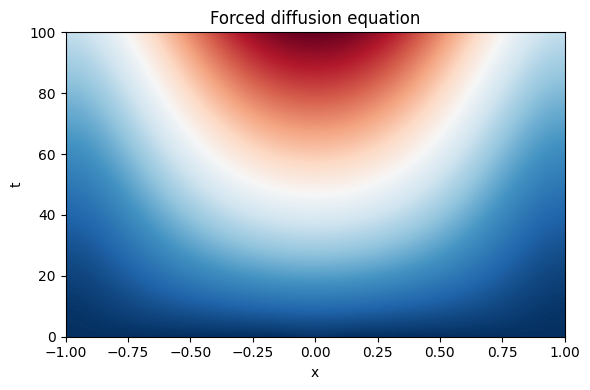

In [29]:
#Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()


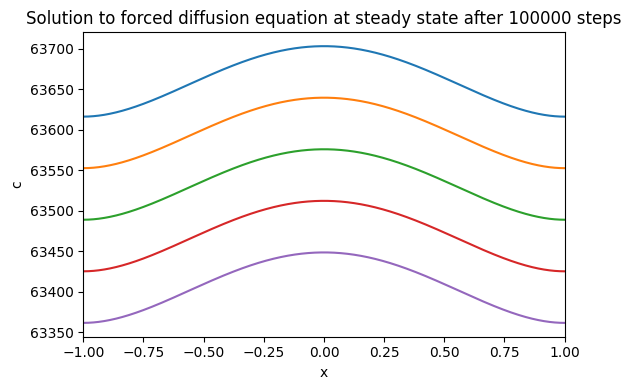

In [46]:
#Plot final run
plt.figure(figsize=(6, 4))
plt.plot(x, c_save[-1])
plt.plot(x, c_save[-1000])
plt.plot(x, c_save[-2000])
plt.plot(x, c_save[-3000])
plt.plot(x, c_save[-4000])
plt.xlim(x_start, x_end)
#plt.ylim()
plt.xlabel('x')
plt.ylabel('c')
plt.title('Solution to forced diffusion equation at steady state after '+ str(solver.stop_sim_time) +' steps, and runs of 1000 steps before the final state')
plt.tight_layout()

After some time, the fluid diffuses into a wide Gaussian shape of fixed width, but keeps travelling outward with subsequent runs with a fixed velocity.

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

### 5.2 Variable difusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

In [ ]:
# Write a Dedalus script to solve the diffusion equation with a spatially-variable diffusivity
# It is fine to copy and paste the scripts above as a starting point.

Explore the behaviour of the solution as you vary the parameters associated with $\kappa(x)$. Comment on your observations below (~1 paragraph)

INSERT COMMENTS HERE

## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
